In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json 
import os

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize

In [3]:
import seaborn as sns
sns.set(
    style='whitegrid', # стиль figure
    font_scale=2, # размер шрифта
    rc={'lines.linewidth': 3, # ширина линий
        'text.usetex' : True} # использовать tex
)

In [4]:
from data_utils import read_data, normalization, plot_results
from opt_utils import func, fit_curve 
from opt_utils import f_standard, get_x0_standard, unpack_standard
from opt_utils import f_exp, get_x0_exp, unpack_exp

In [5]:
bounds_standard = Bounds(
    np.array([0, 0, 0, 0, 0, 0], dtype=np.float64), 
    np.array([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf], dtype=np.float64)
)

cons_standard = [
    {
        'type': 'eq',
        'fun': lambda x: np.array([x[0] + x[1] + x[2] - 1]),
        'jac': lambda x: np.array([1.0, 1.0, 1.0, 0, 0, 0])
    },
    {
        'type': 'ineq',
        'fun': lambda x: np.array([x[3] - x[4]]),
        'jac': lambda x: np.array([0, 0, 0, 1.0, -1.0, 0])
    },
]

In [6]:
bounds_exp = Bounds(
    np.array([0, 0], dtype=np.float64), 
    np.array([np.inf, np.inf], dtype=np.float64)
)

cons_exp = []

## Собираем все дериктории стеков

In [7]:
source_path = 'CFs'

In [8]:
dirs = os.listdir(source_path)
results = []
for cdir in ['5', '13']: 
    dirs.remove(cdir)
    dirs.extend([os.path.join(cdir, d) for d in os.listdir(os.path.join(source_path, cdir))])
dirs.remove('.ipynb_checkpoints')

In [9]:
dirs

['2',
 '12',
 '1',
 '8',
 '3',
 '7',
 '10',
 '6',
 '4',
 '14',
 '9',
 '11',
 '5/down_part900',
 '5/upper_part900',
 '13/down',
 '13/upper']

  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/2/results


/home/elavrukhin/Study/curve_fitting/opt_utils.py:38: RuntimeWarning: divide by zero encountered in true_divide
  f2 = np.exp(-r/b)
/home/elavrukhin/Study/curve_fitting/opt_utils.py:38: RuntimeWarning: invalid value encountered in true_divide
  f2 = np.exp(-r/b)
/home/elavrukhin/Study/curve_fitting/opt_utils.py:37: RuntimeWarning: divide by zero encountered in true_divide
  f1 = np.exp(-r/a)
/home/elavrukhin/Study/curve_fitting/opt_utils.py:37: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(-r/a)
  6%|▋         | 1/16 [00:02<00:34,  2.30s/it]/home/elavrukhin/Study/curve_fitting/opt_utils.py:37: RuntimeWarning: divide by zero encountered in true_divide
  f1 = np.exp(-r/a)
/home/elavrukhin/Study/curve_fitting/opt_utils.py:37: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.exp(-r/a)
/home/elavrukhin/Study/curve_fitting/opt_utils.py:38: RuntimeWarning: divide by zero encountered in true_divide
  f2 = np.exp(-r/b)
/home/elavrukhin/Study/curve_fitt

Current directory: CFs/12/results


 25%|██▌       | 4/16 [00:07<00:22,  1.84s/it]/home/elavrukhin/Study/curve_fitting/data_utils.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))
  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/1/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/8/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/3/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/7/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/10/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/6/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/4/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/14/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/9/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/11/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/5/down_part900/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/5/upper_part900/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/13/down/results


  0%|          | 0/16 [00:00<?, ?it/s]

Current directory: CFs/13/upper/results


100%|██████████| 16/16 [00:34<00:00,  2.15s/it]


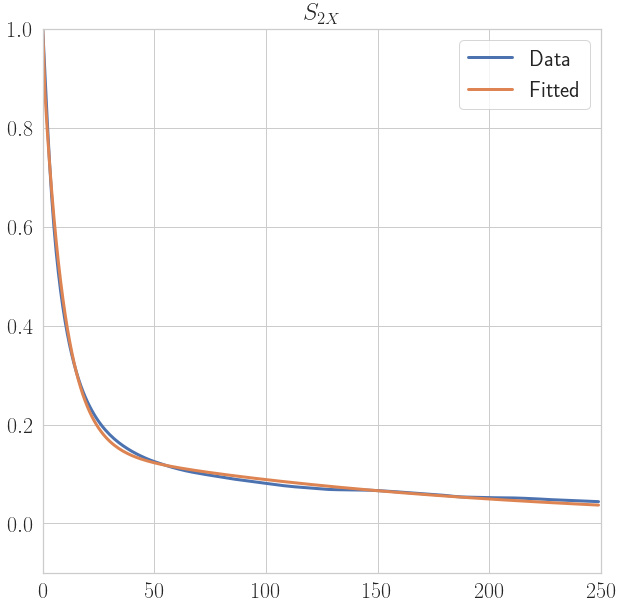

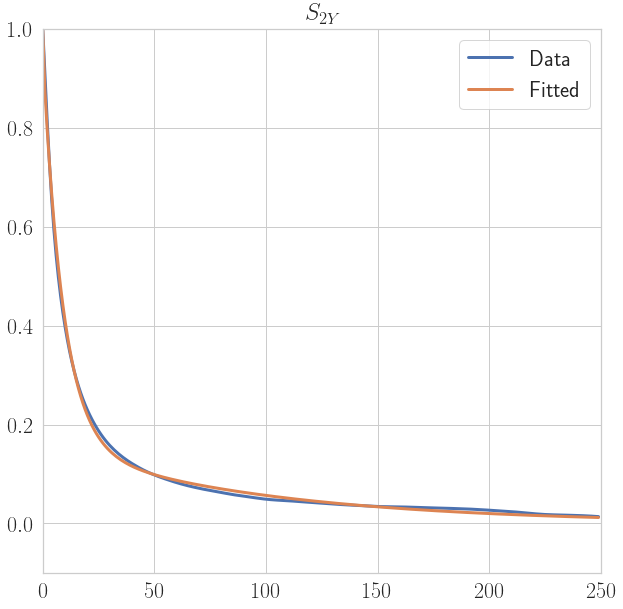

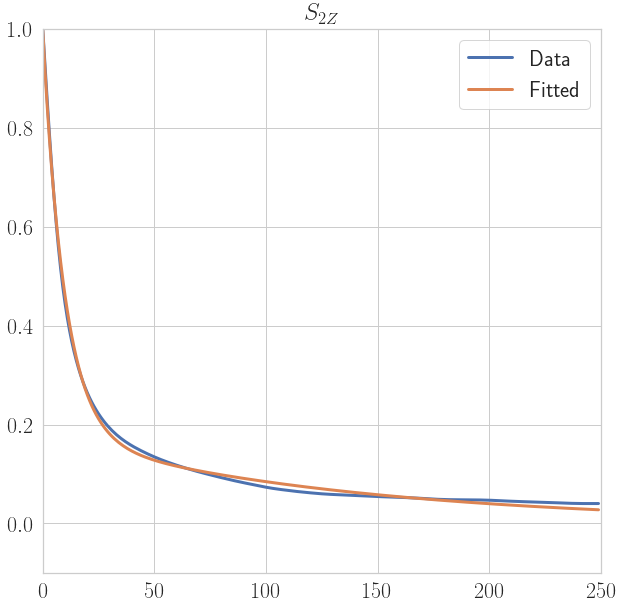

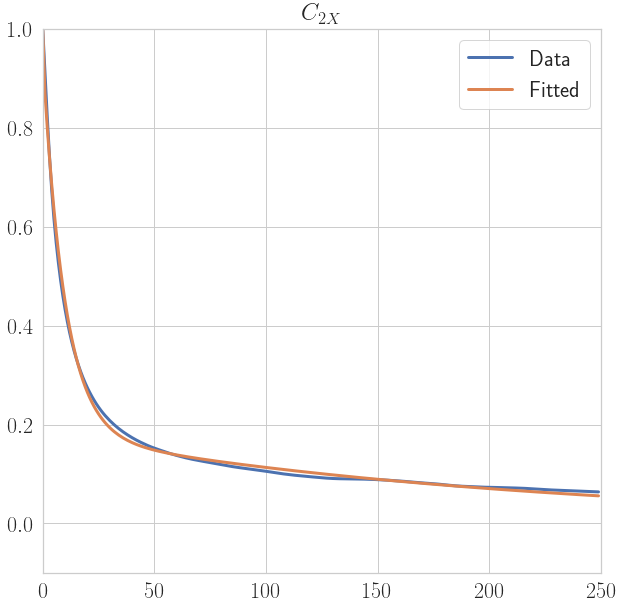

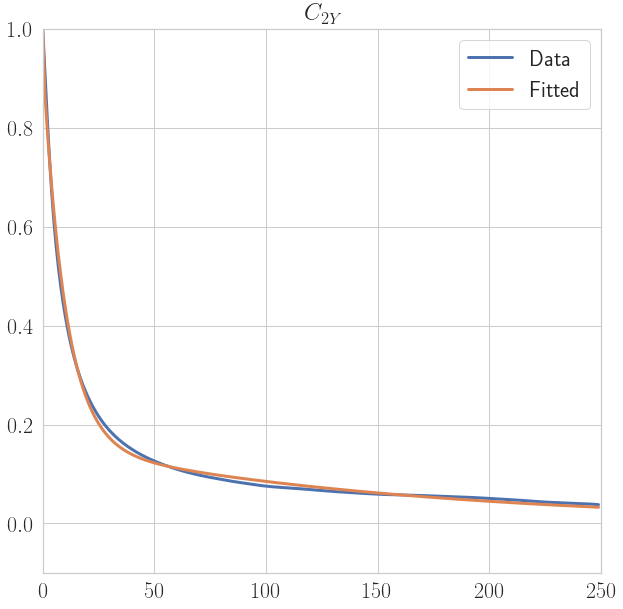

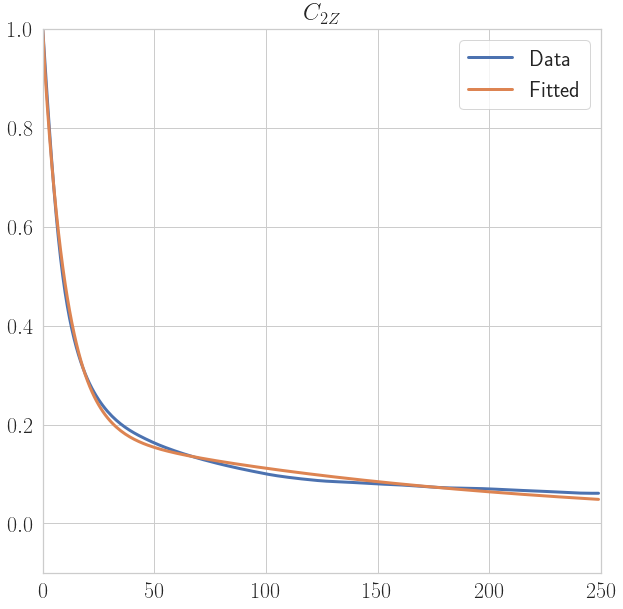

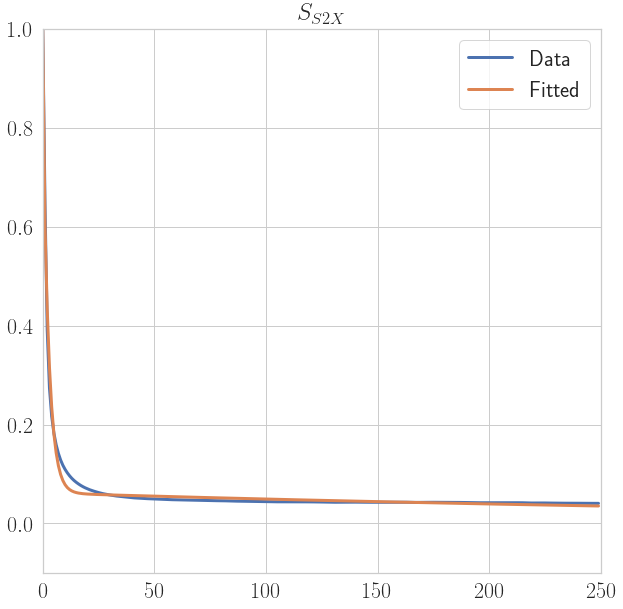

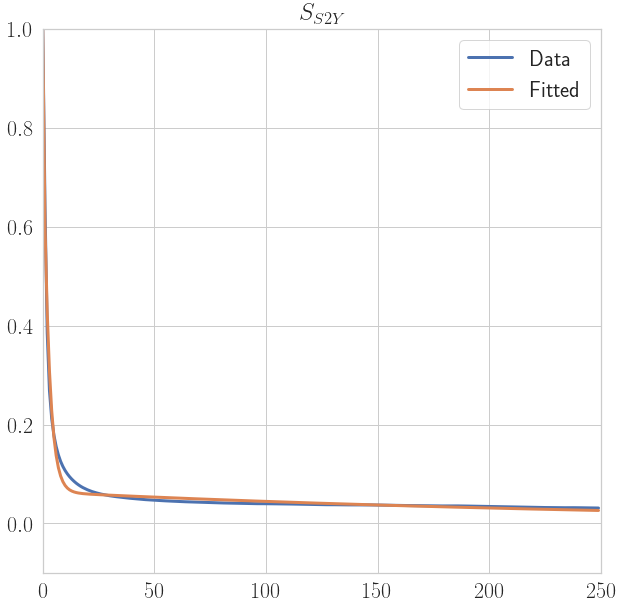

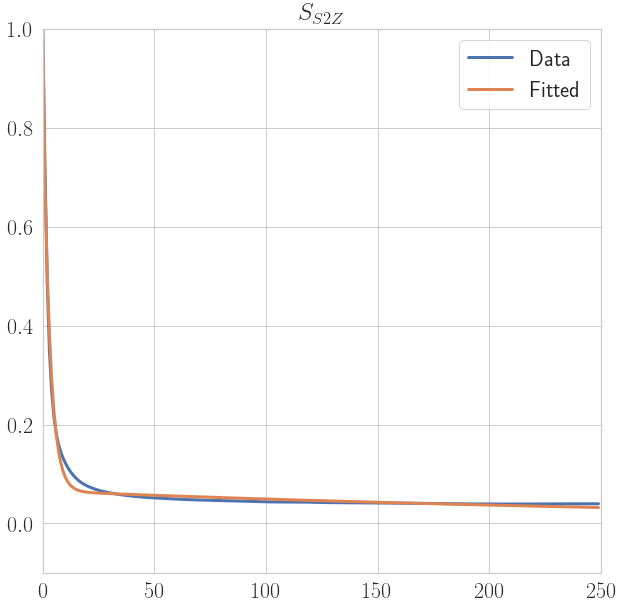

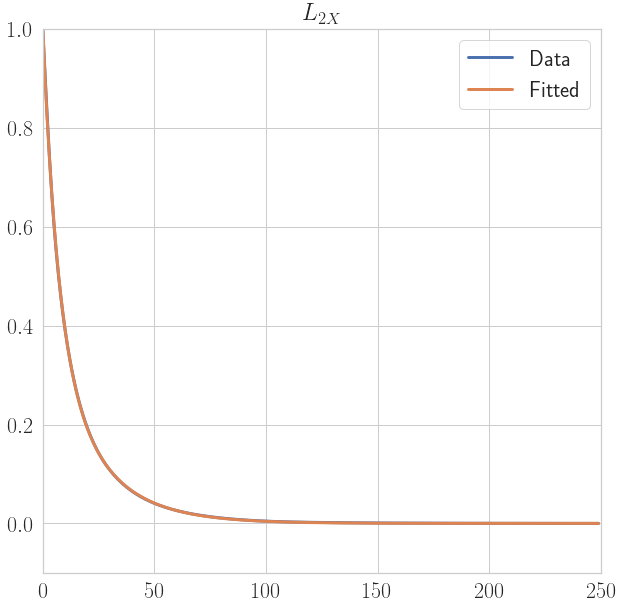

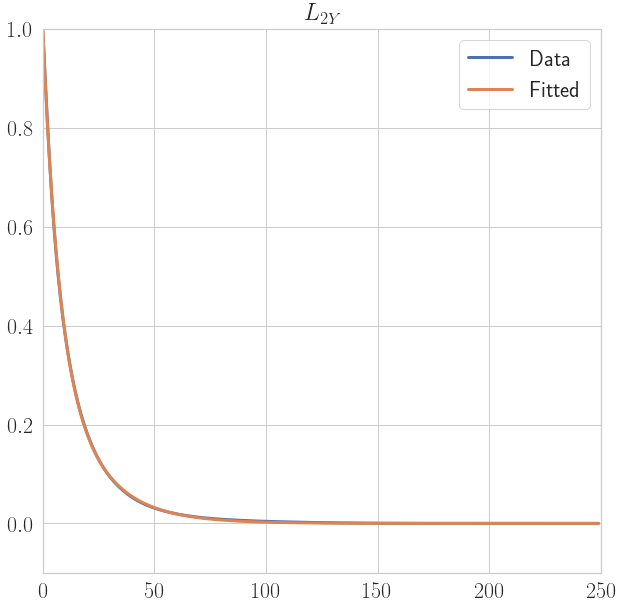

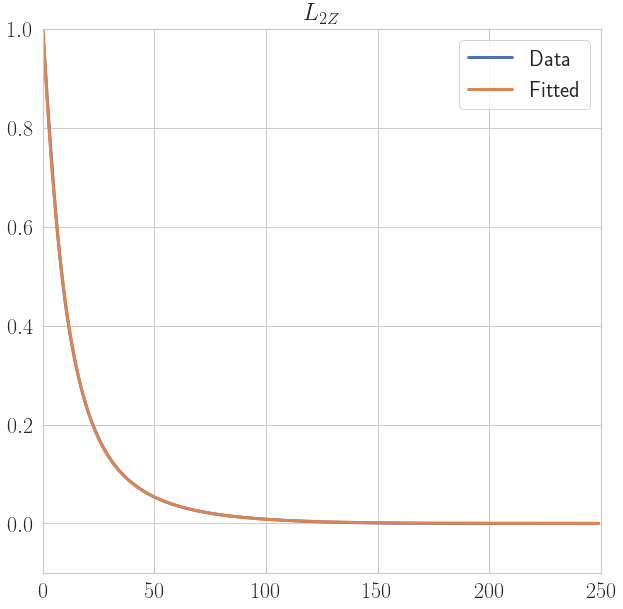

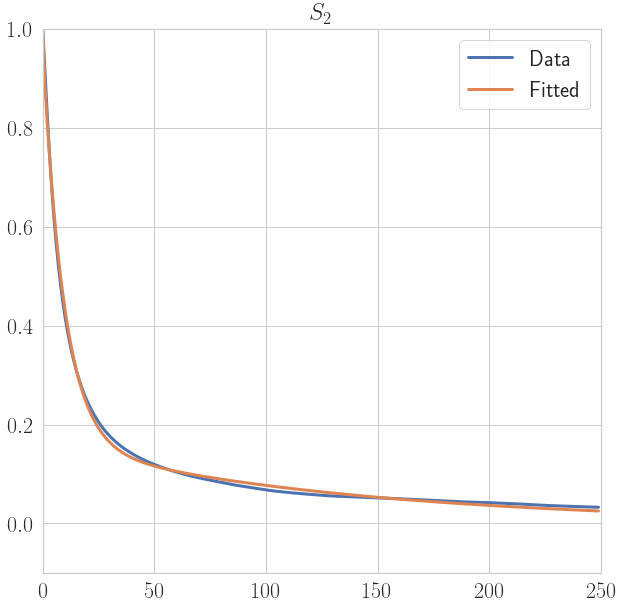

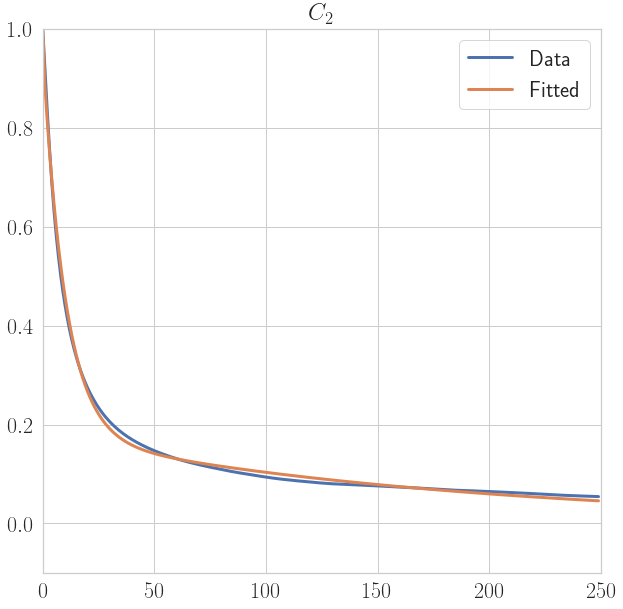

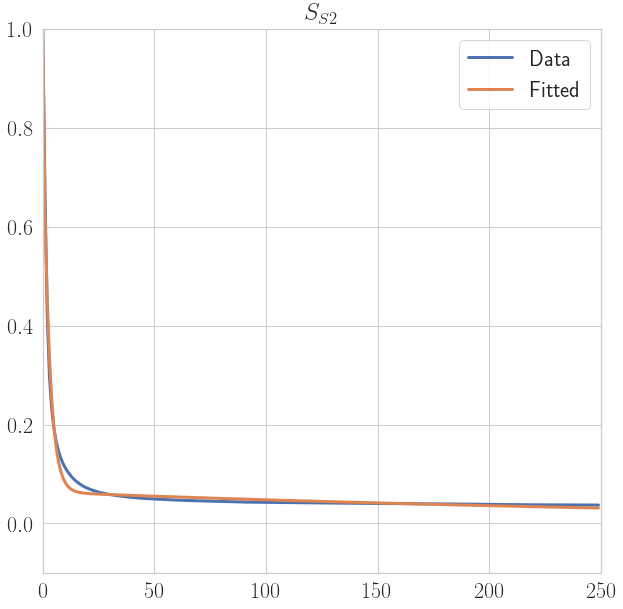

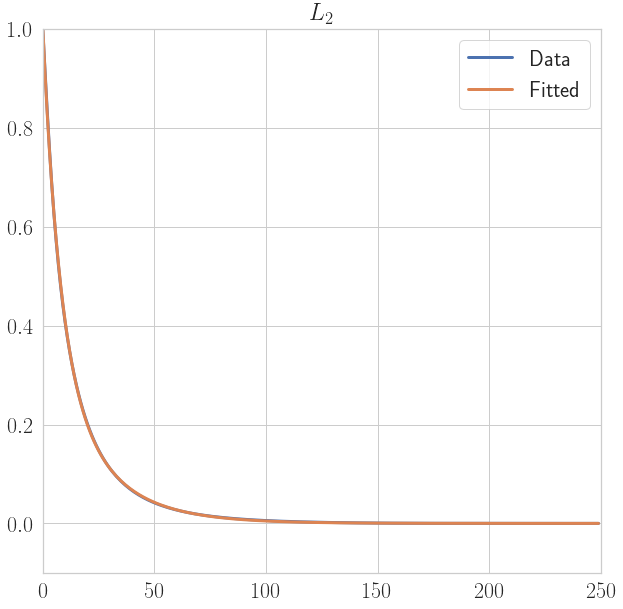

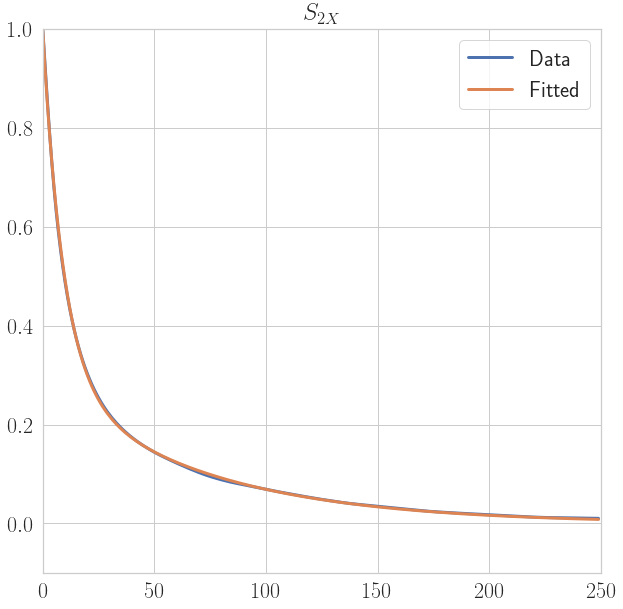

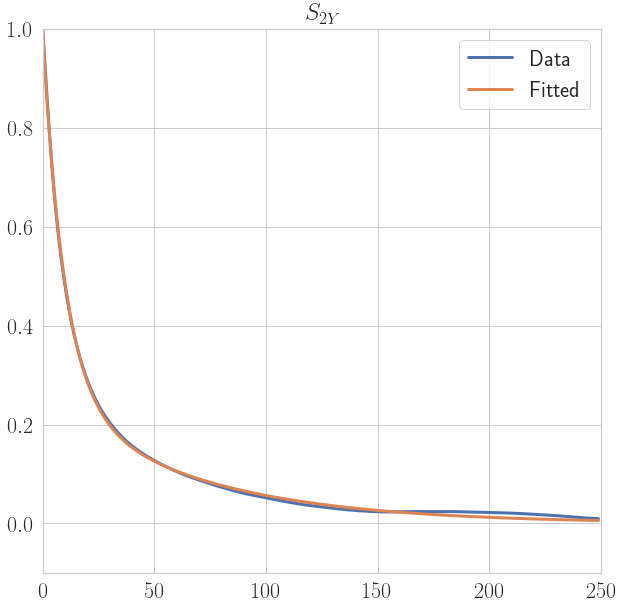

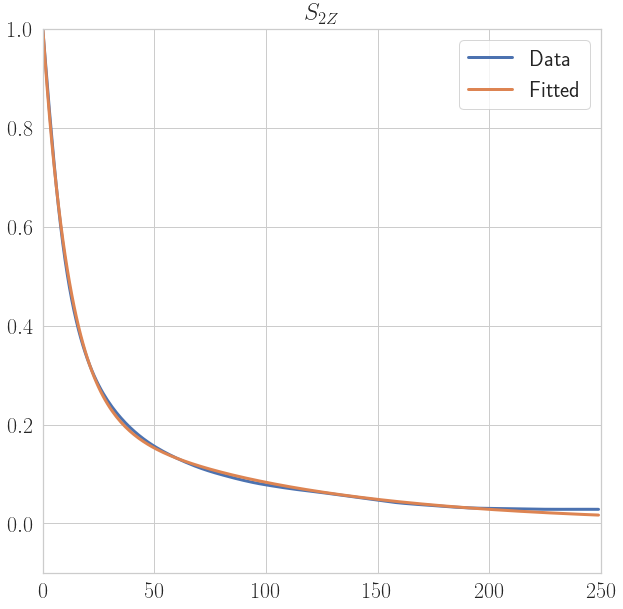

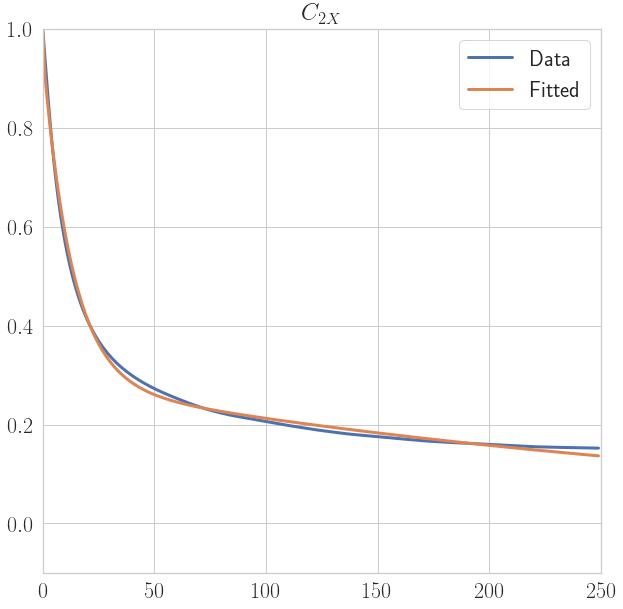

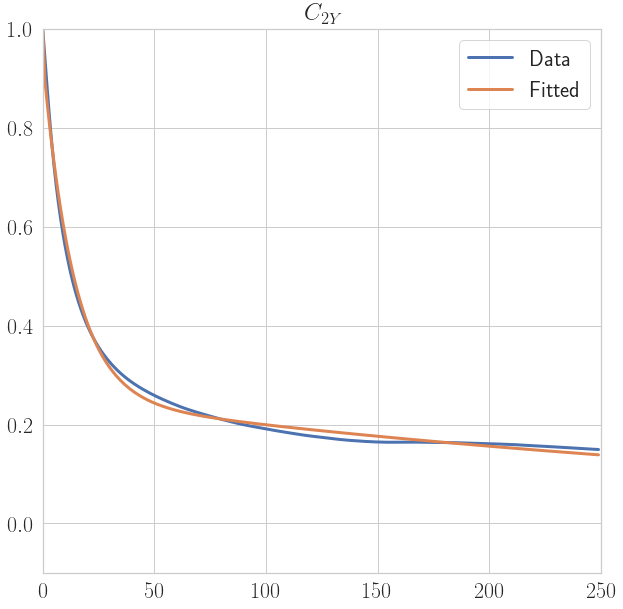

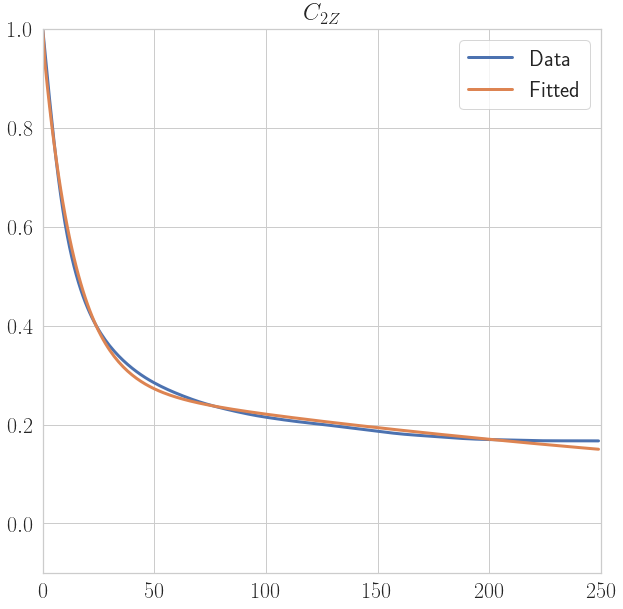

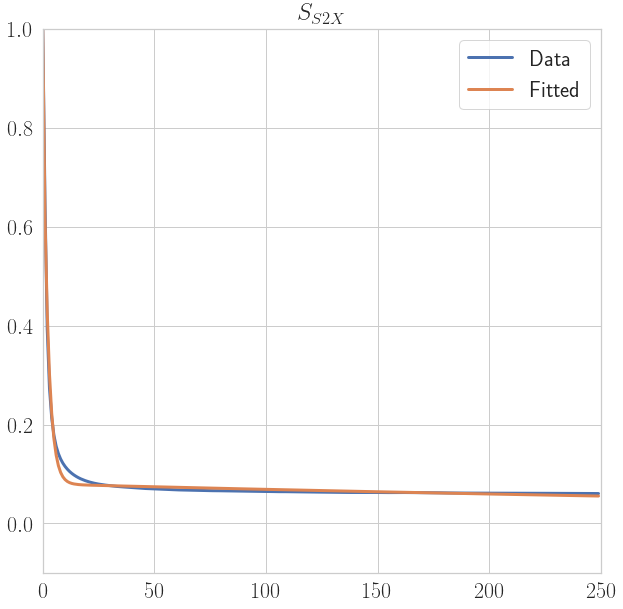

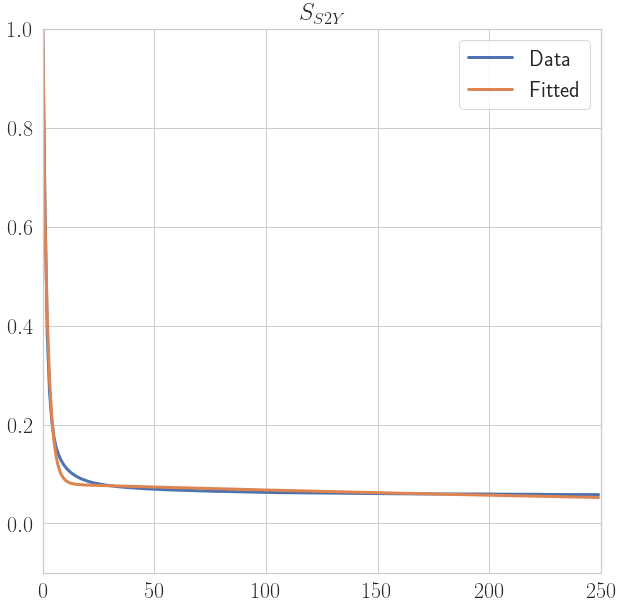

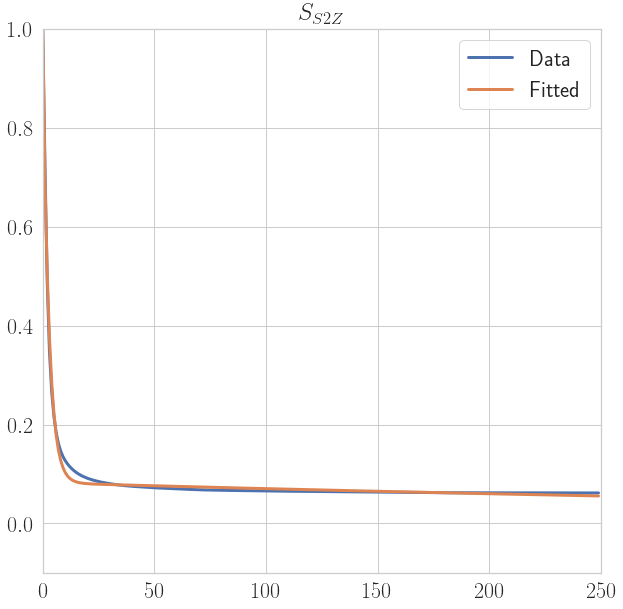

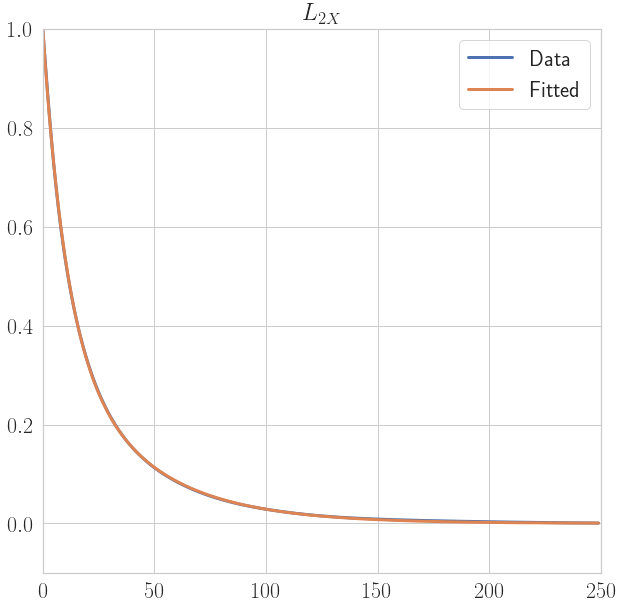

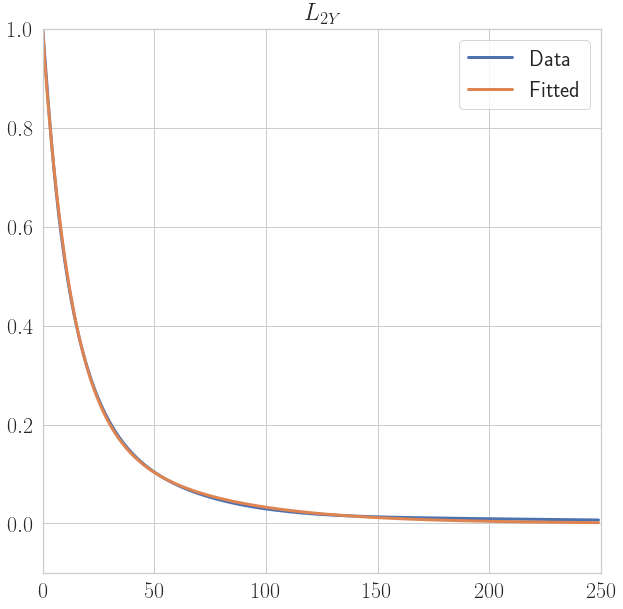

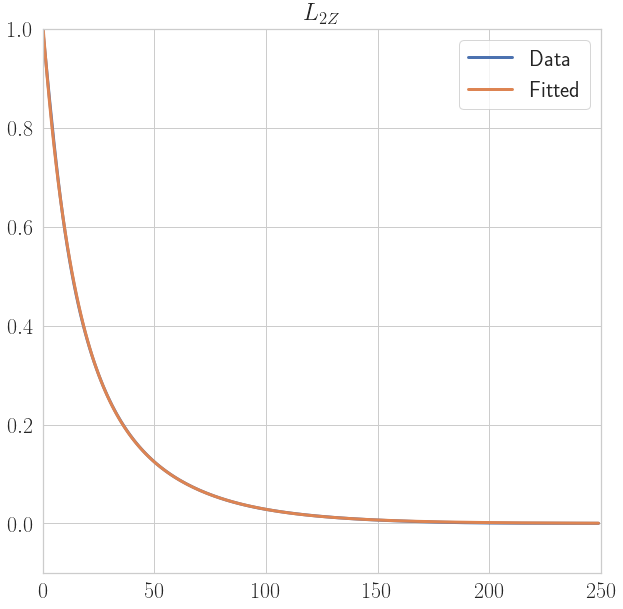

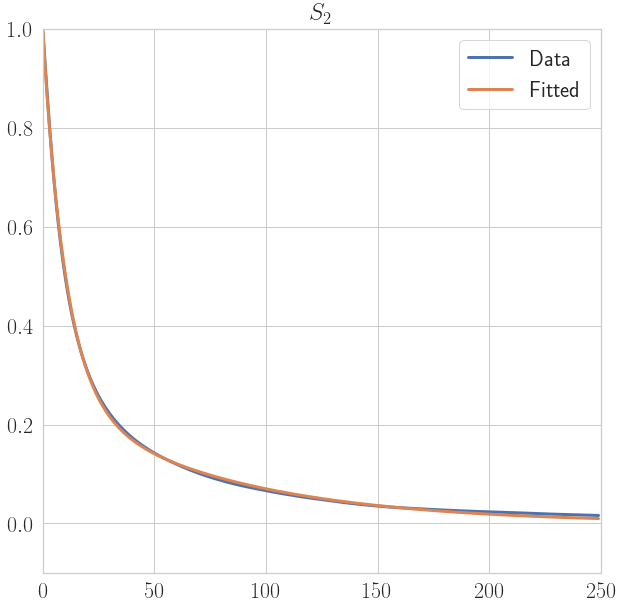

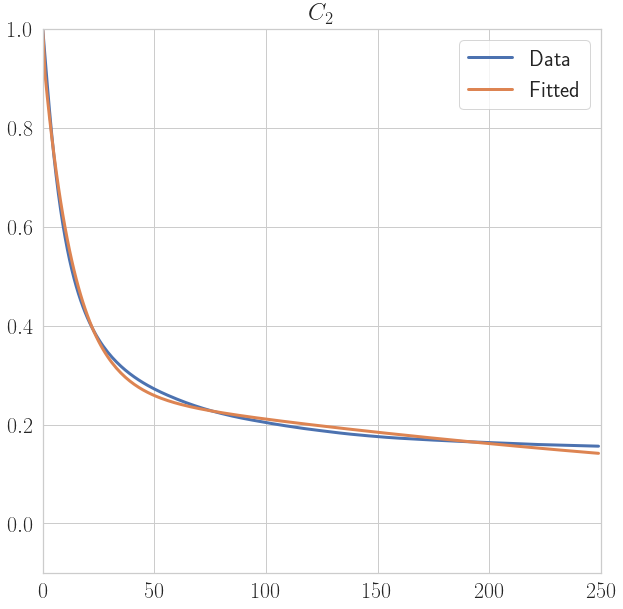

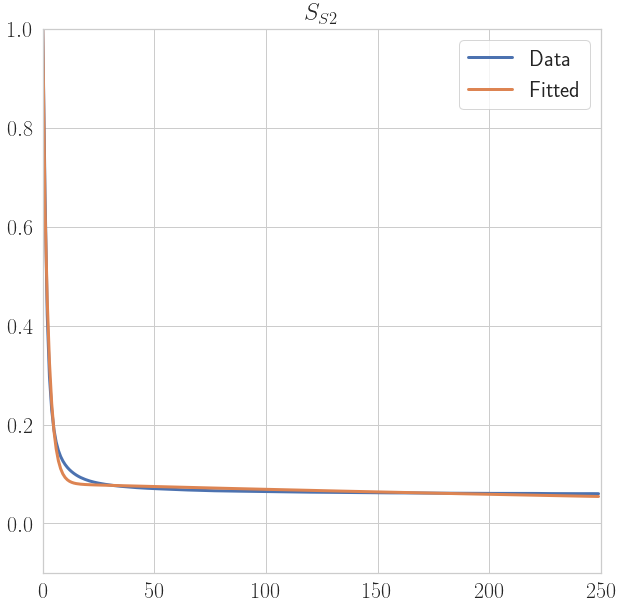

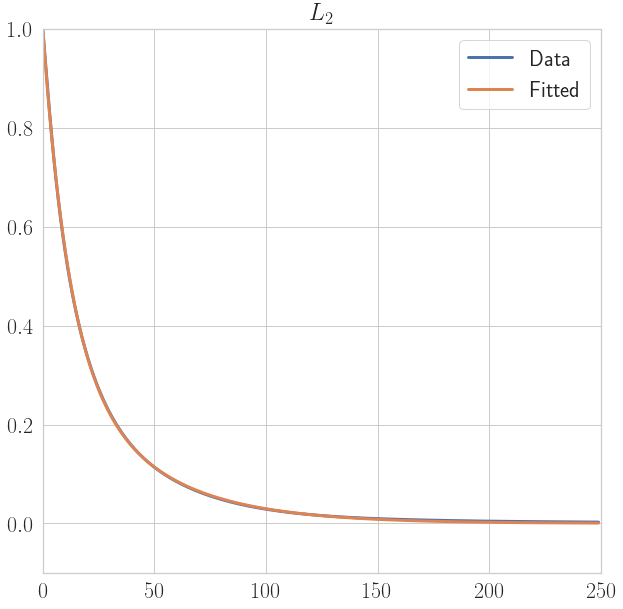

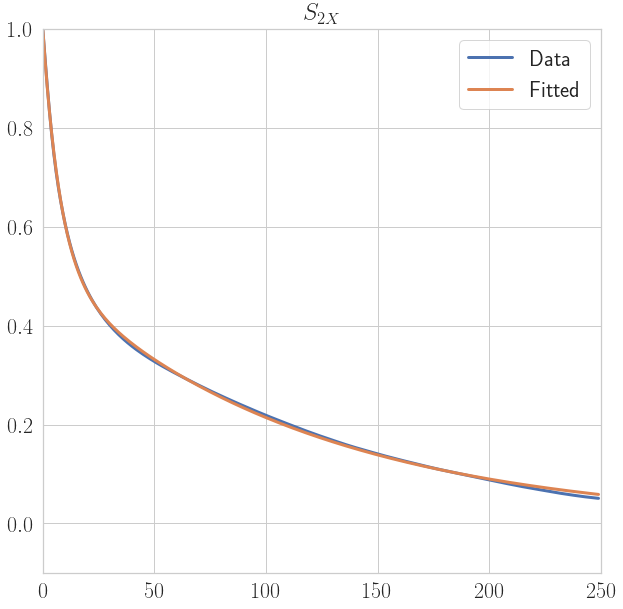

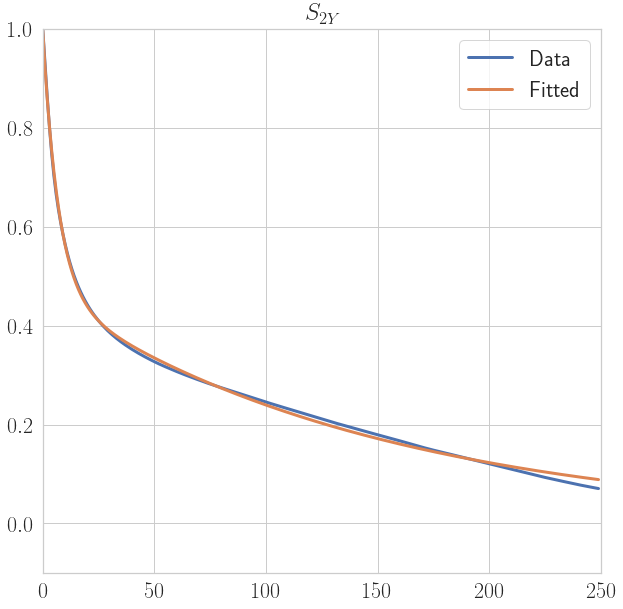

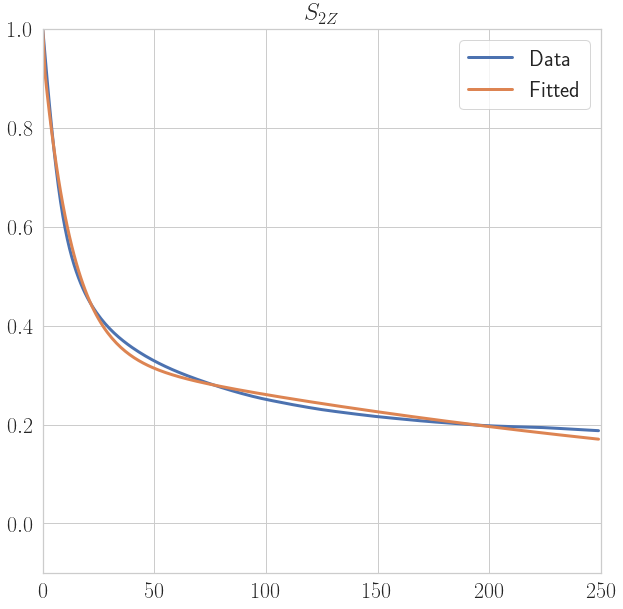

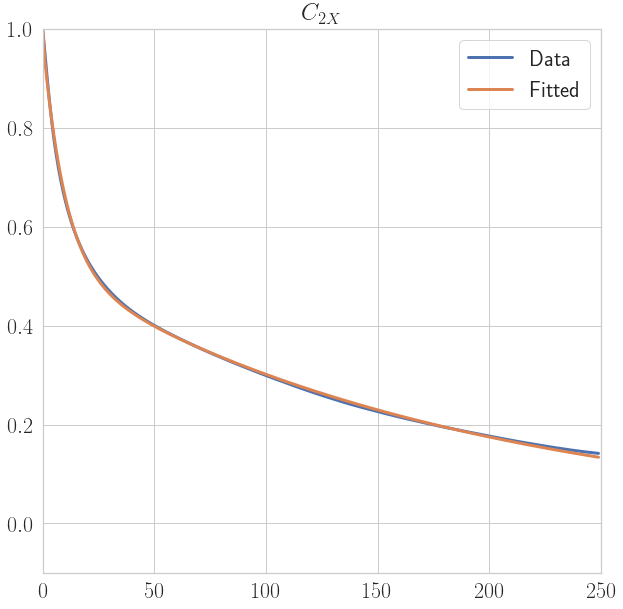

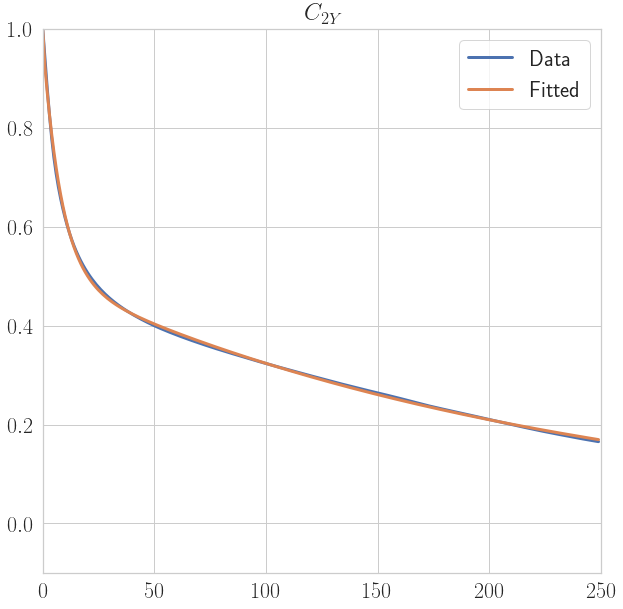

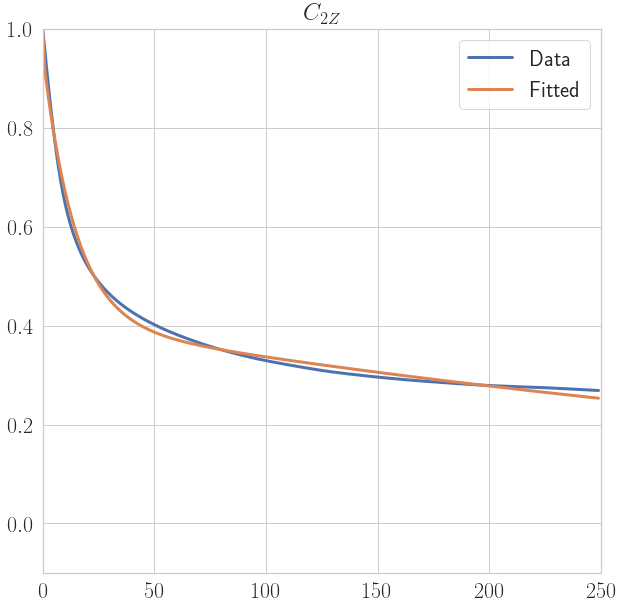

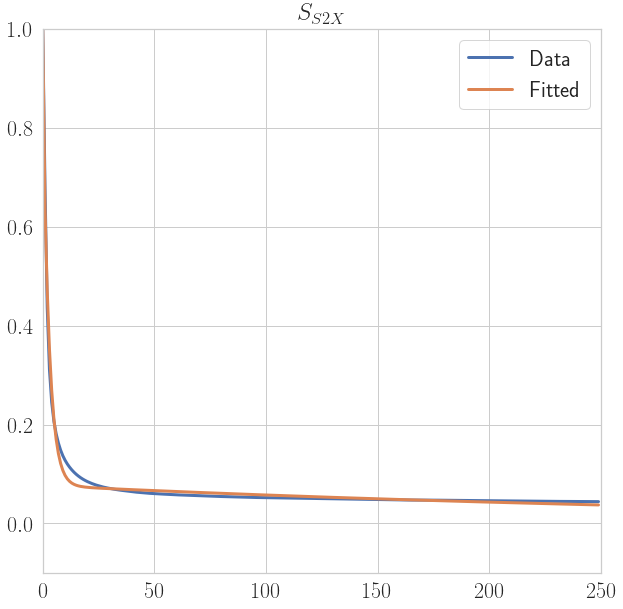

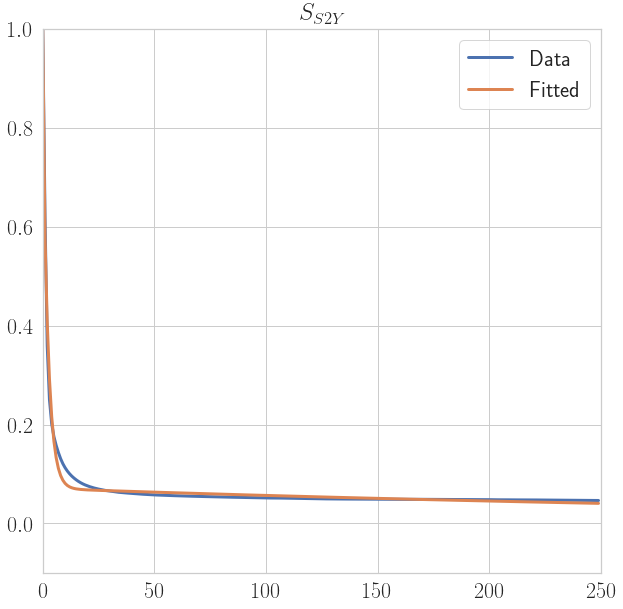

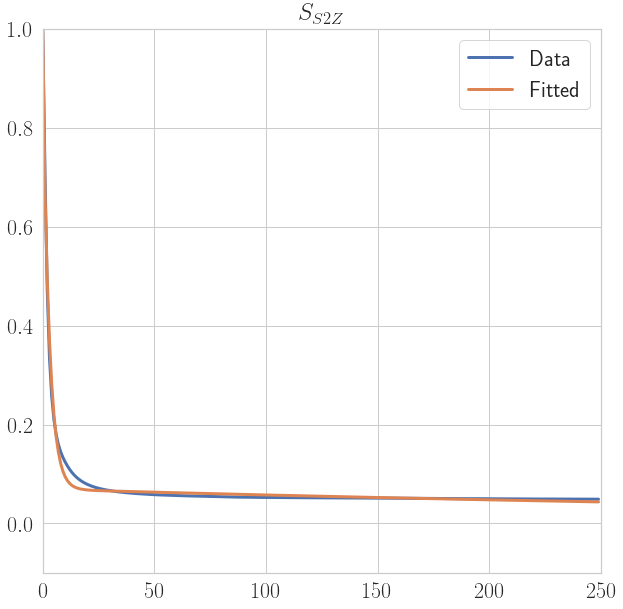

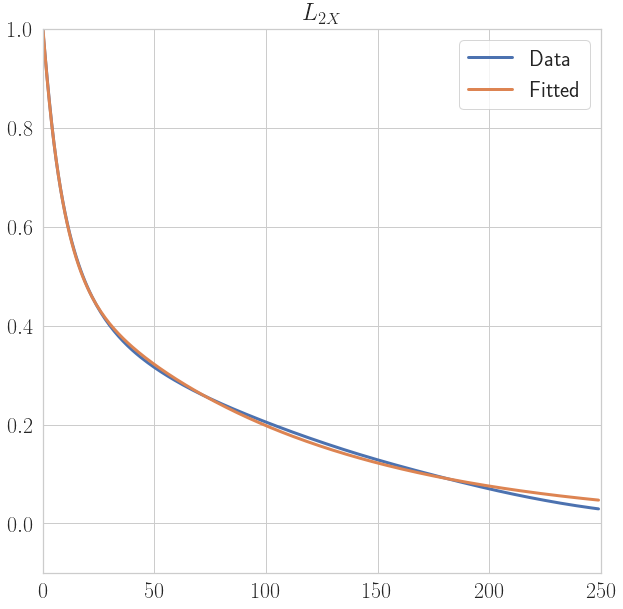

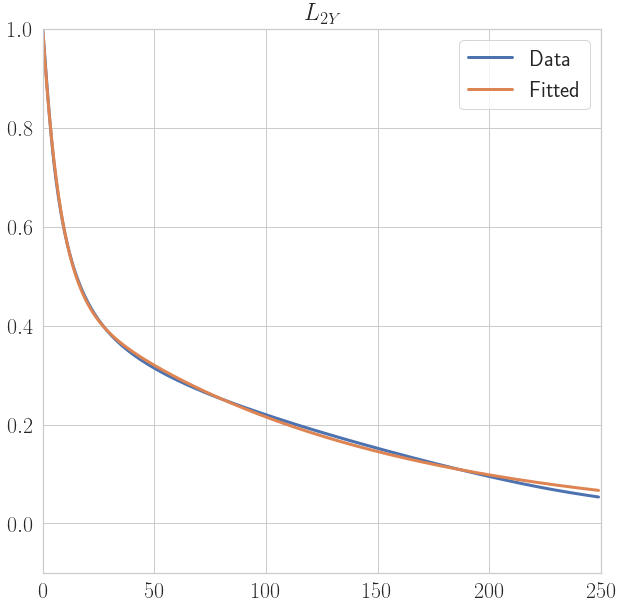

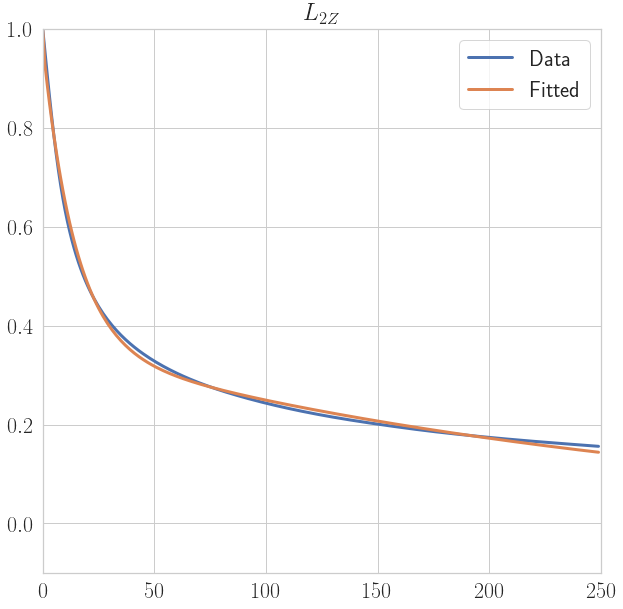

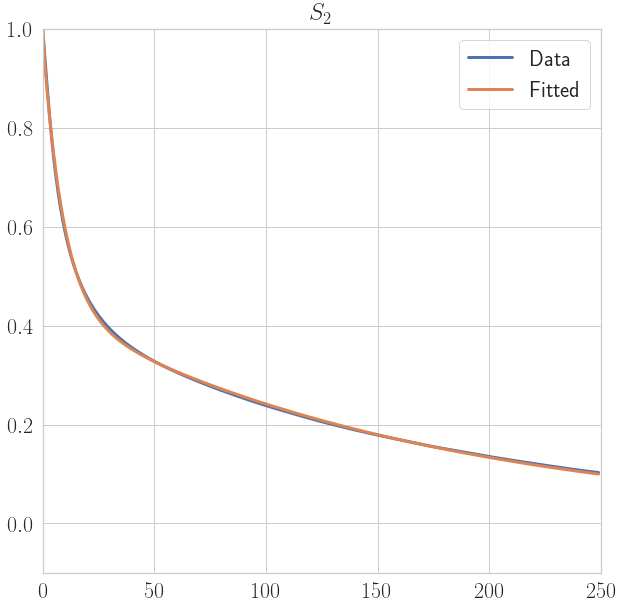

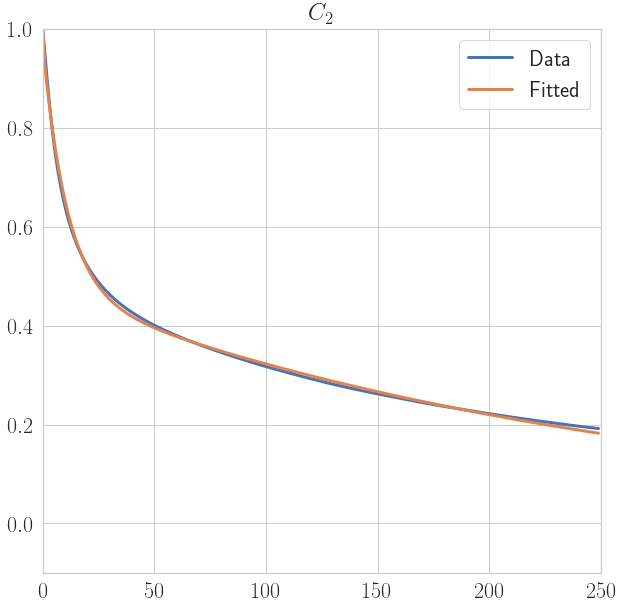

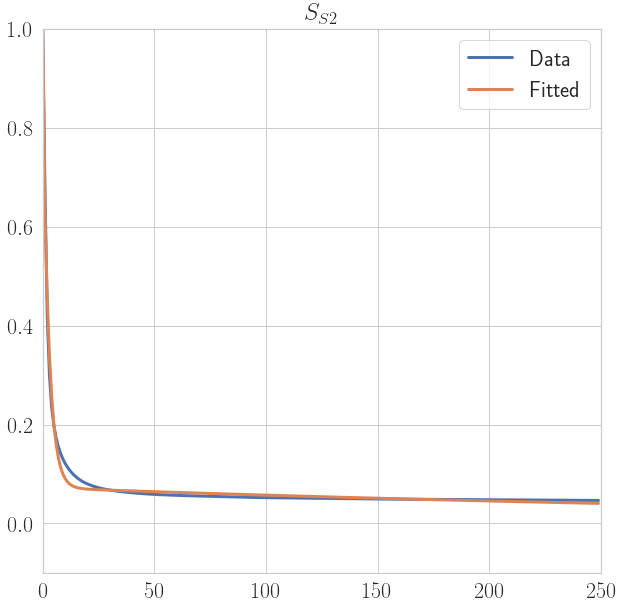

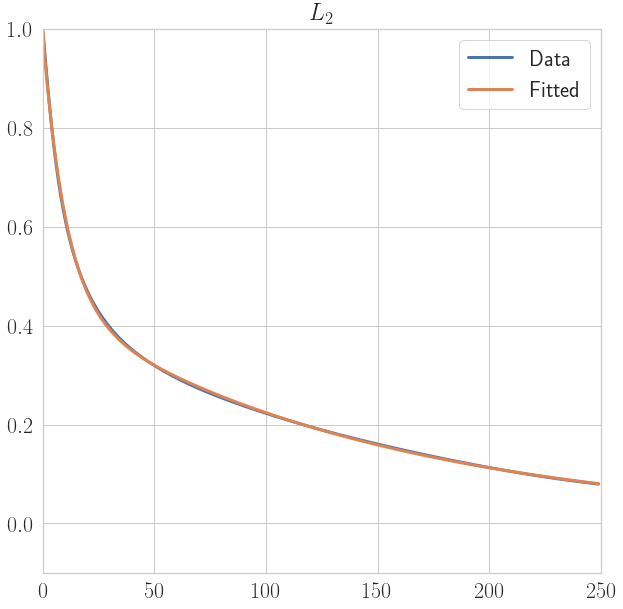

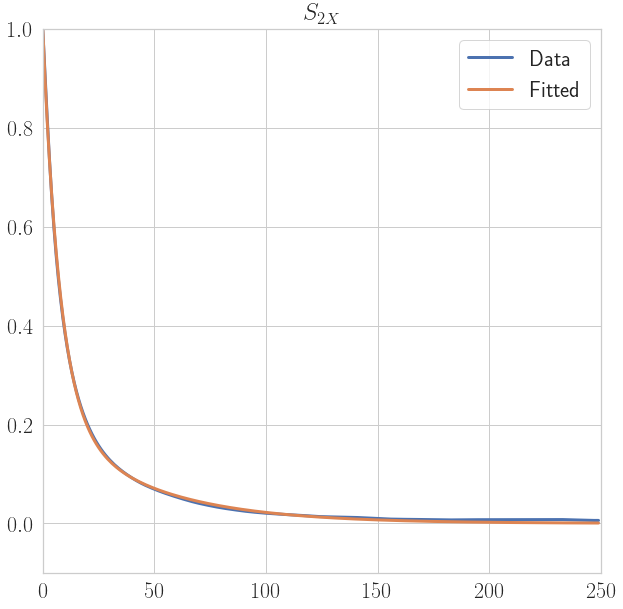

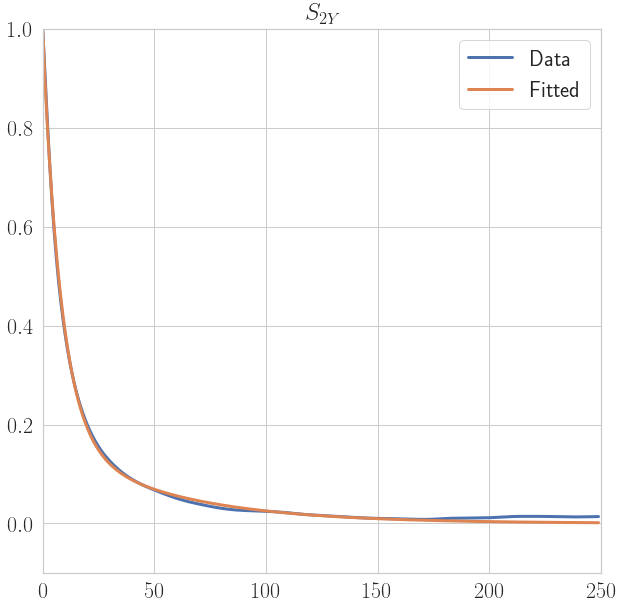

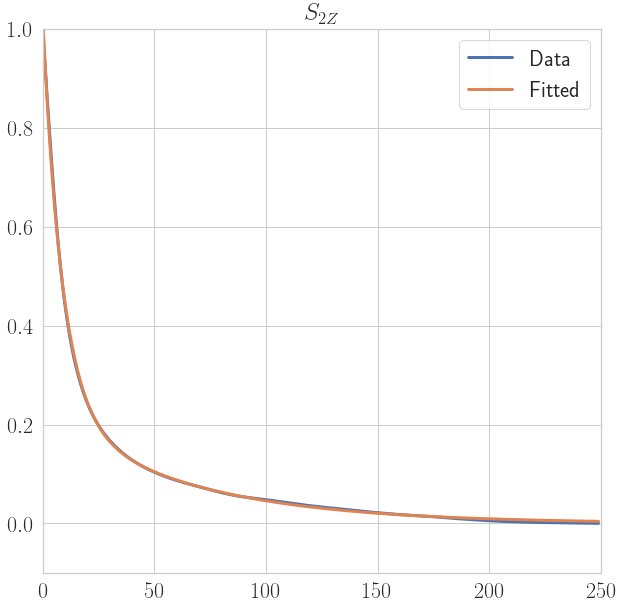

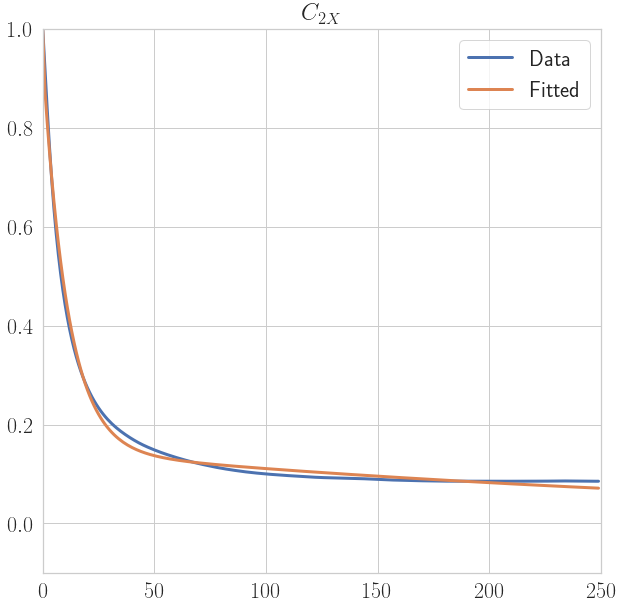

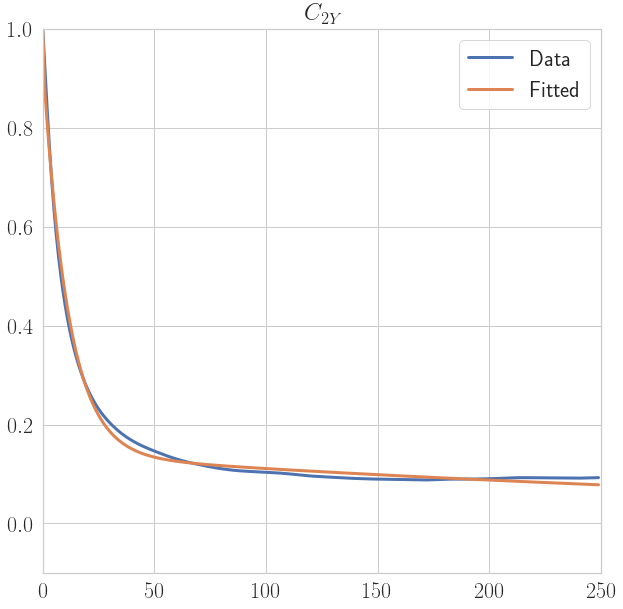

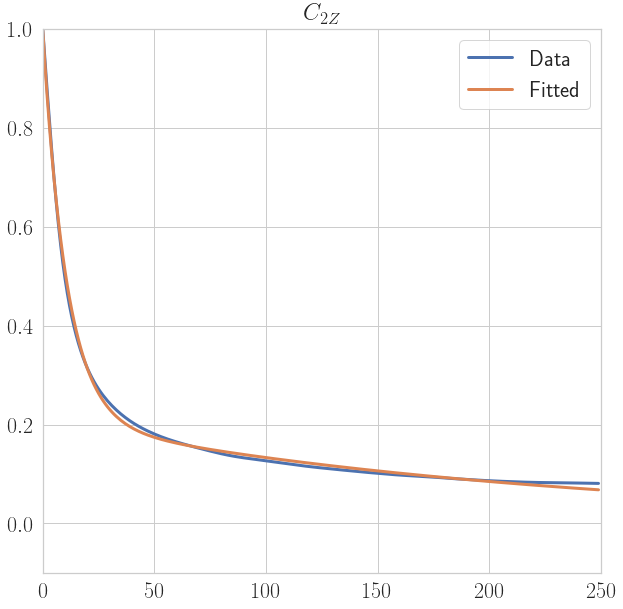

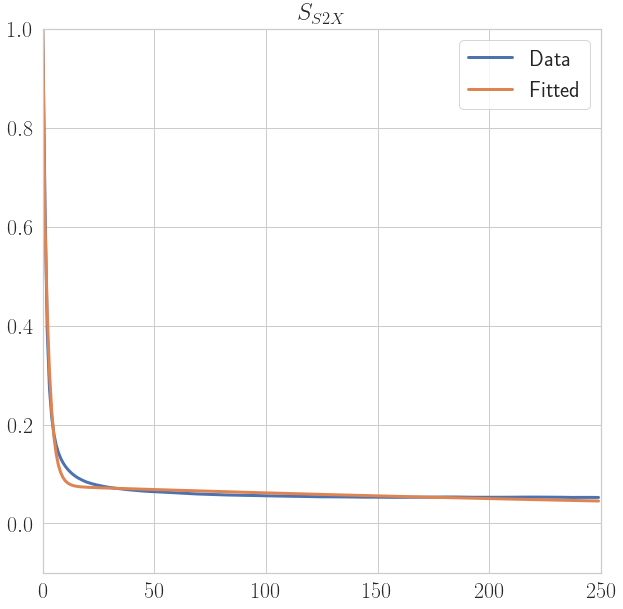

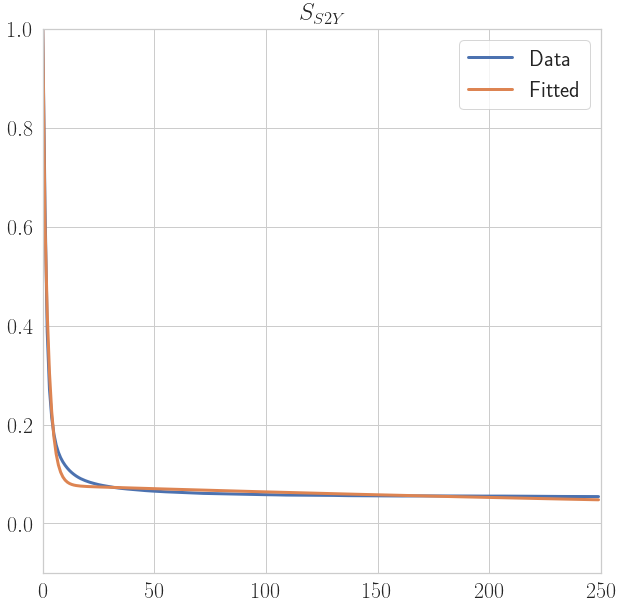

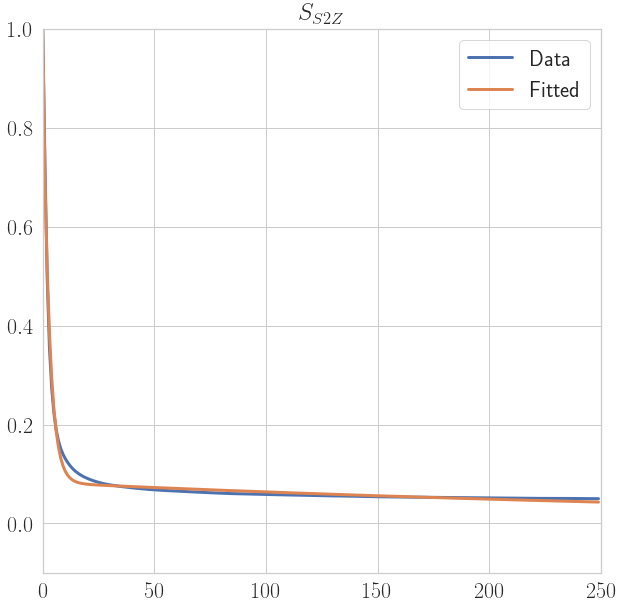

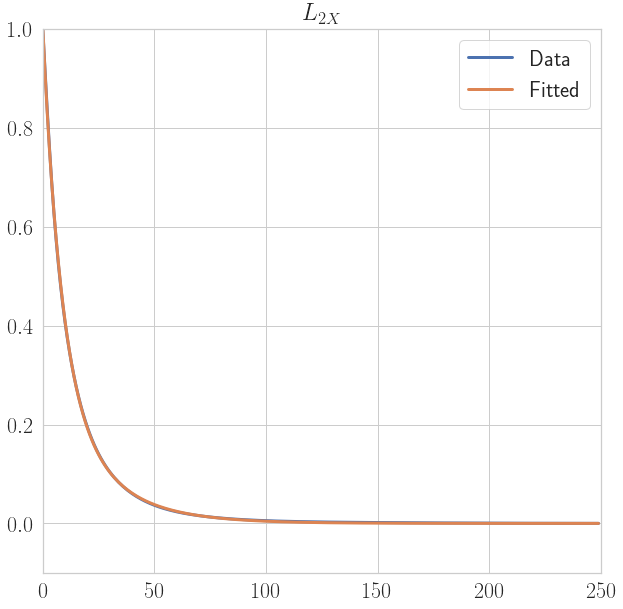

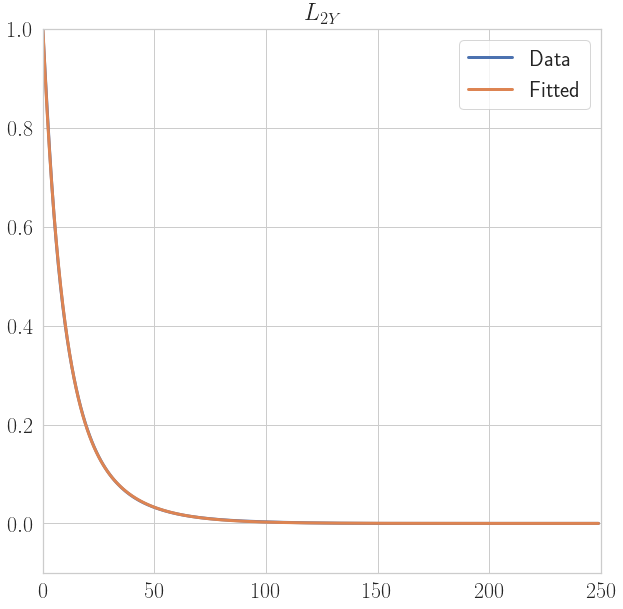

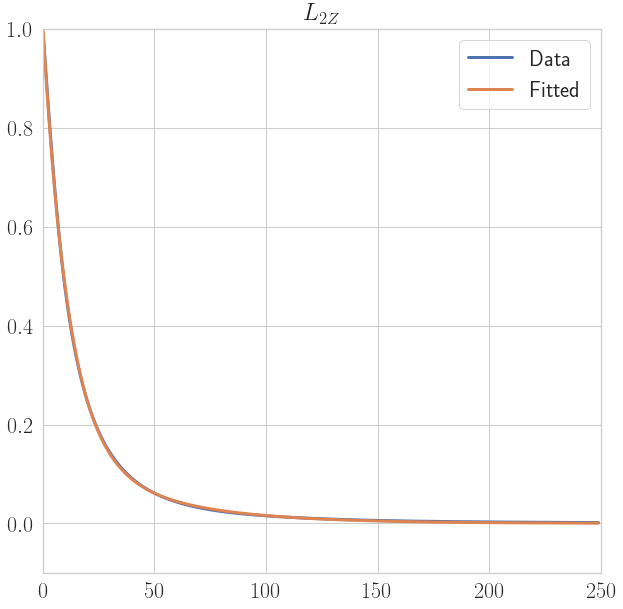

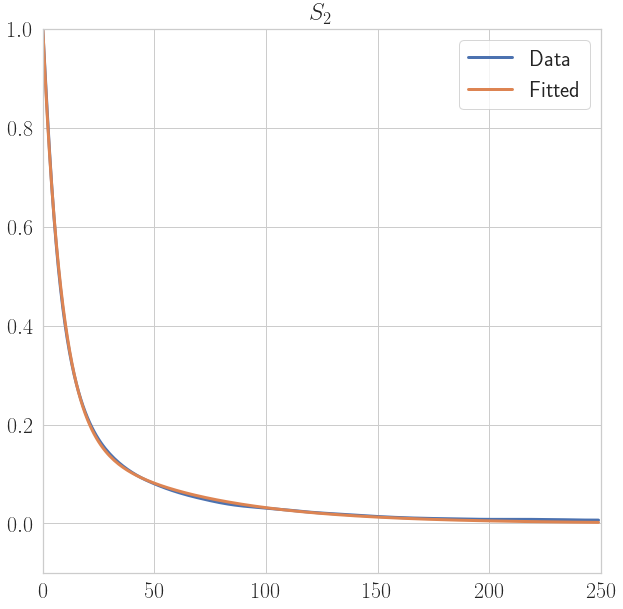

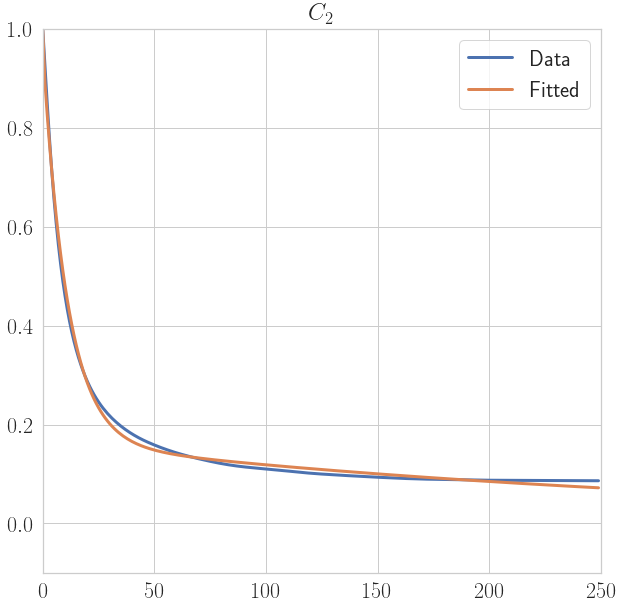

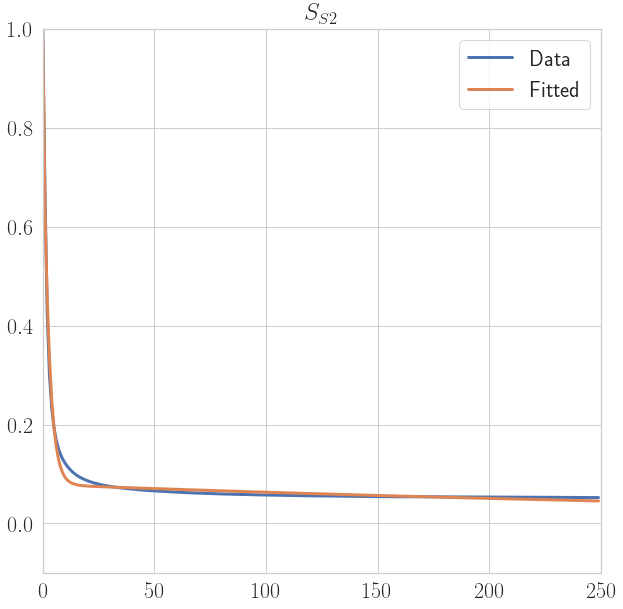

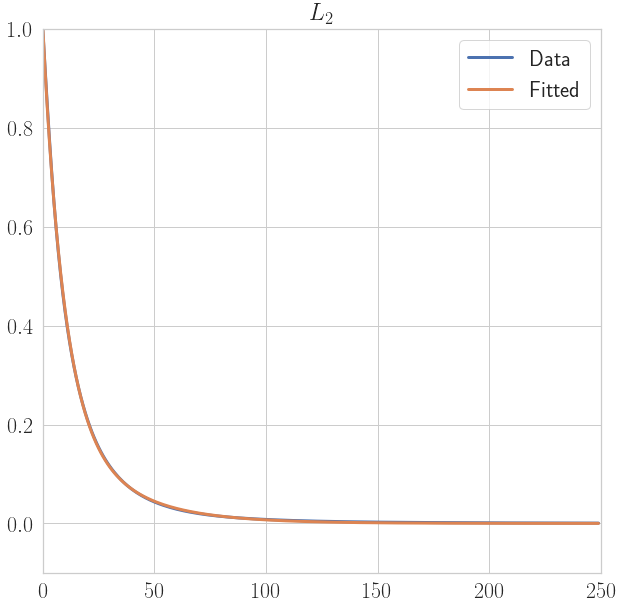

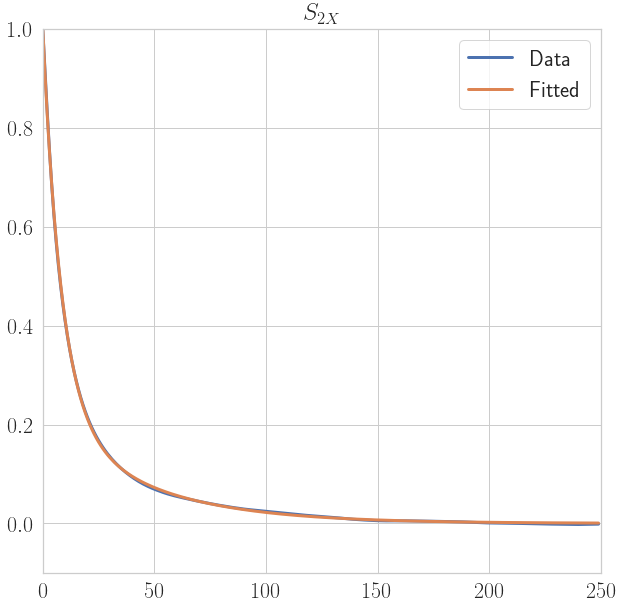

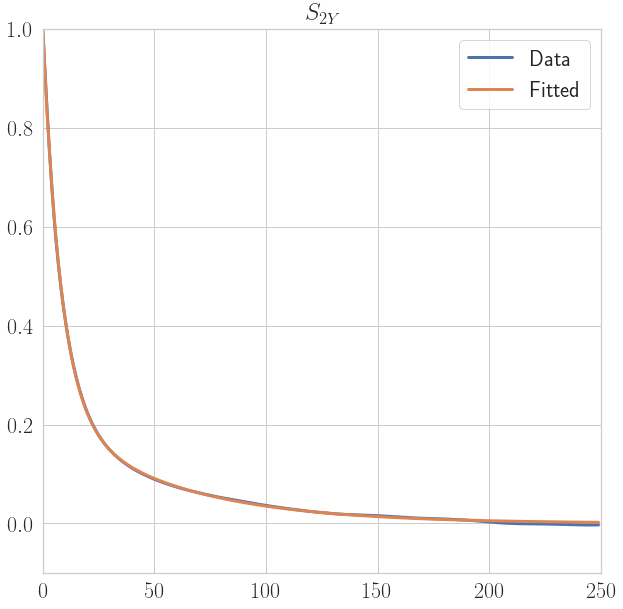

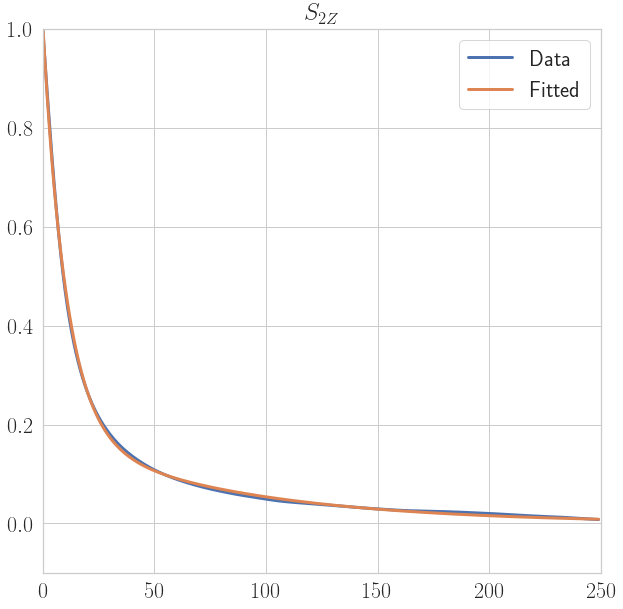

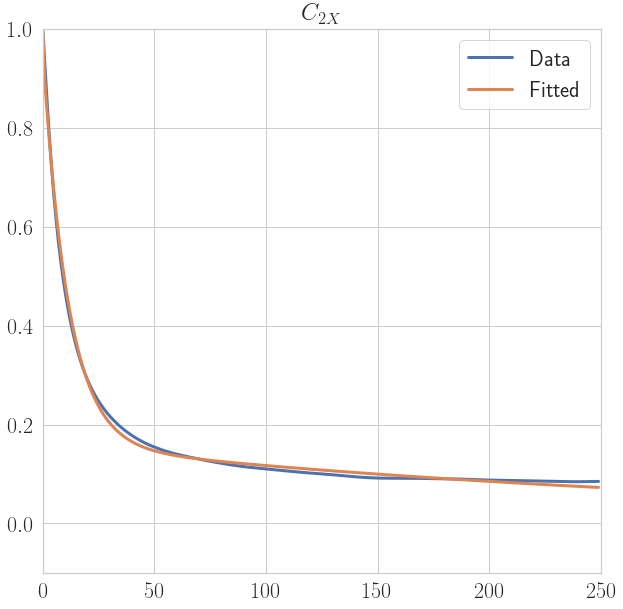

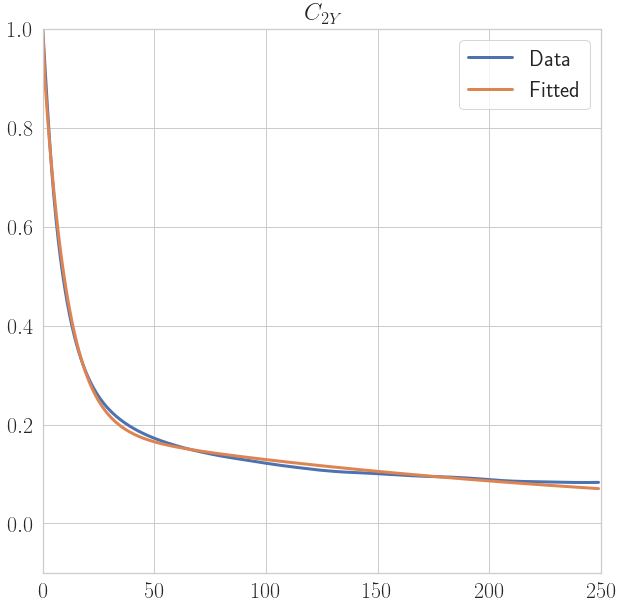

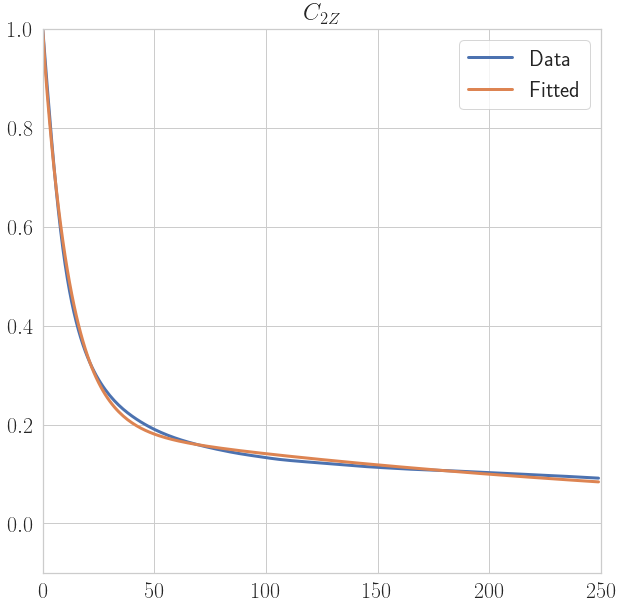

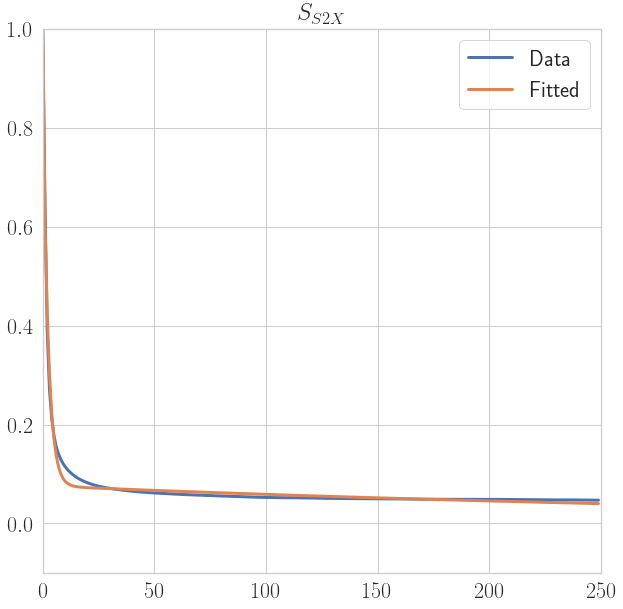

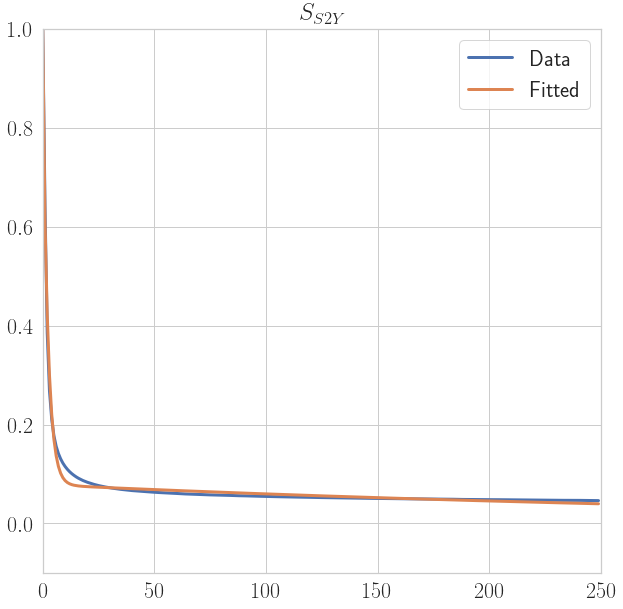

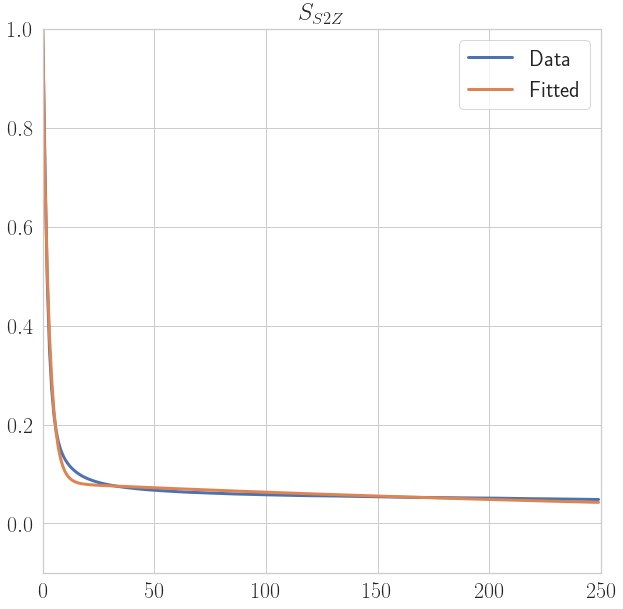

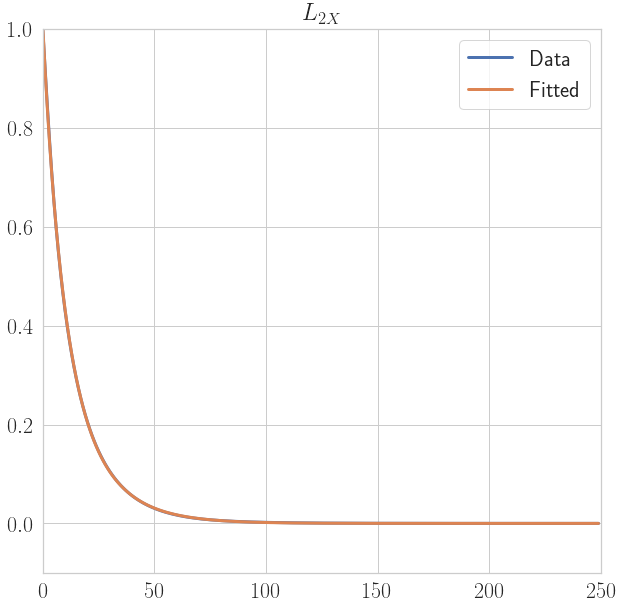

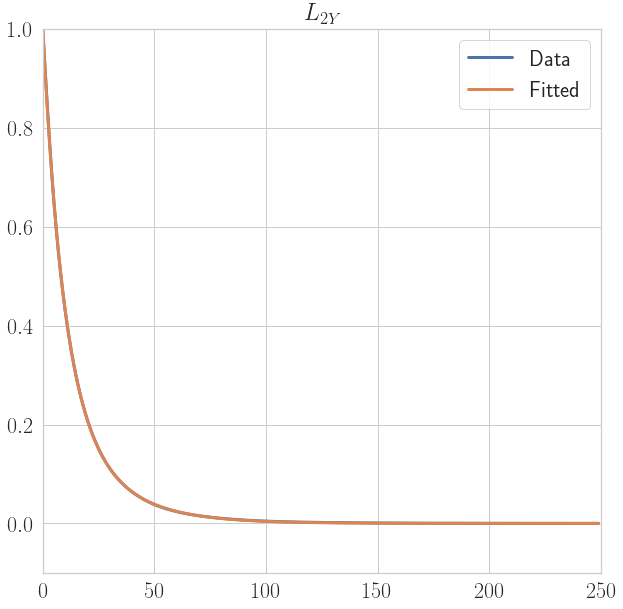

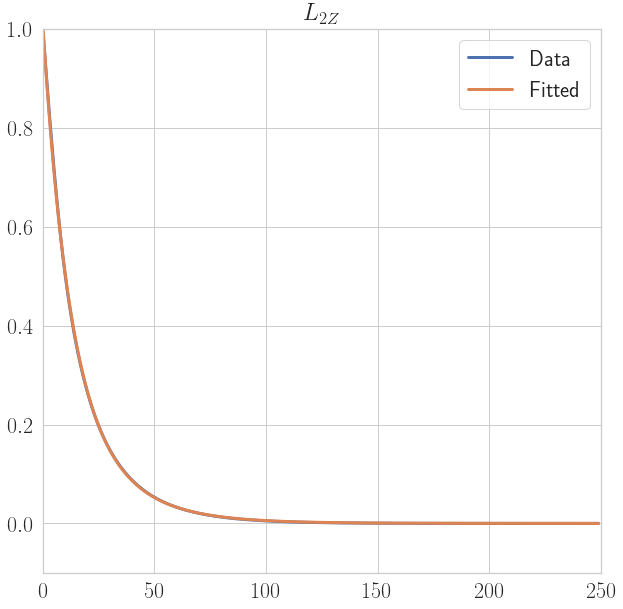

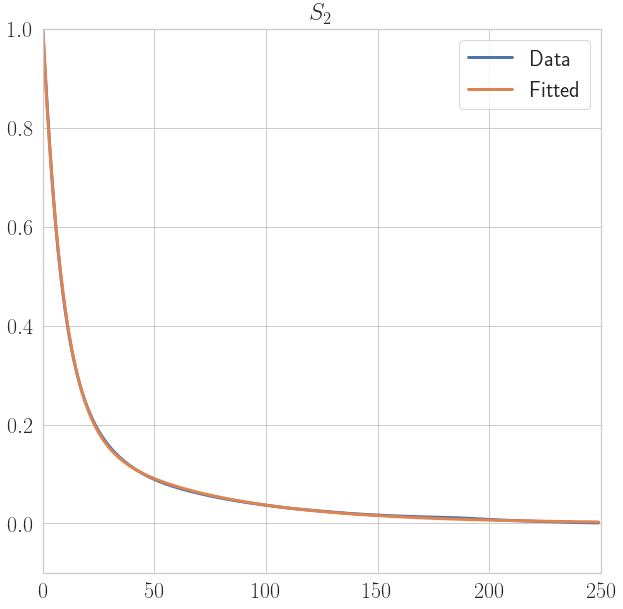

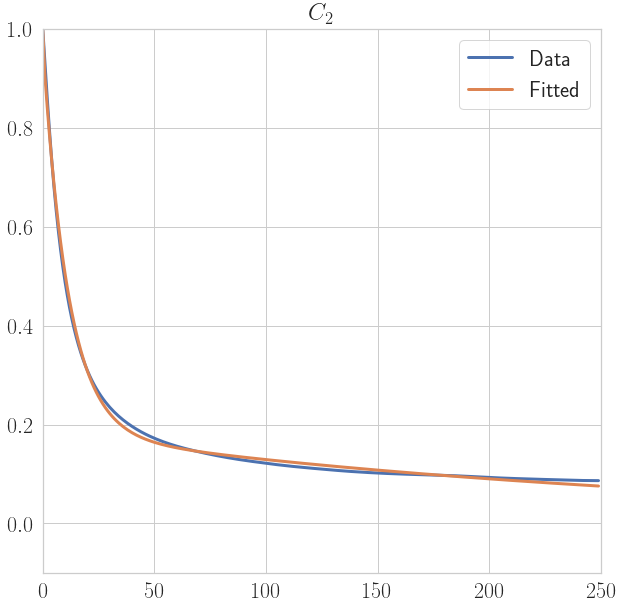

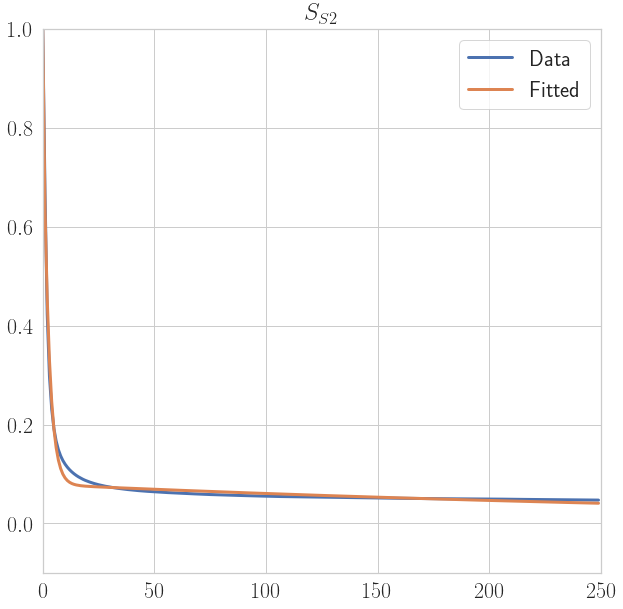

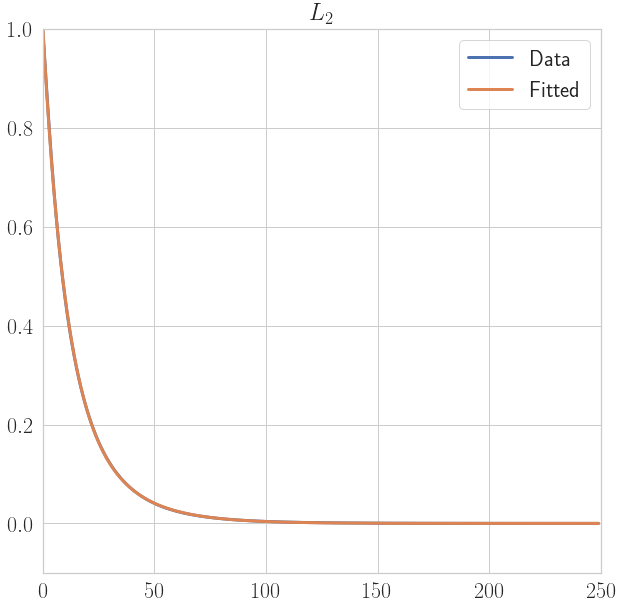

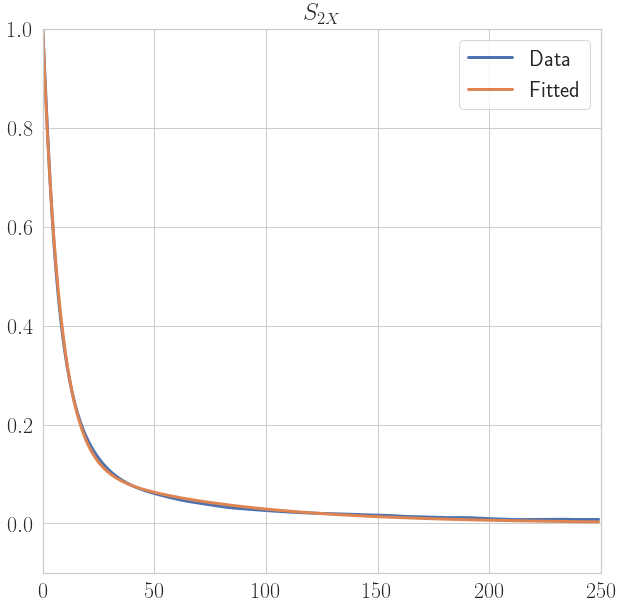

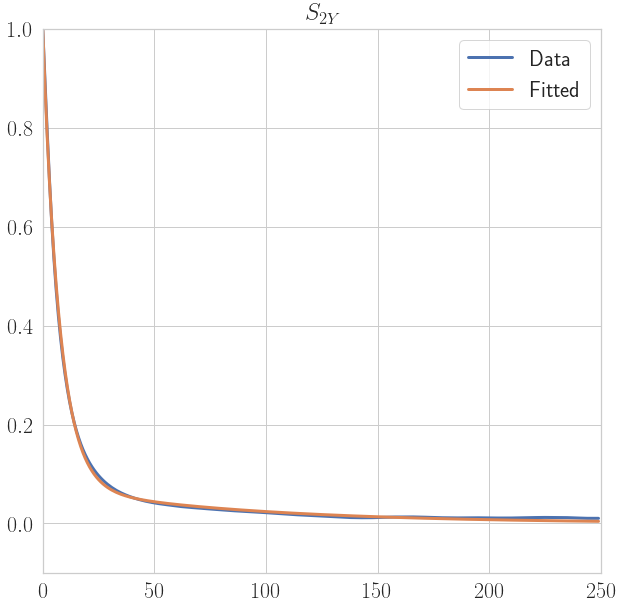

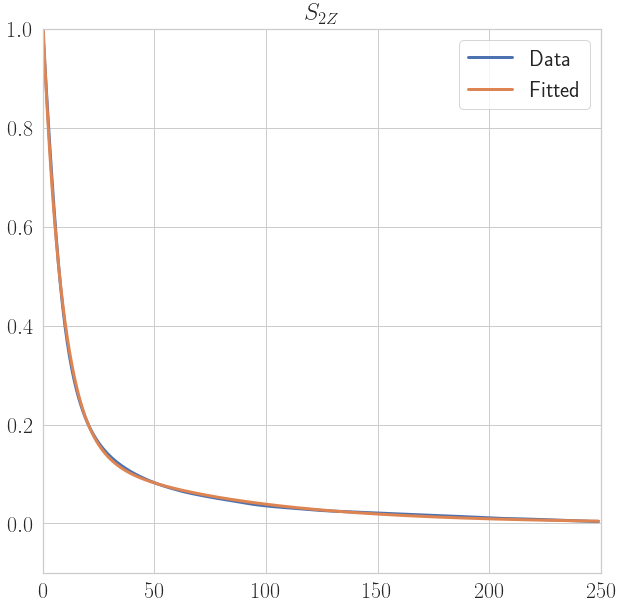

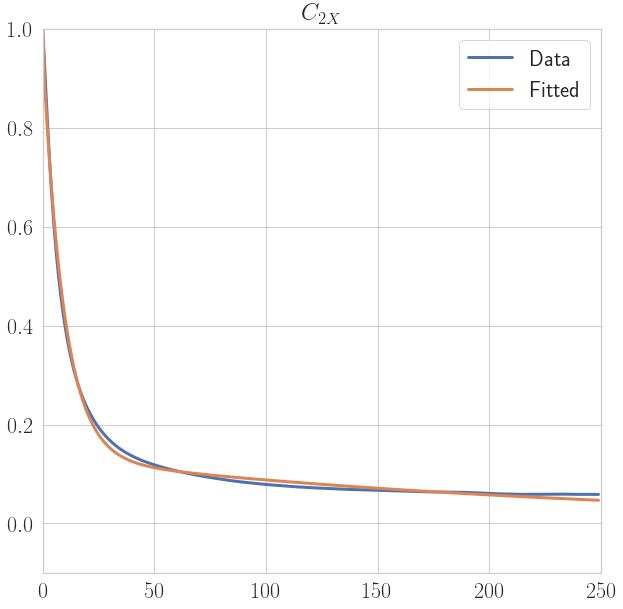

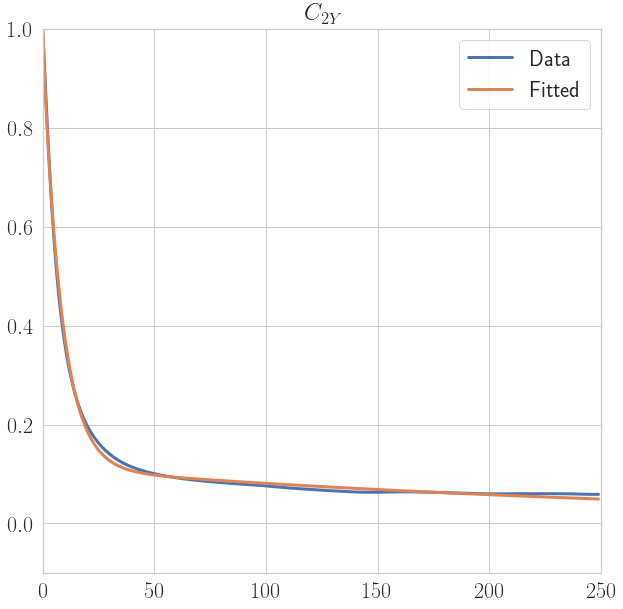

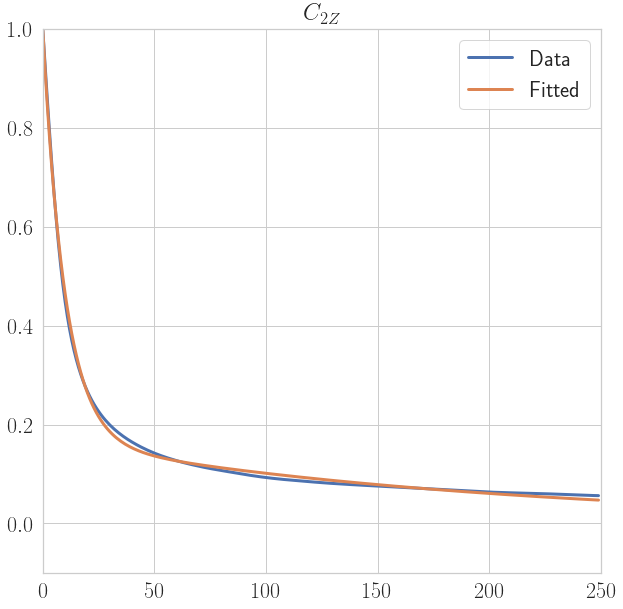

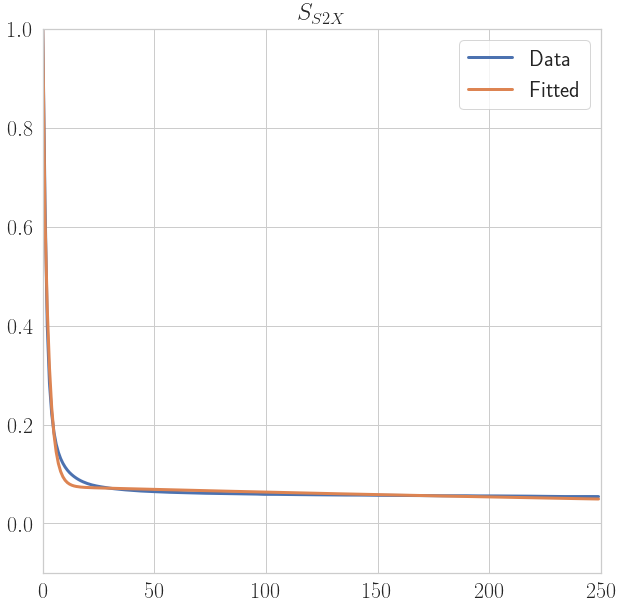

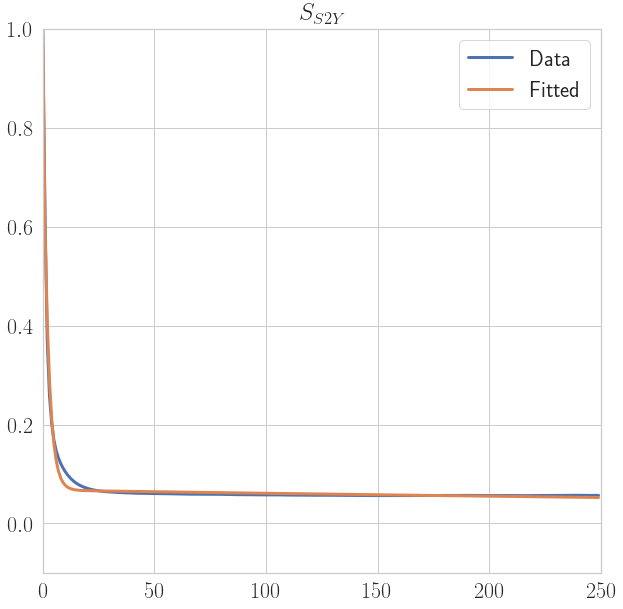

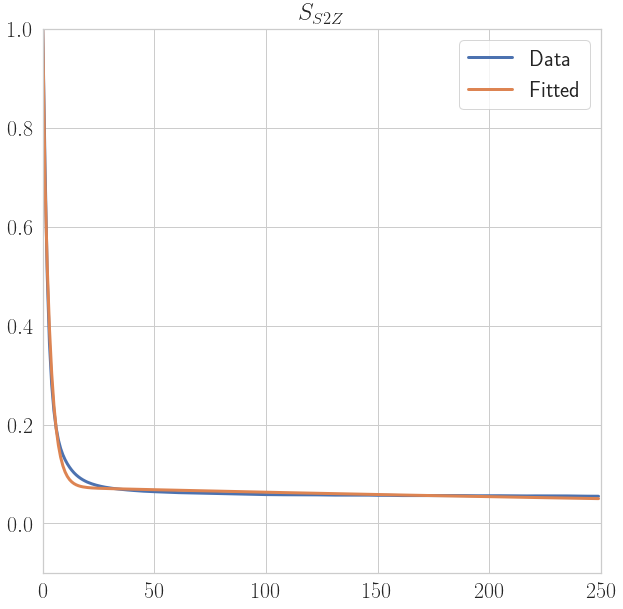

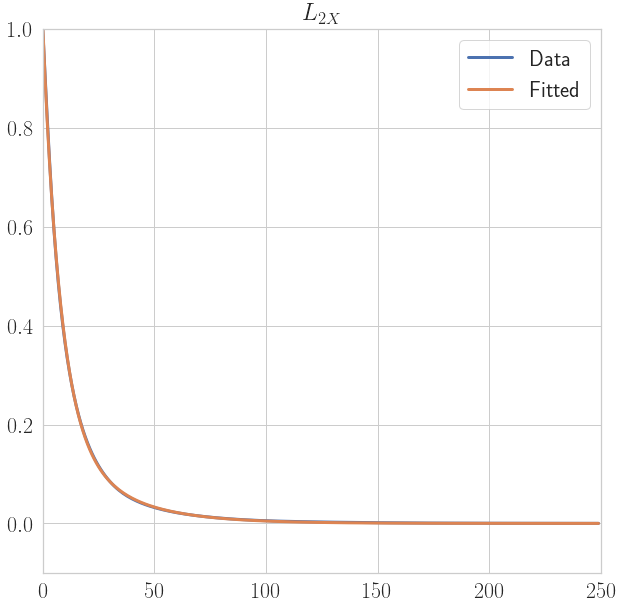

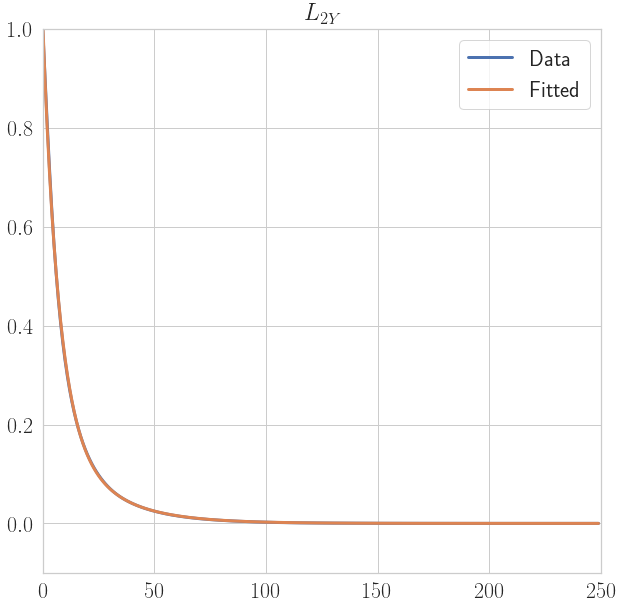

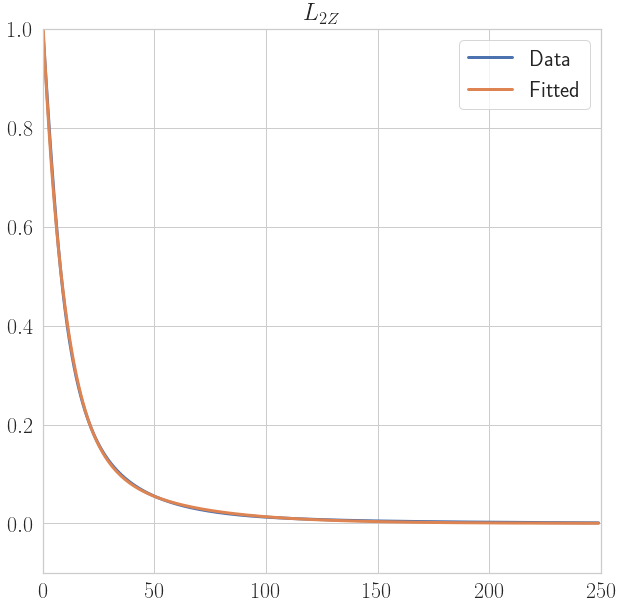

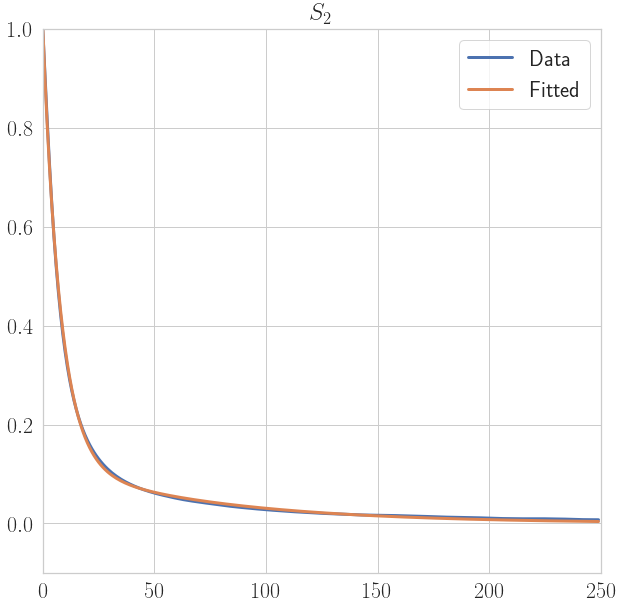

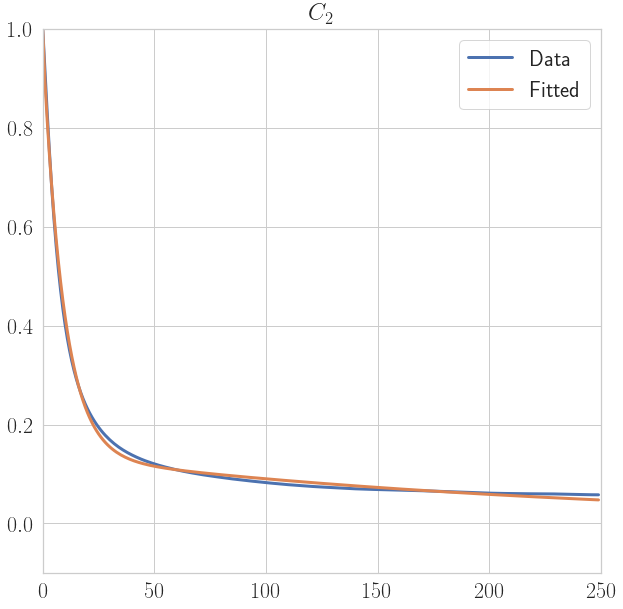

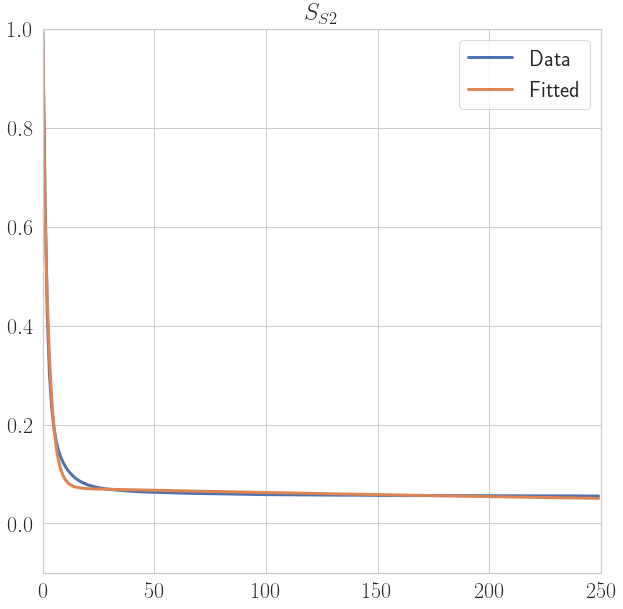

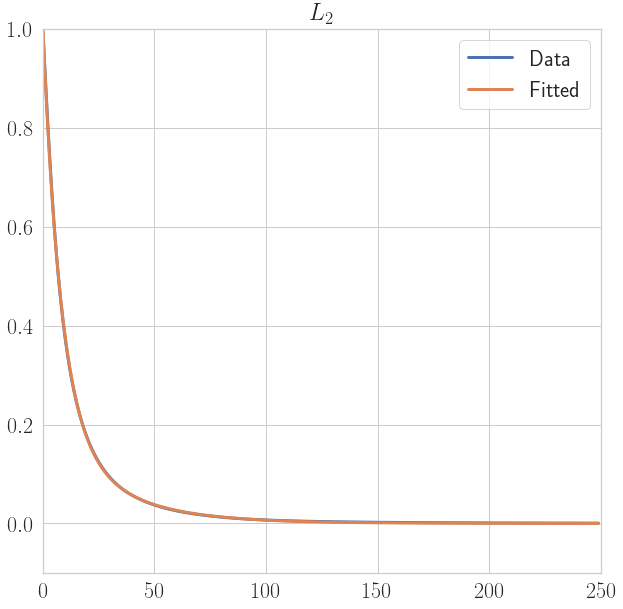

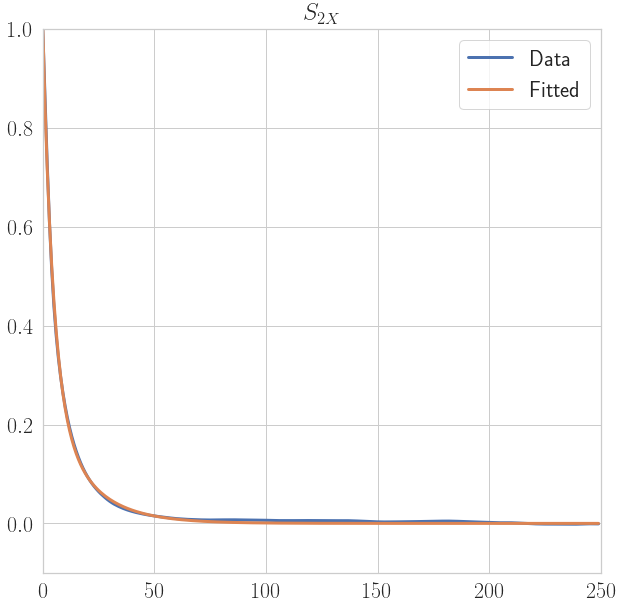

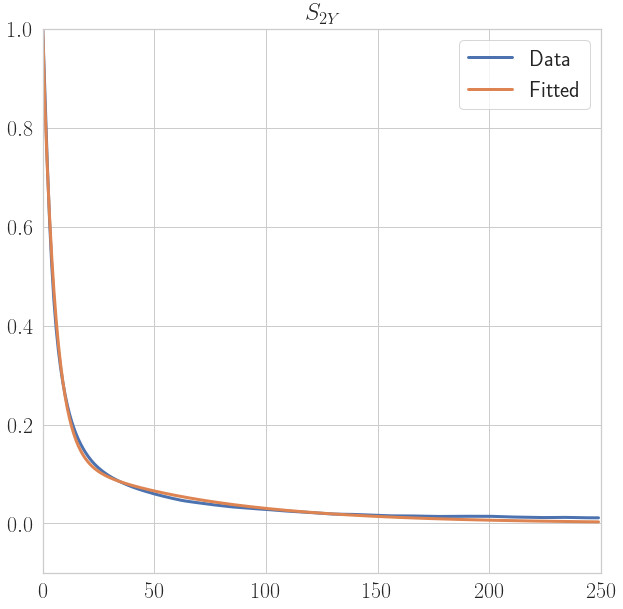

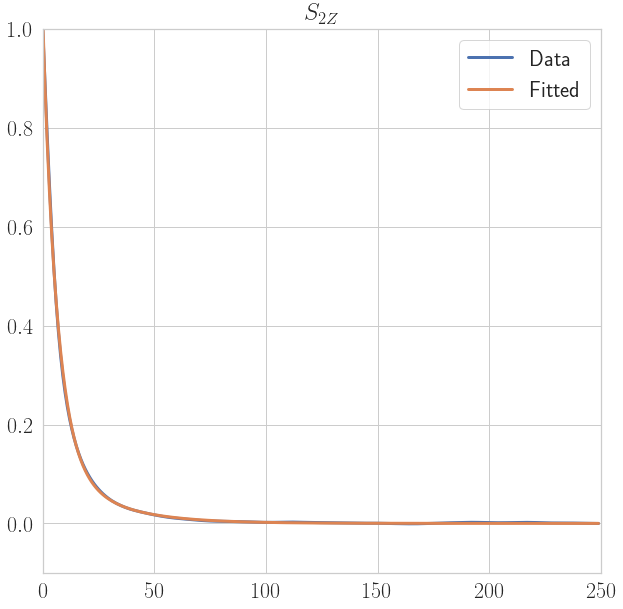

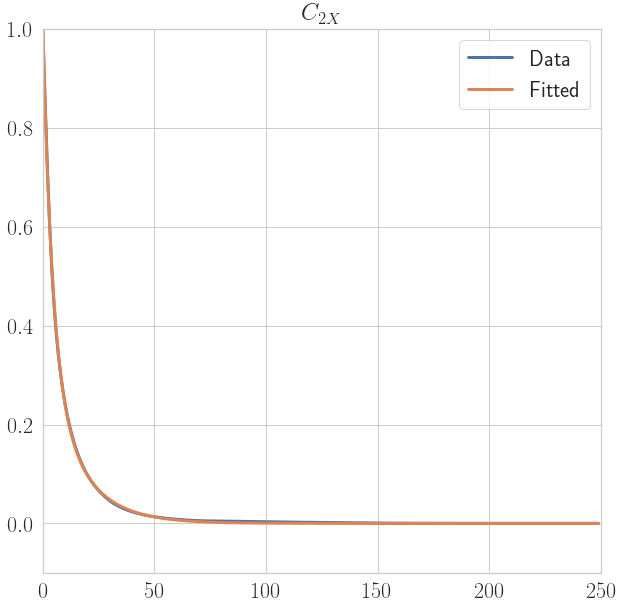

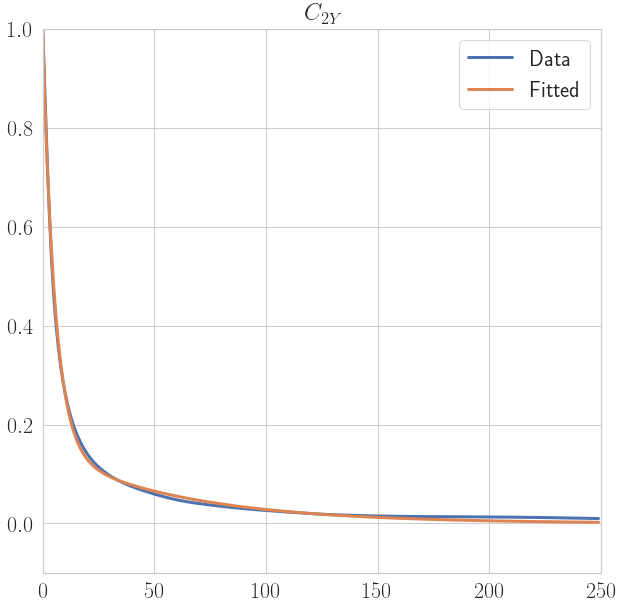

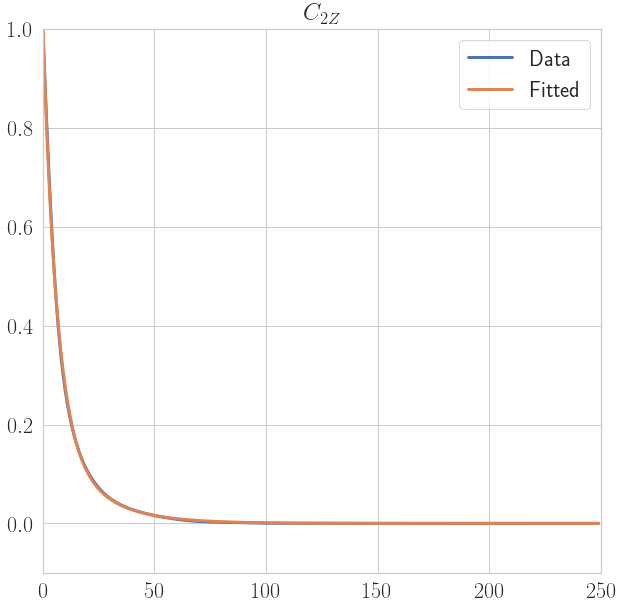

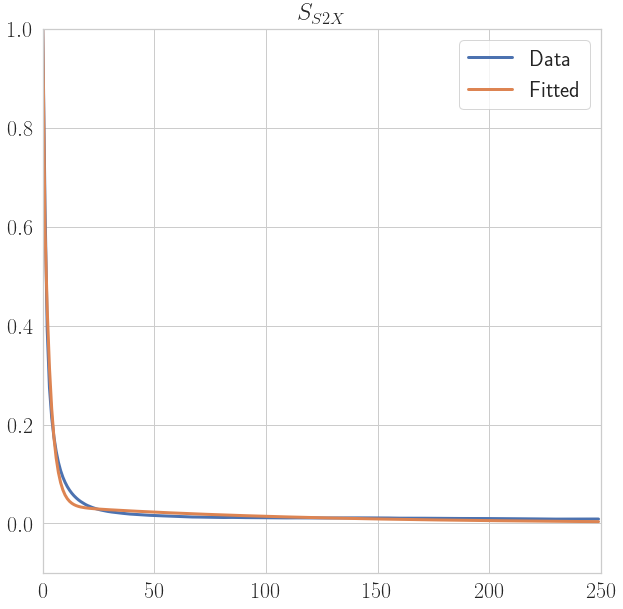

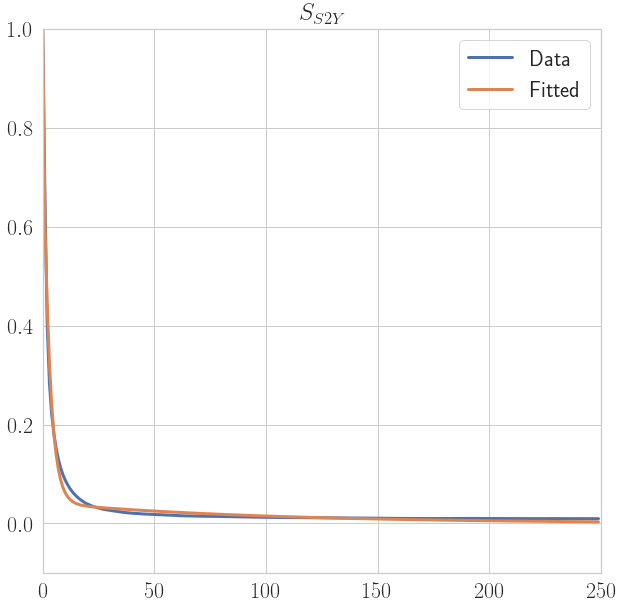

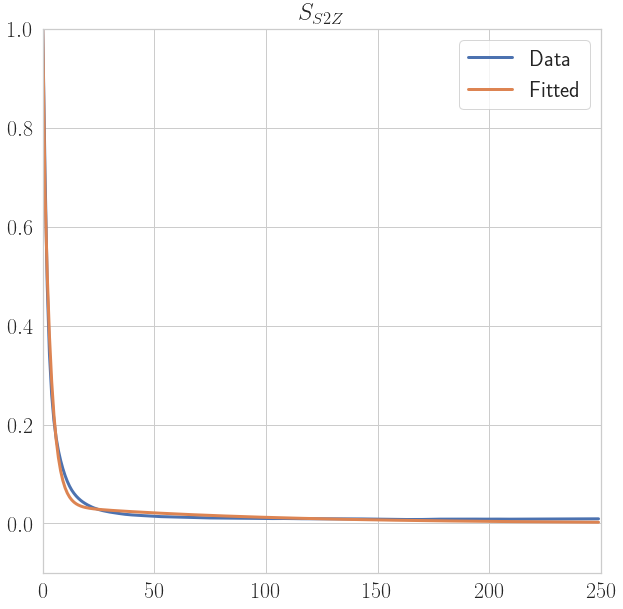

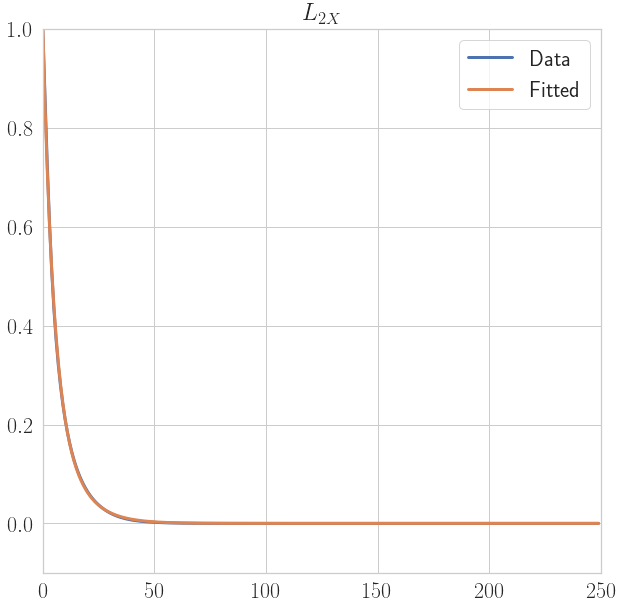

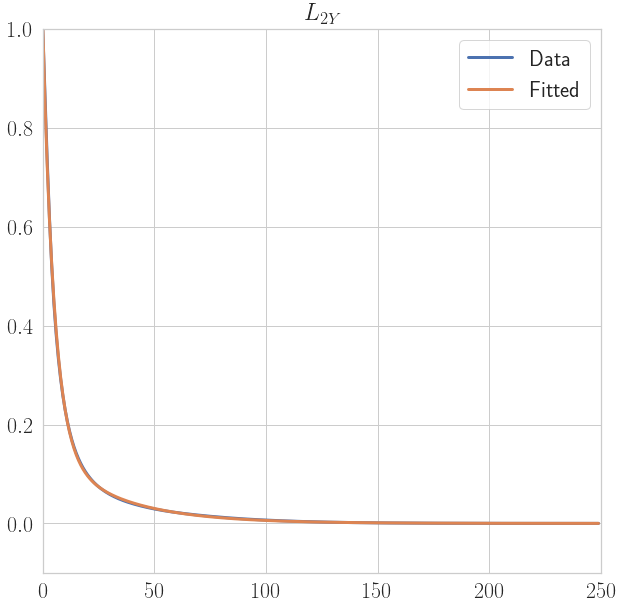

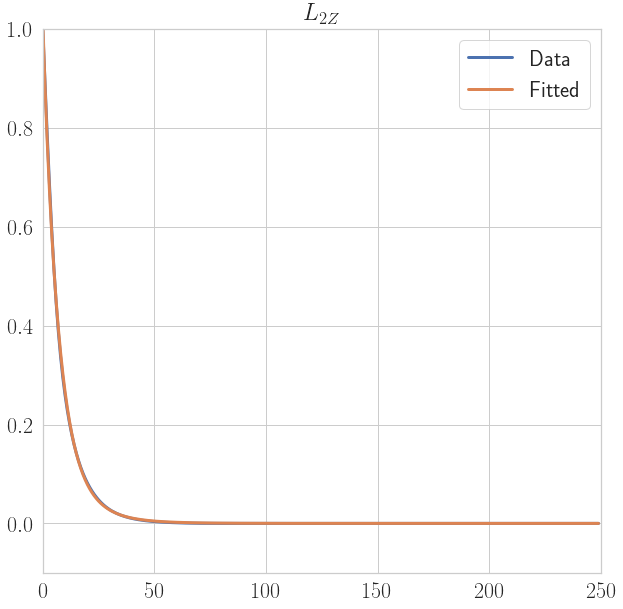

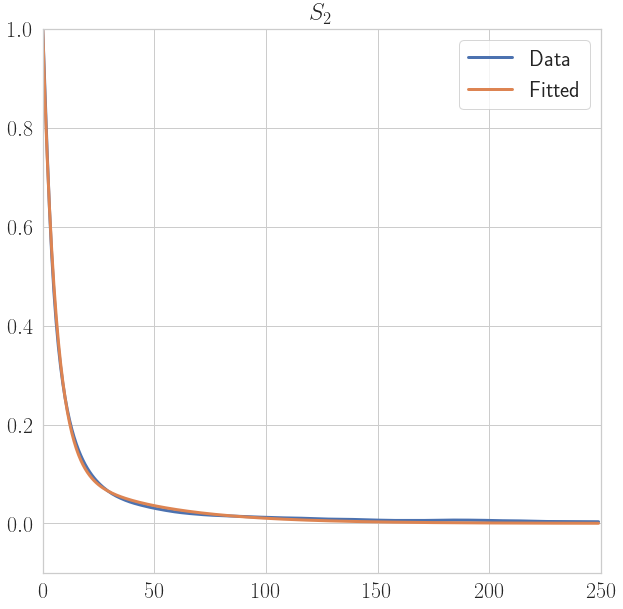

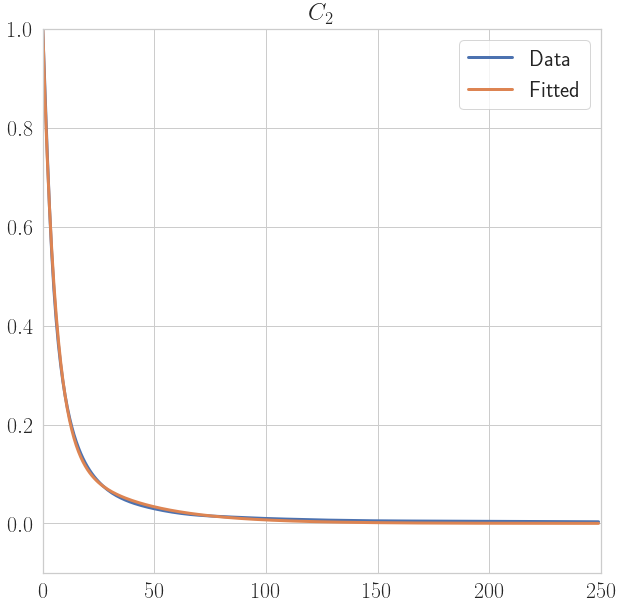

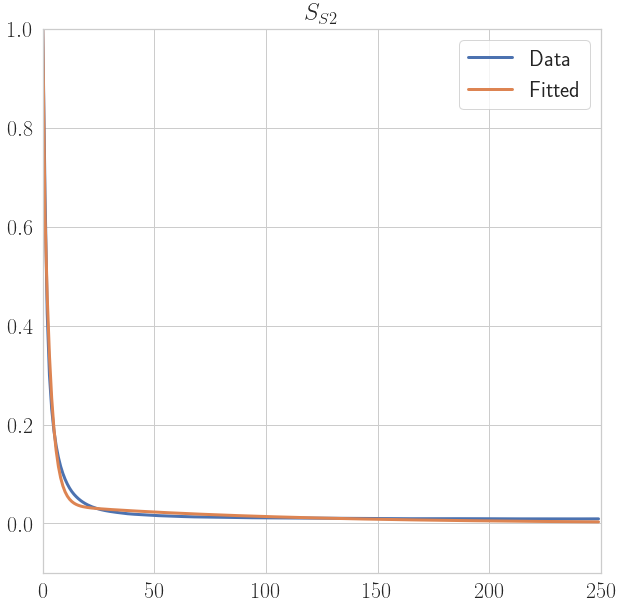

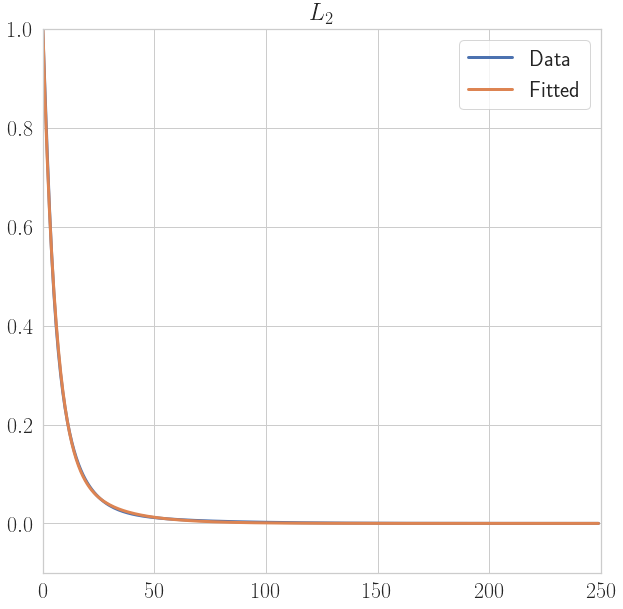

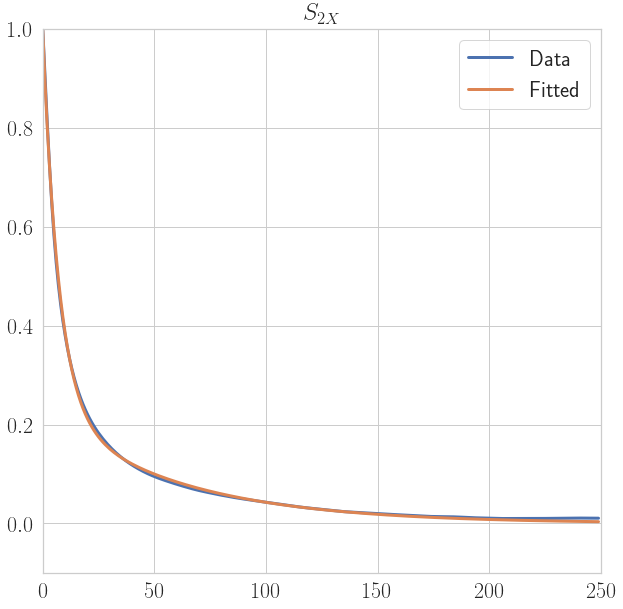

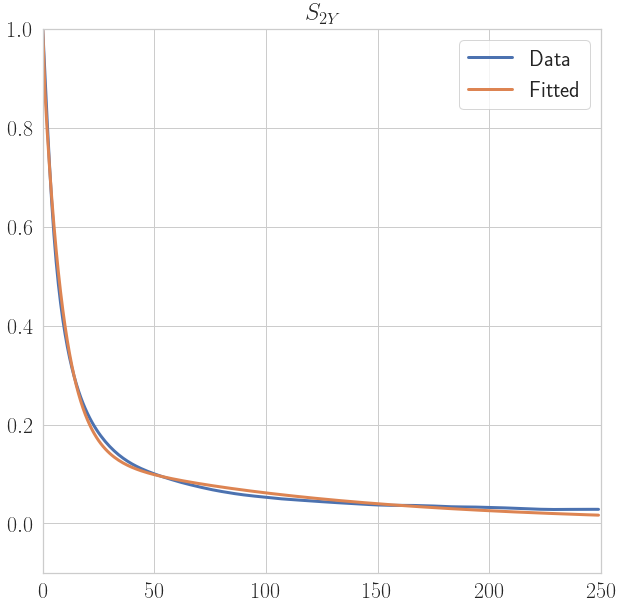

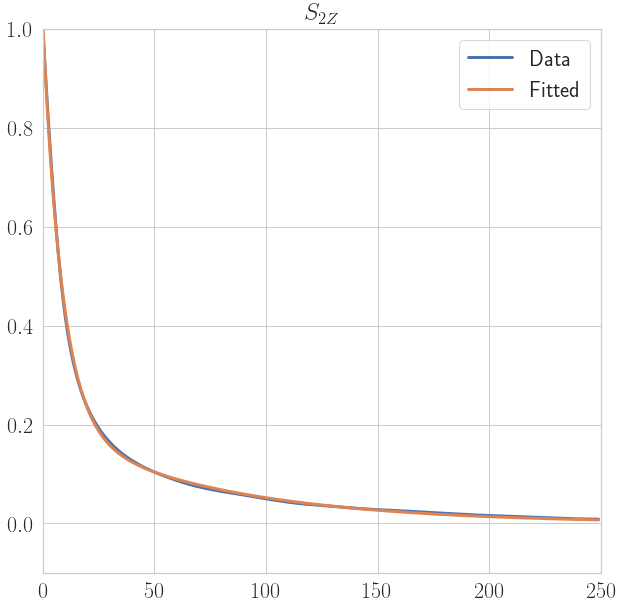

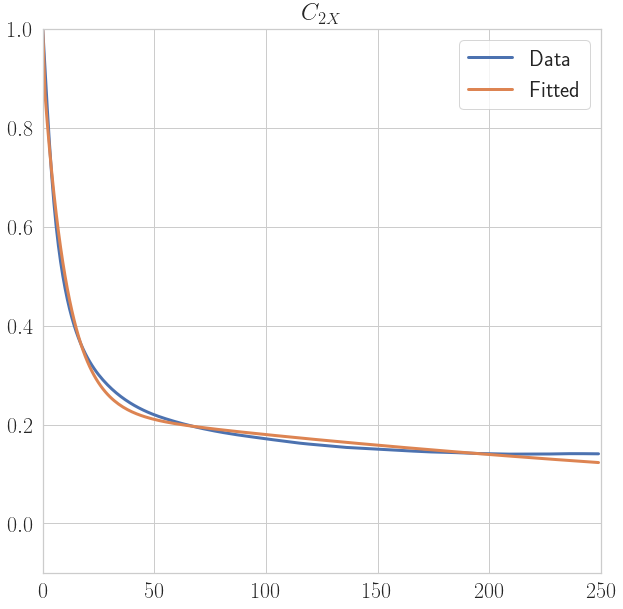

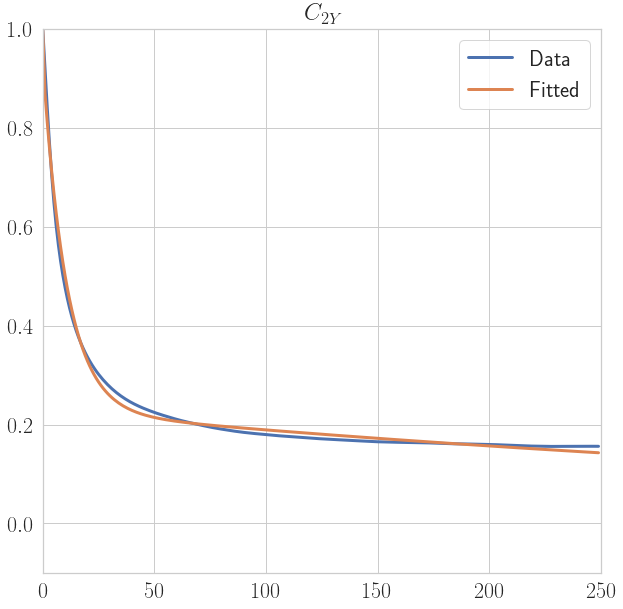

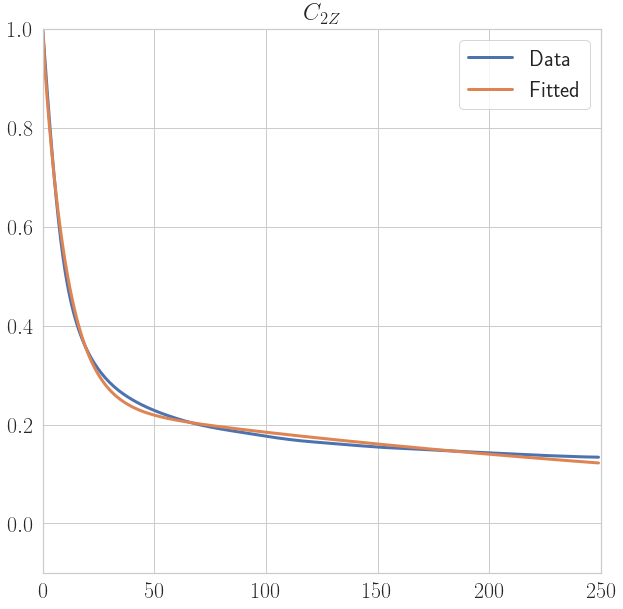

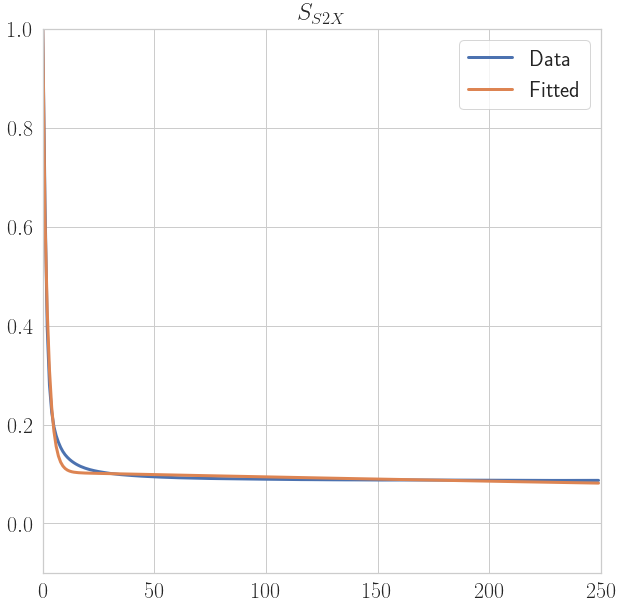

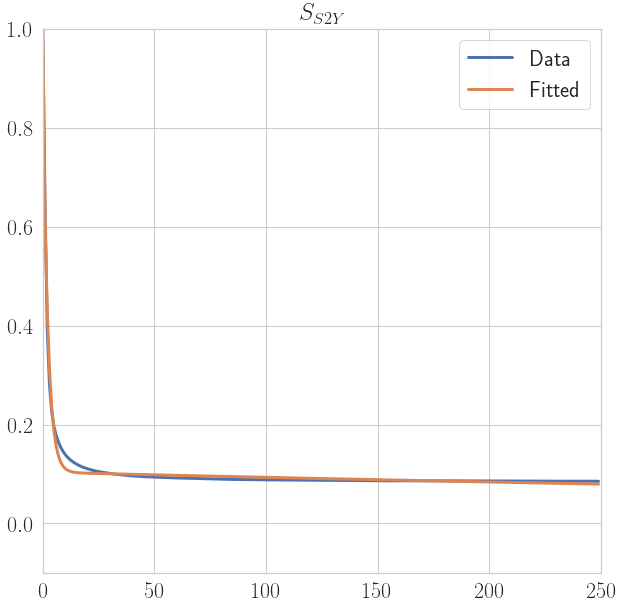

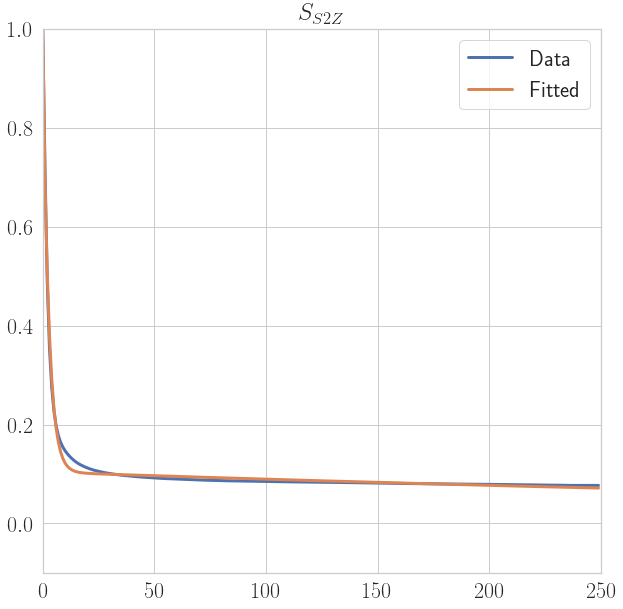

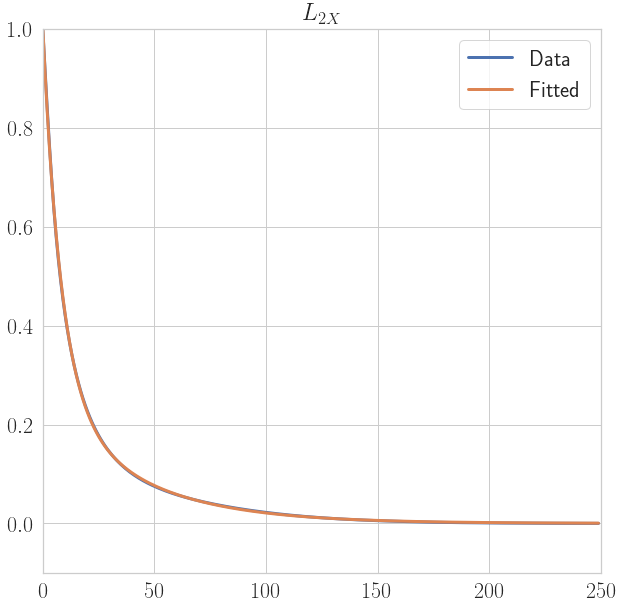

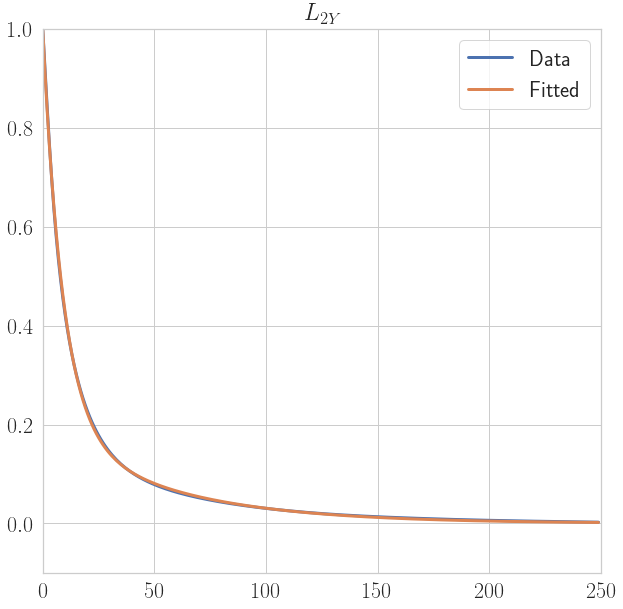

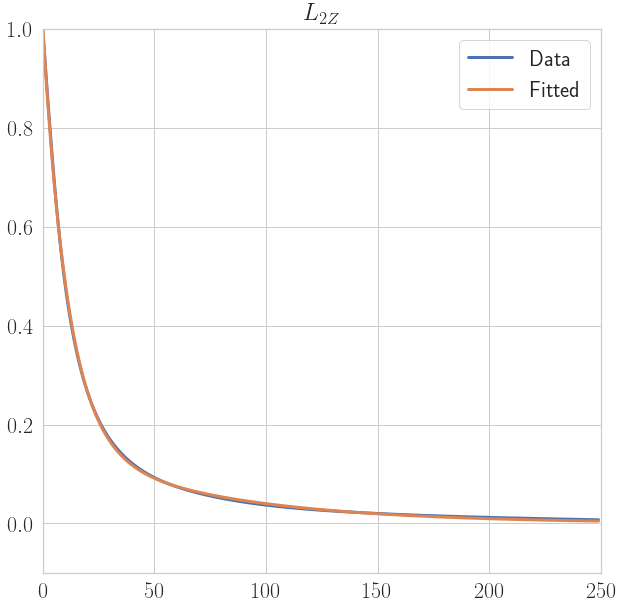

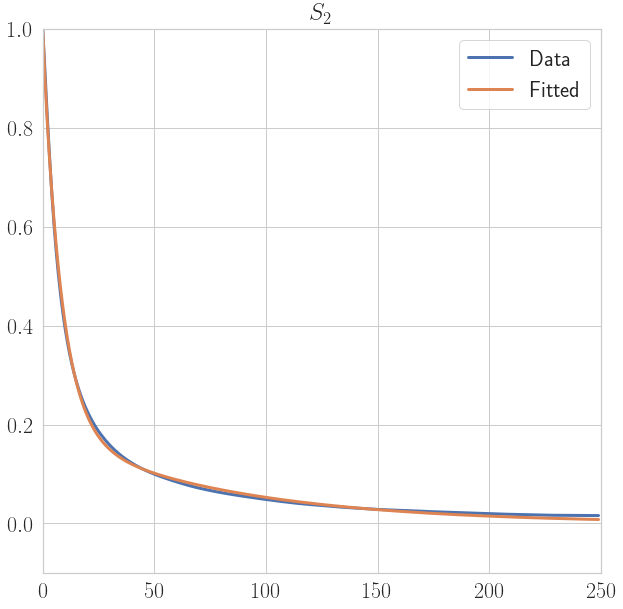

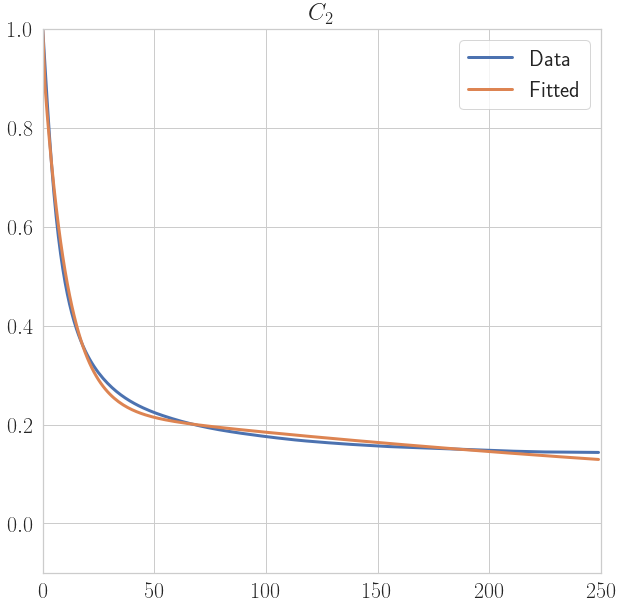

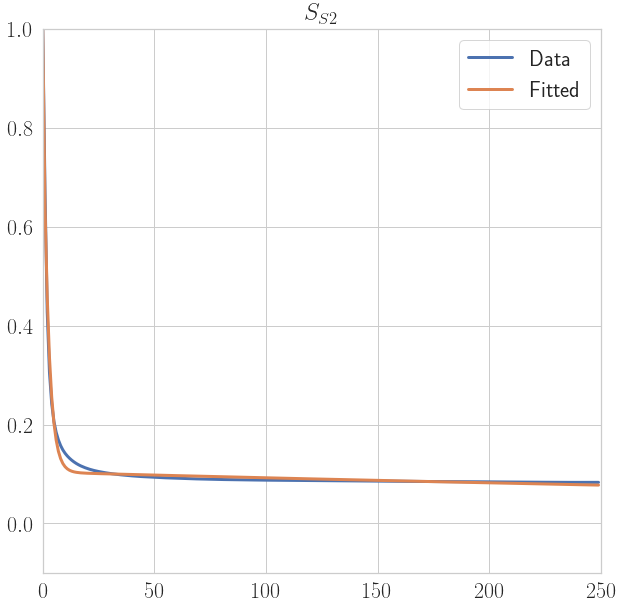

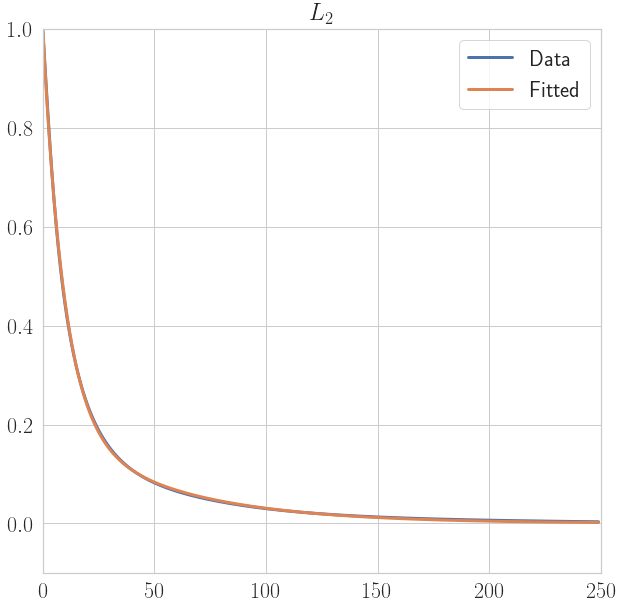

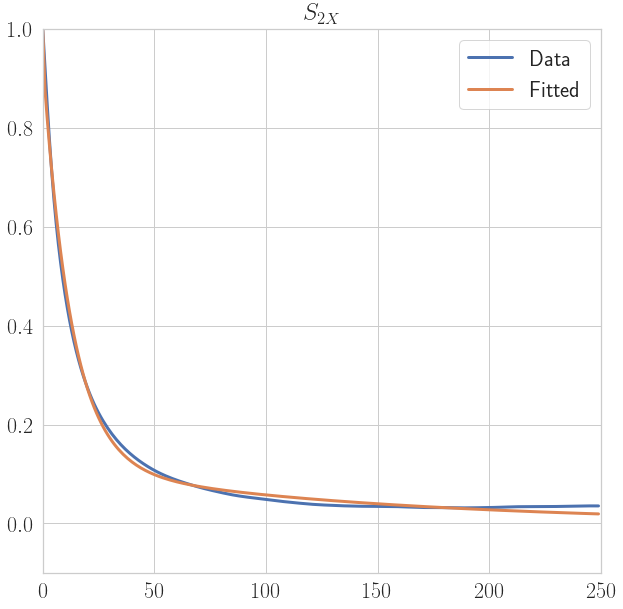

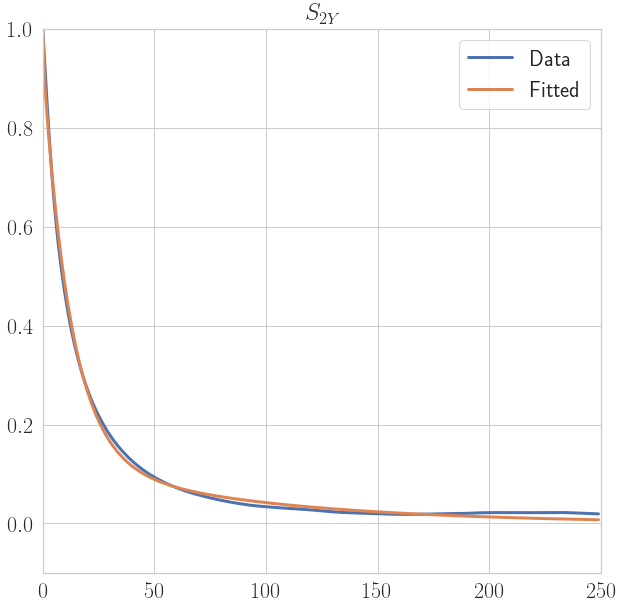

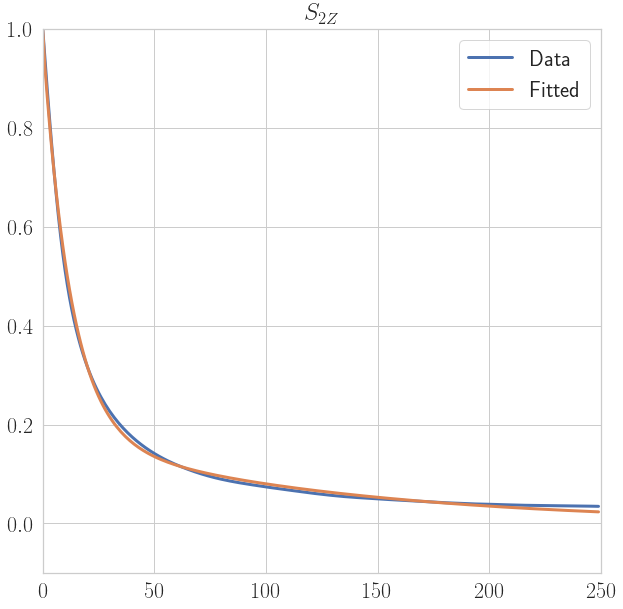

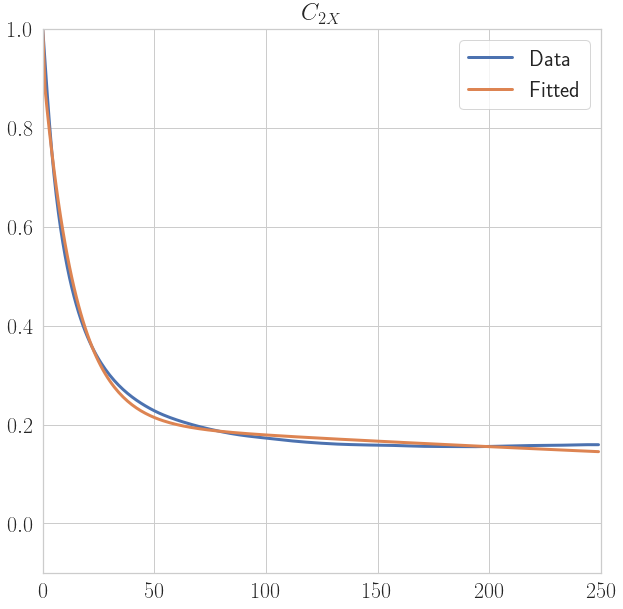

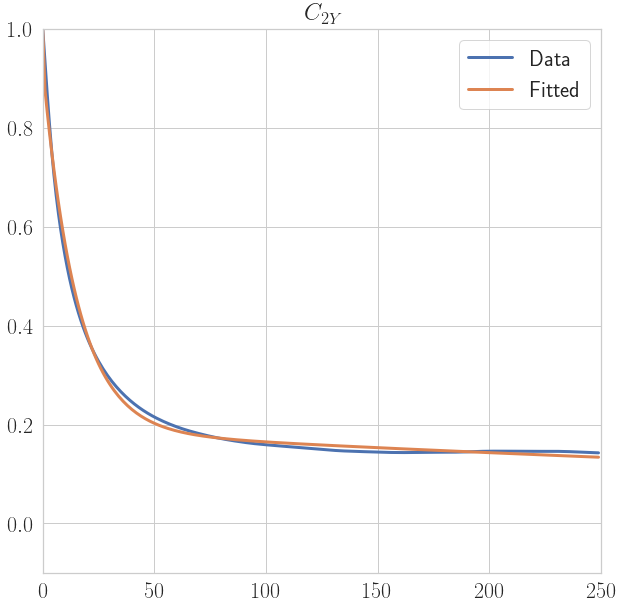

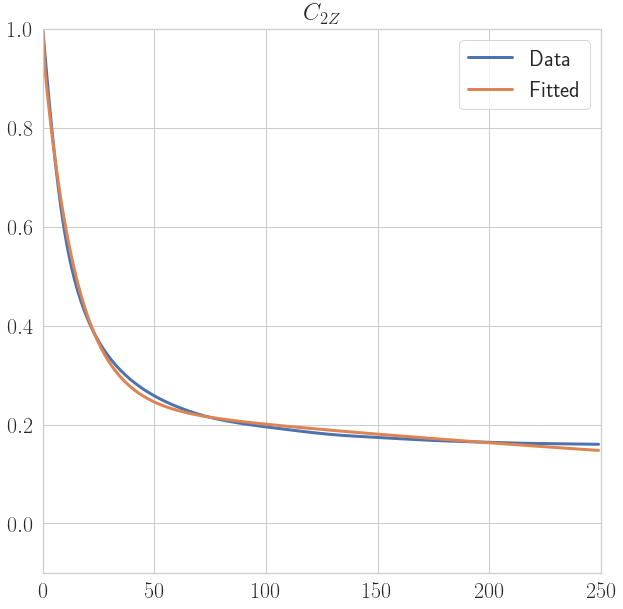

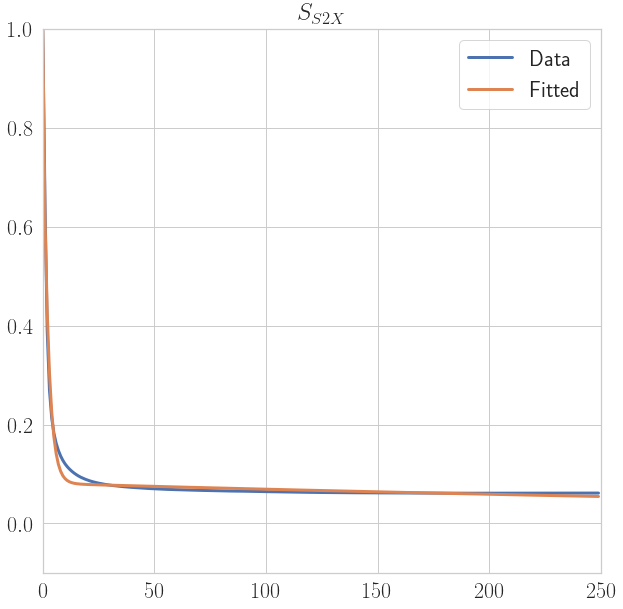

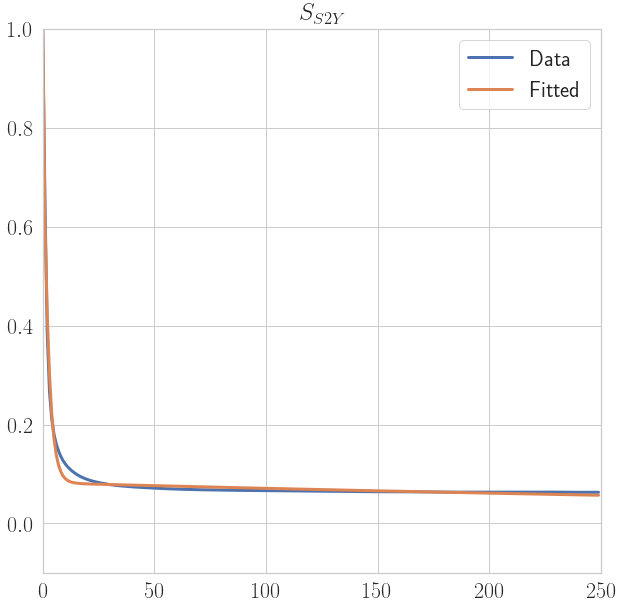

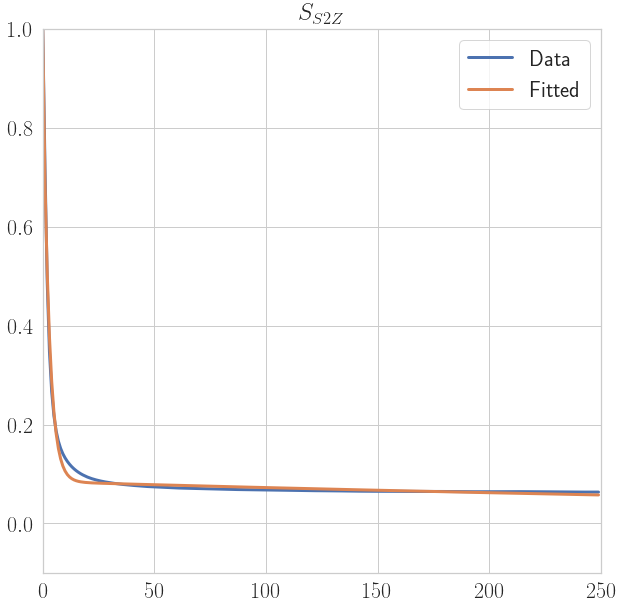

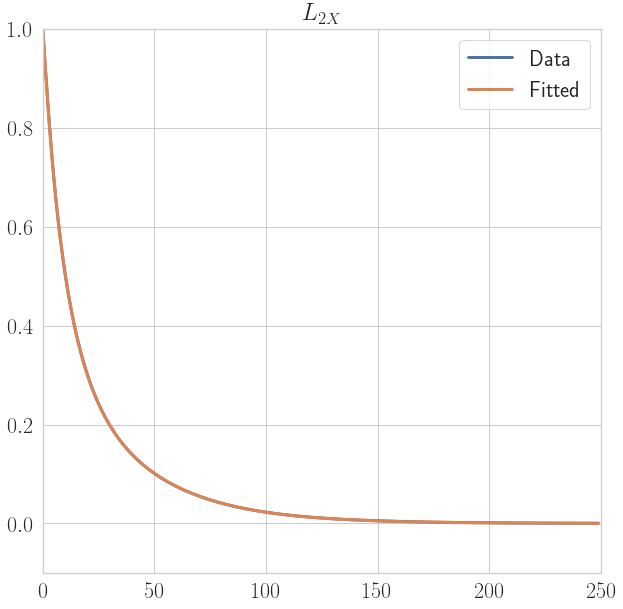

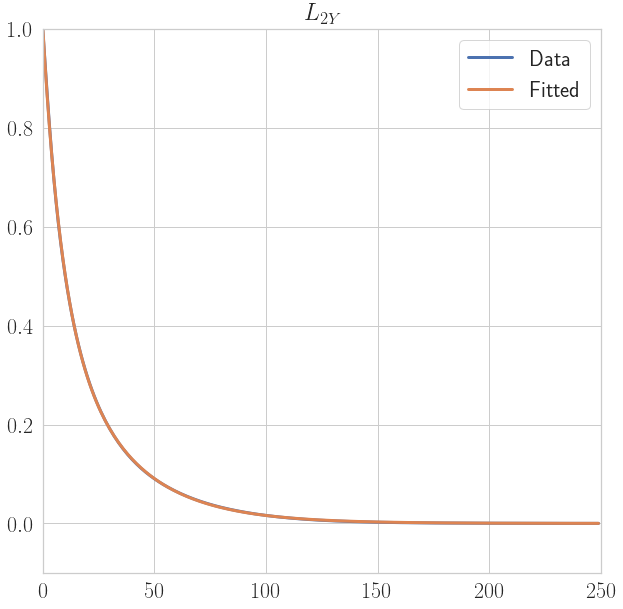

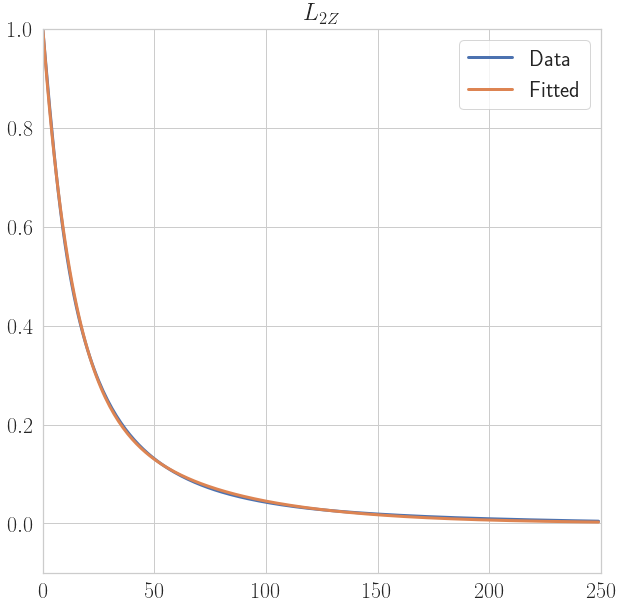

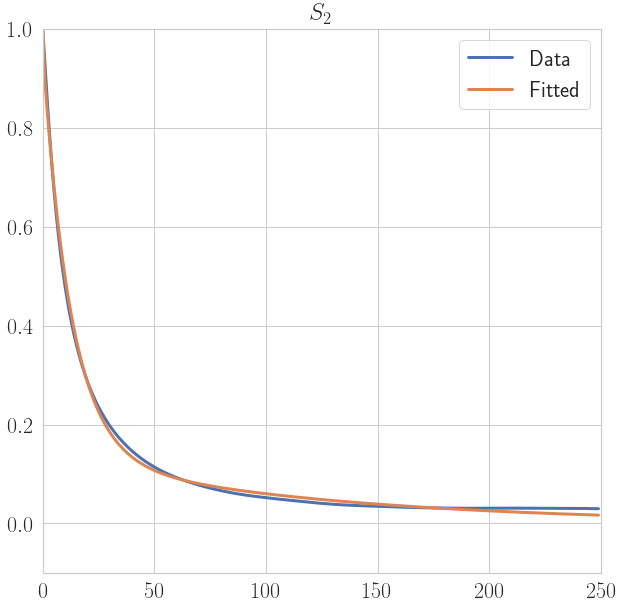

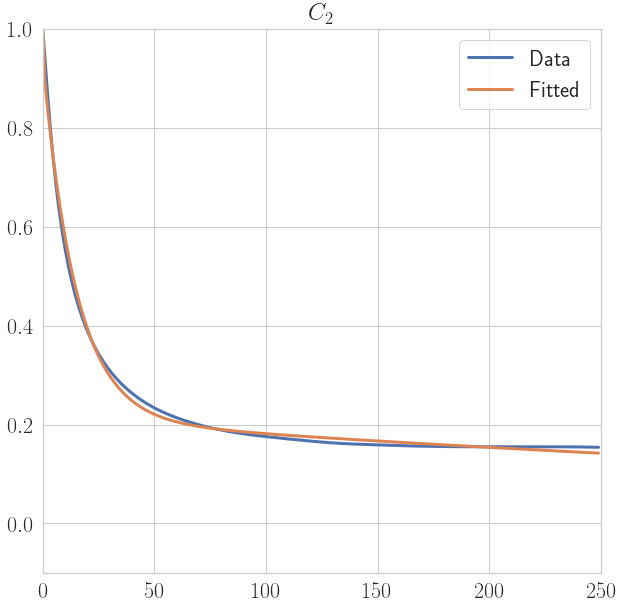

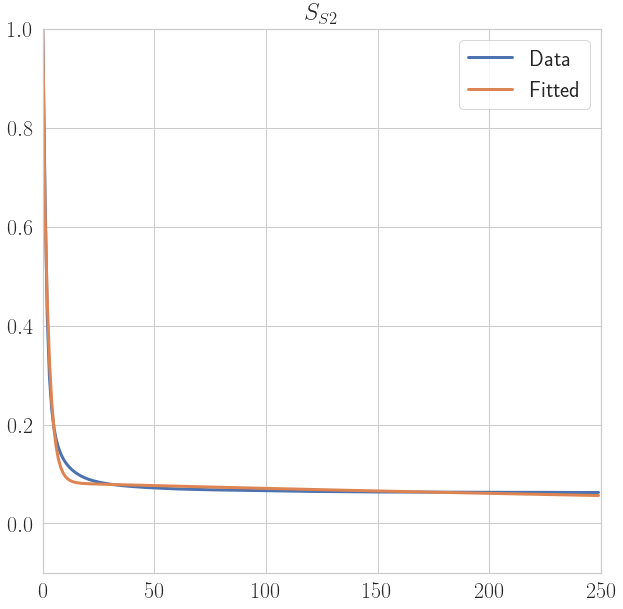

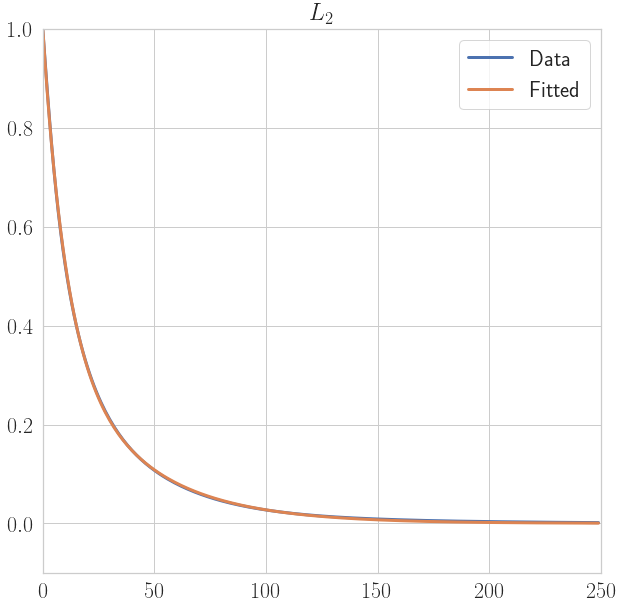

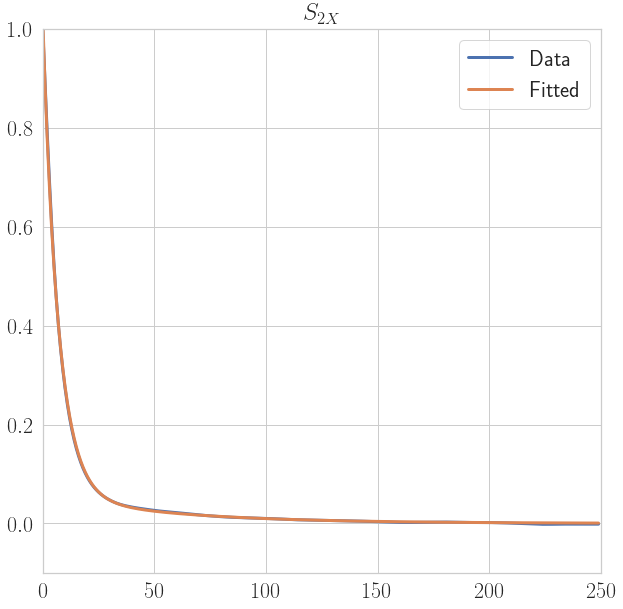

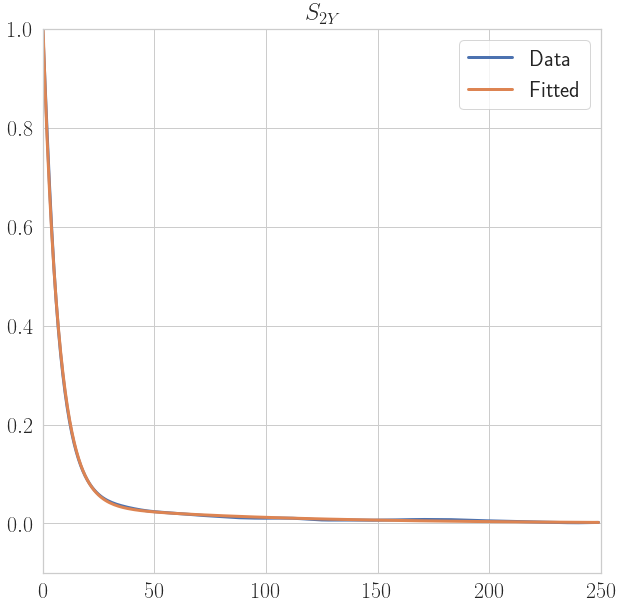

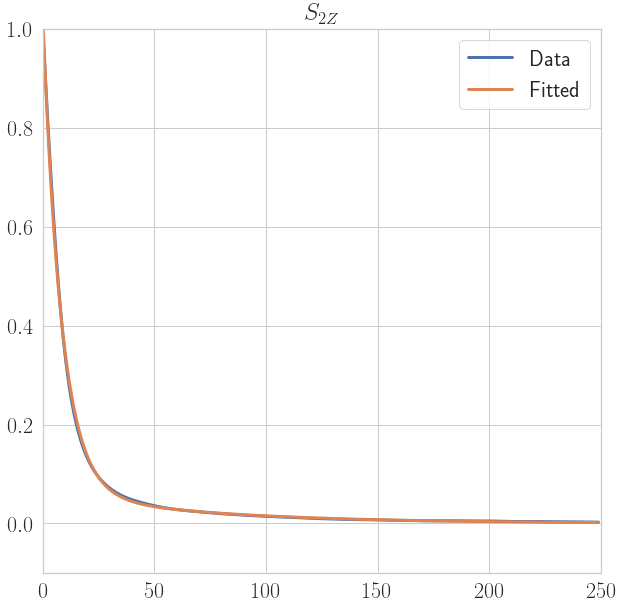

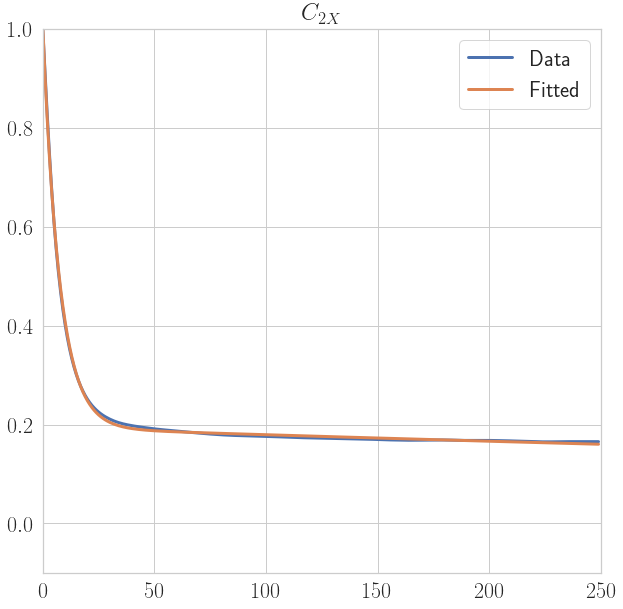

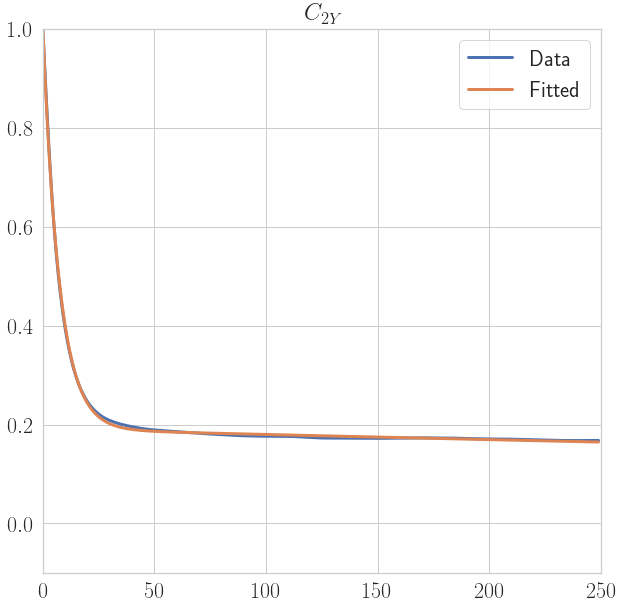

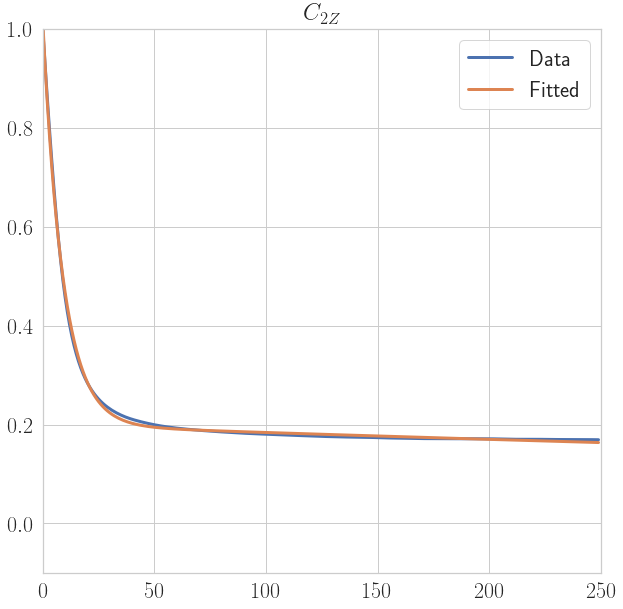

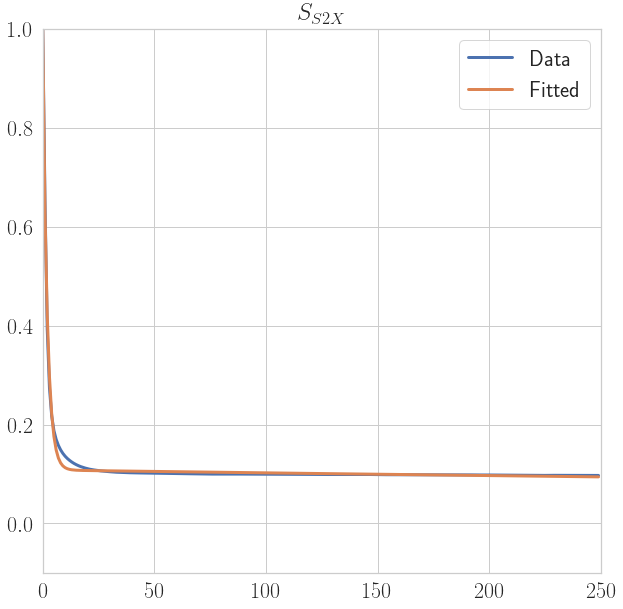

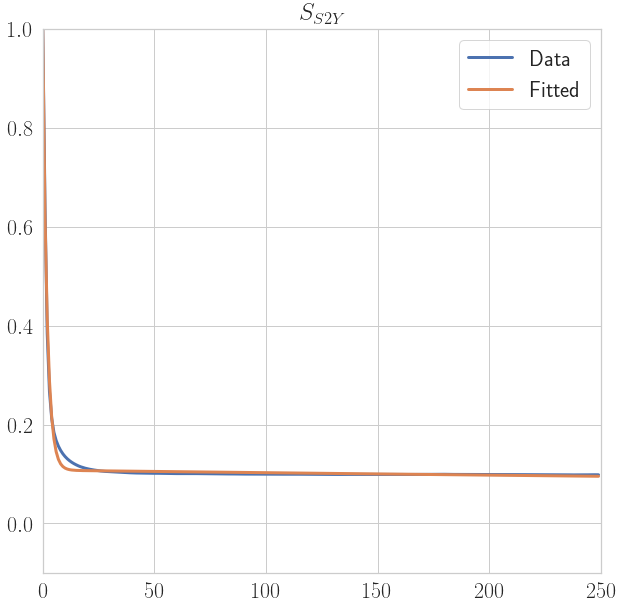

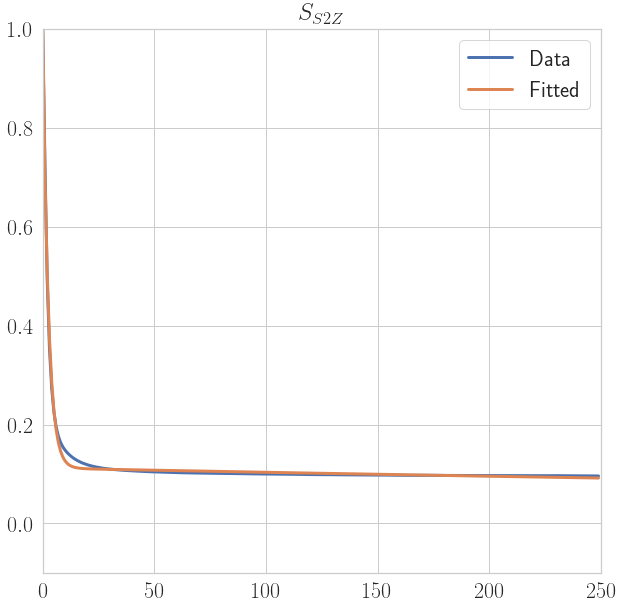

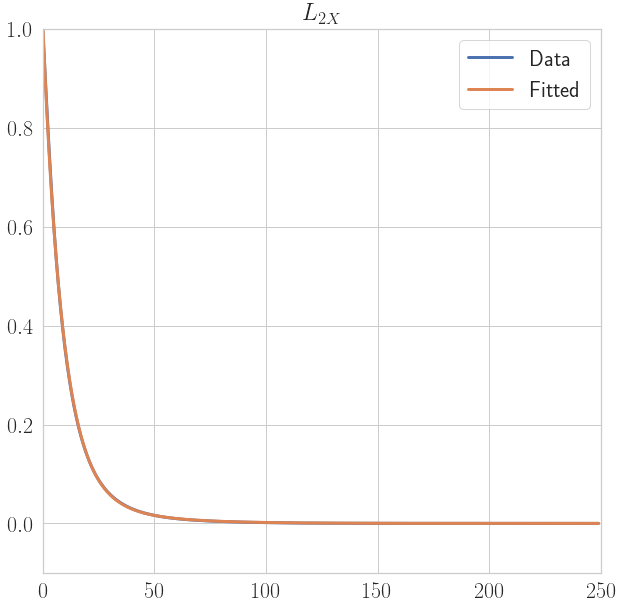

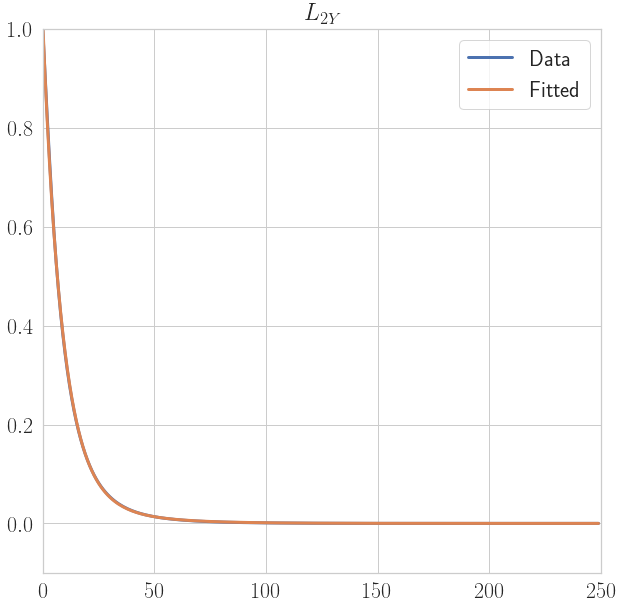

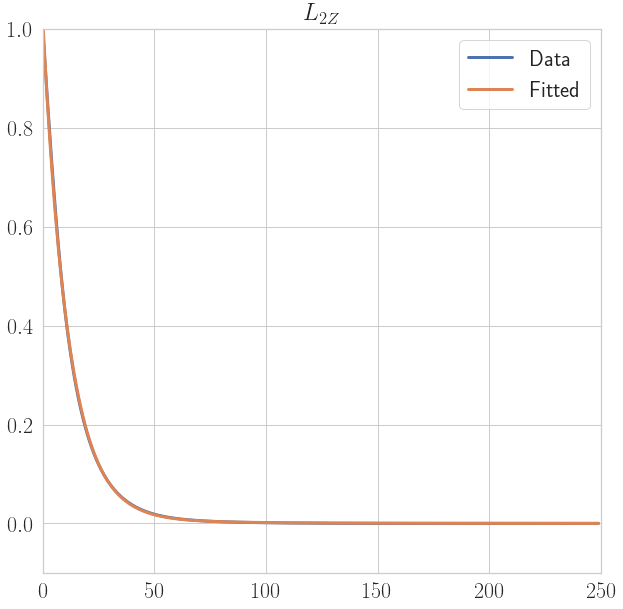

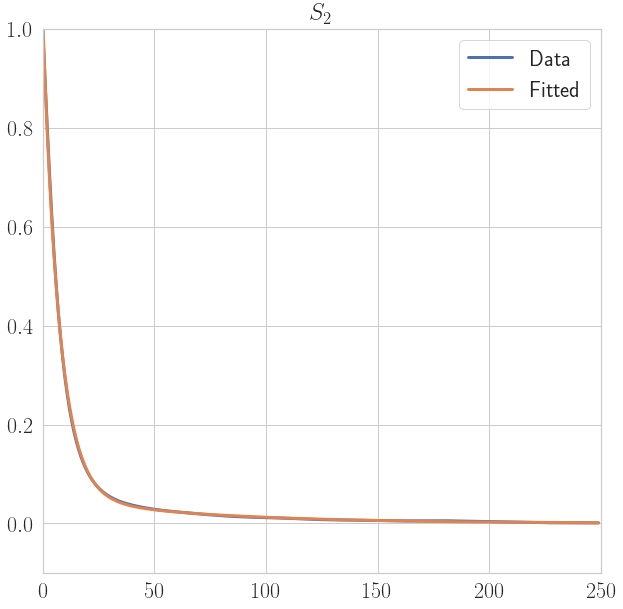

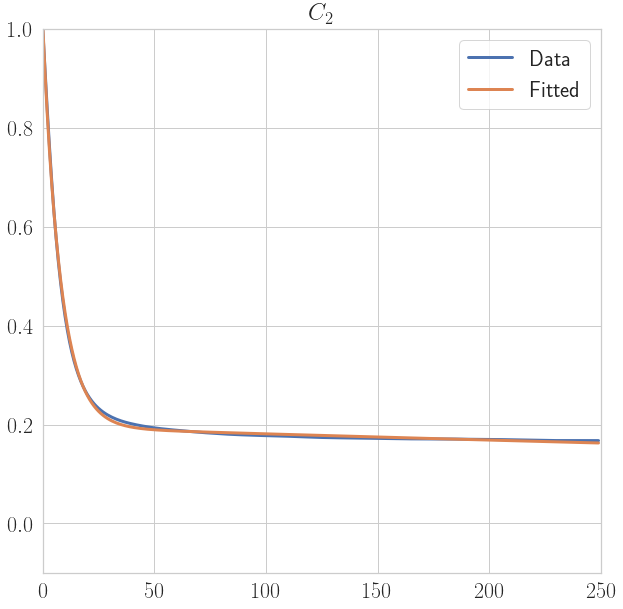

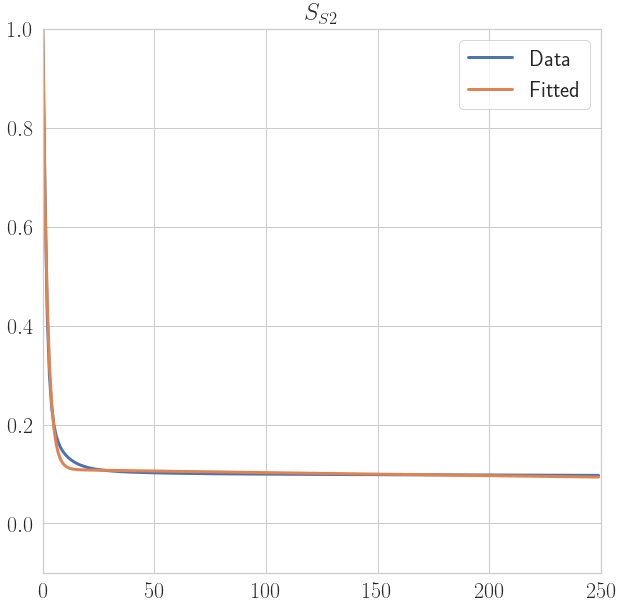

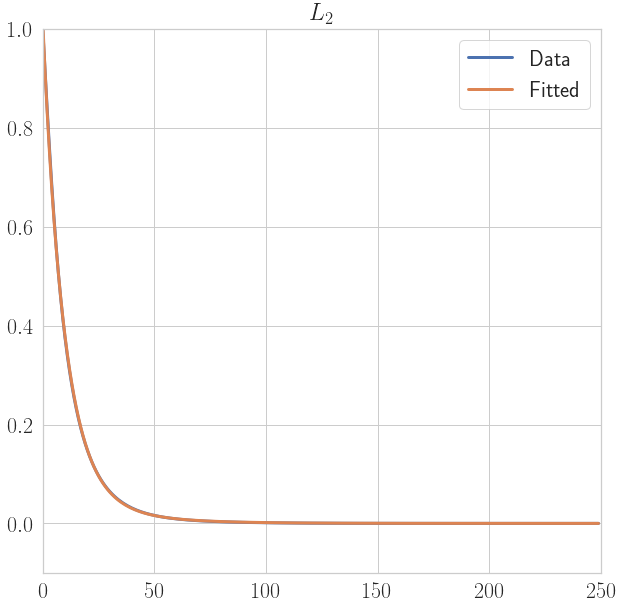

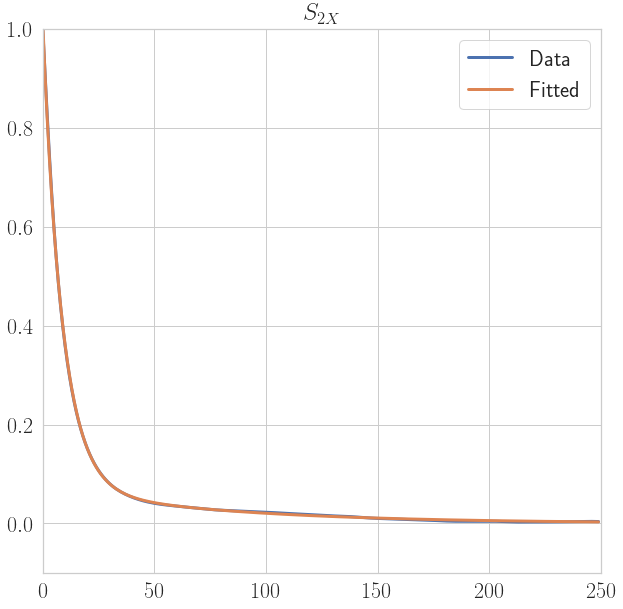

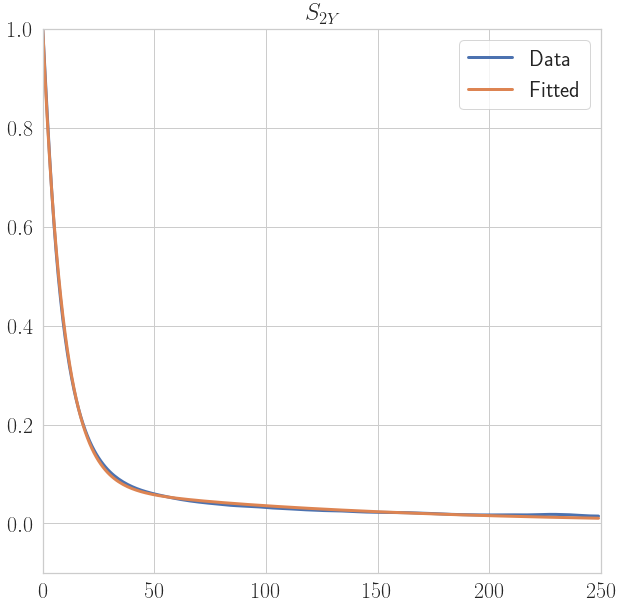

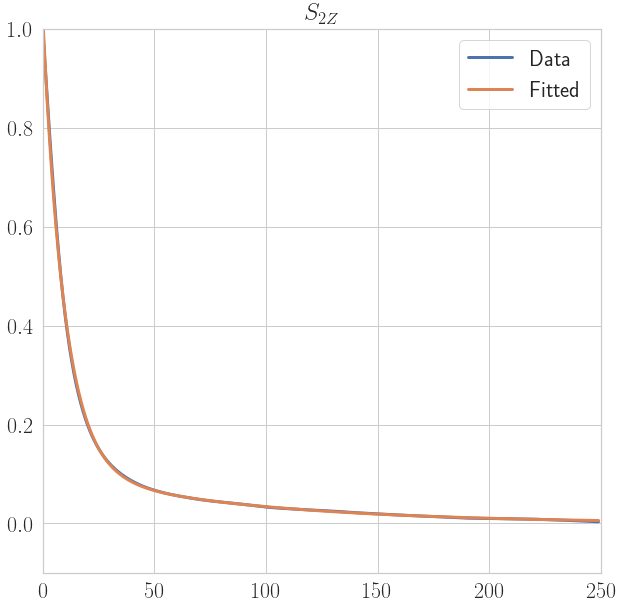

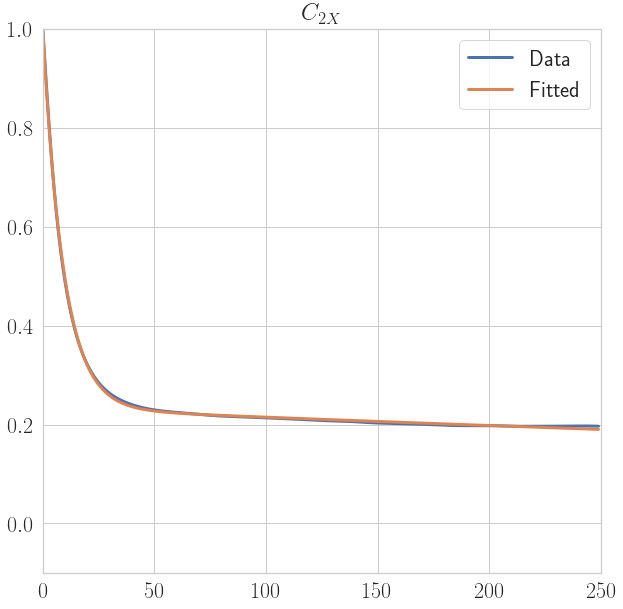

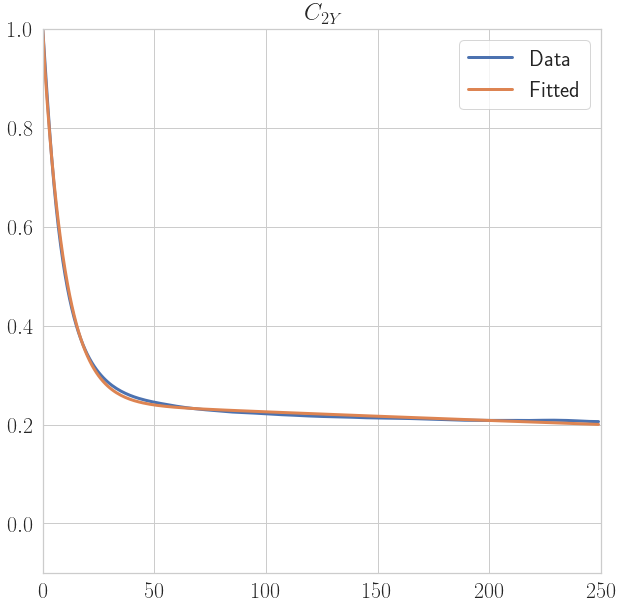

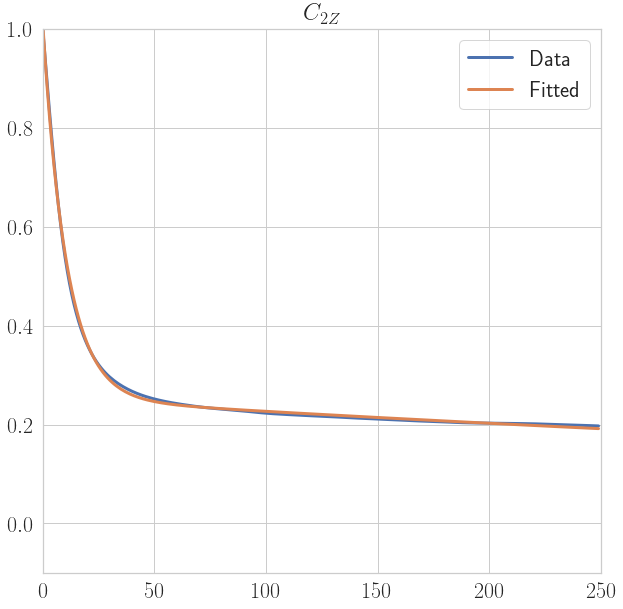

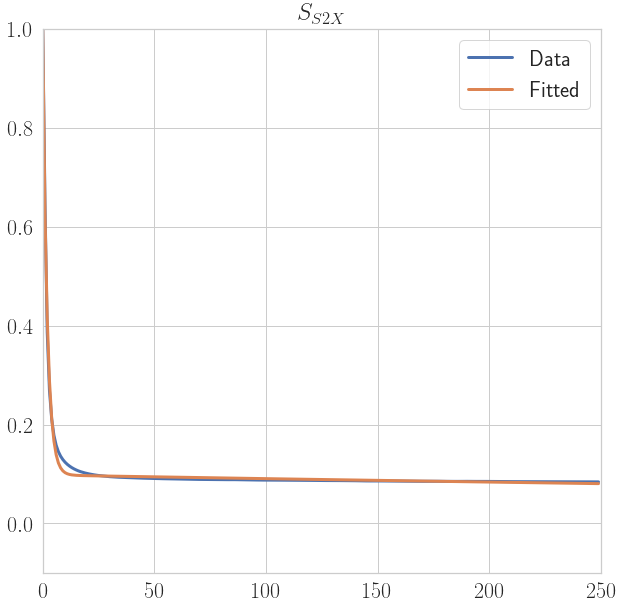

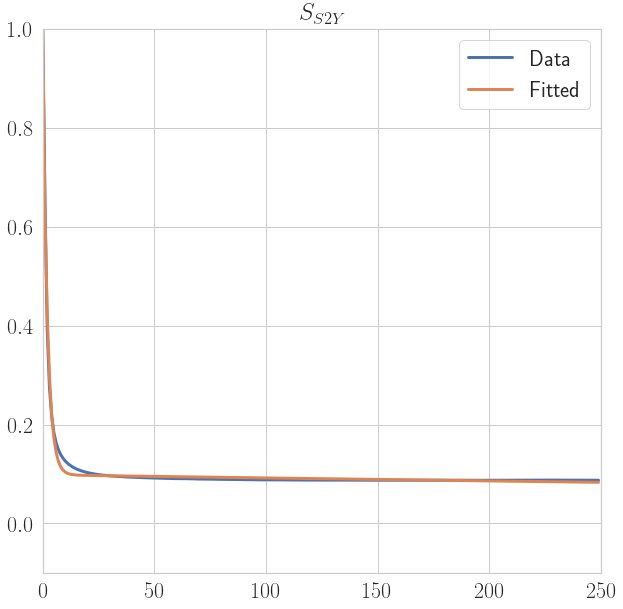

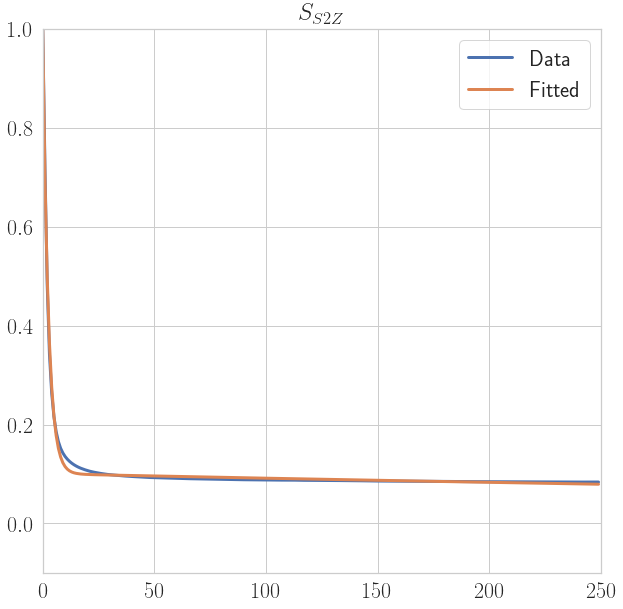

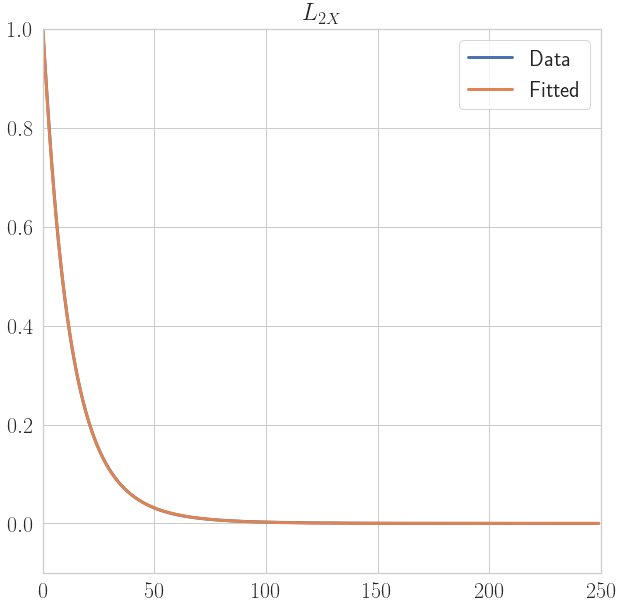

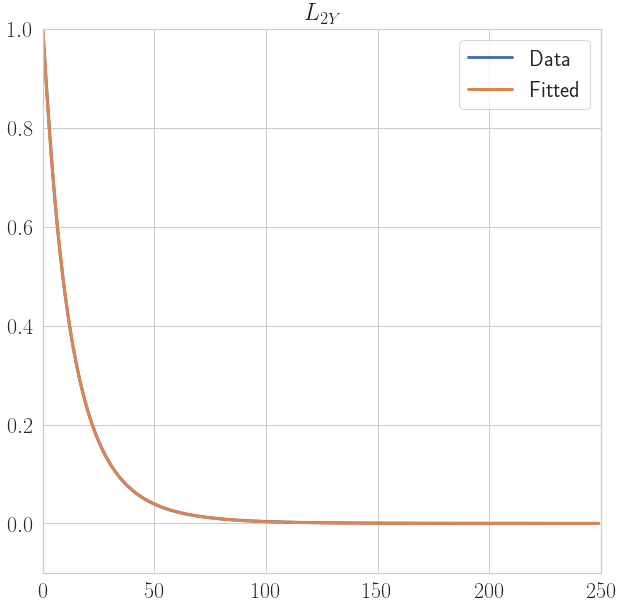

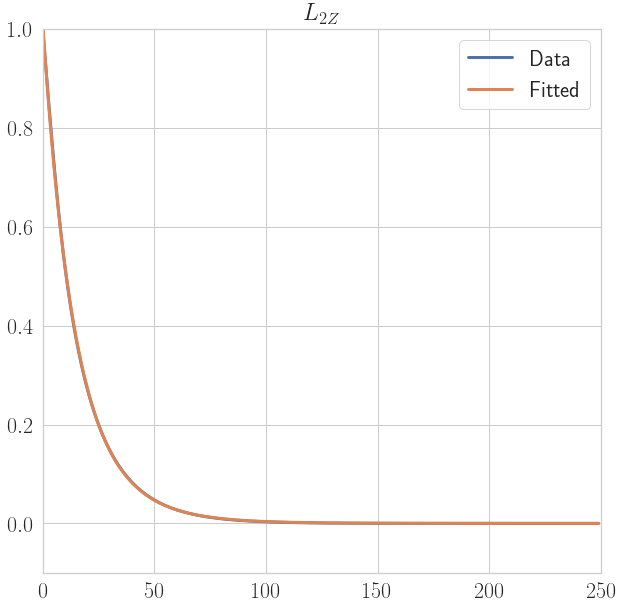

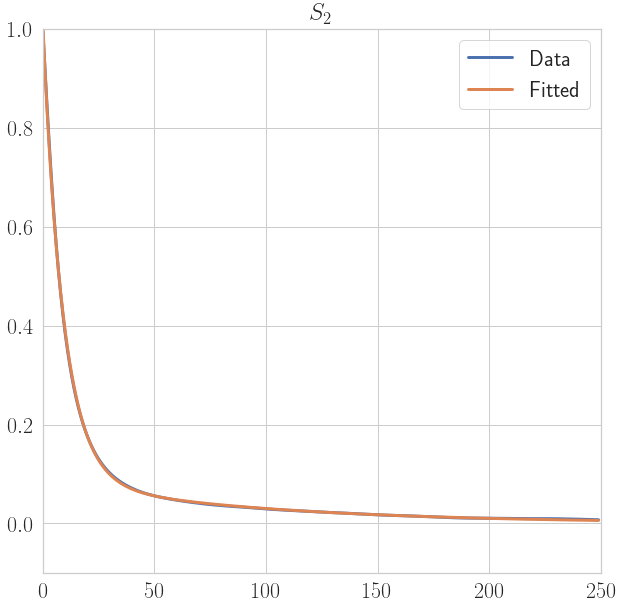

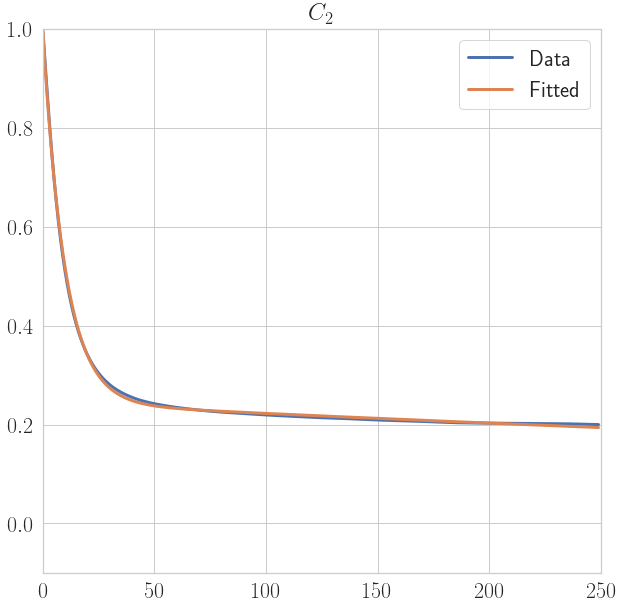

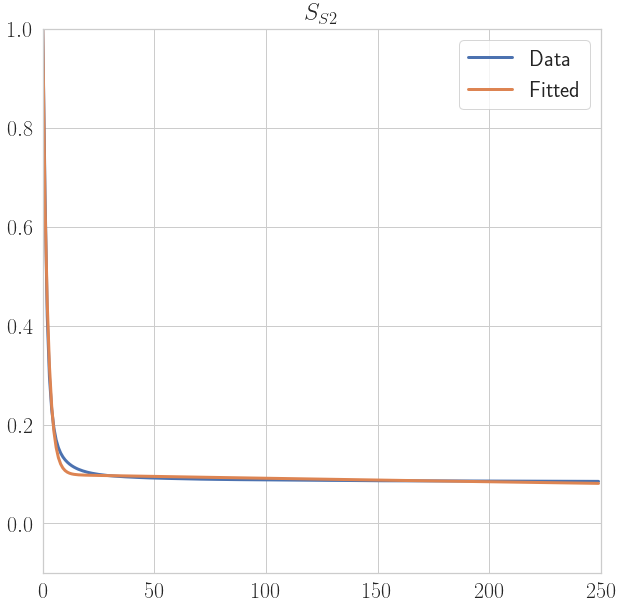

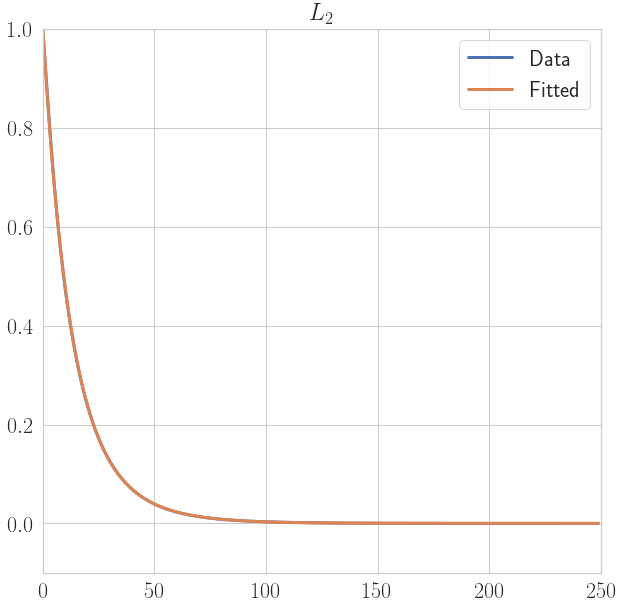

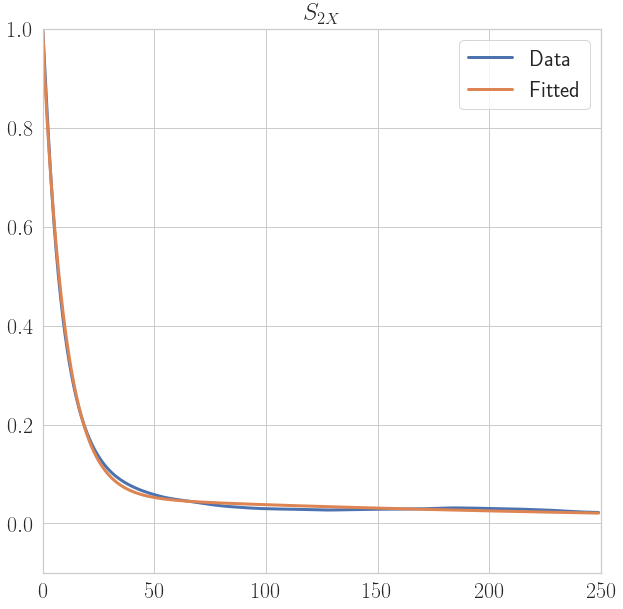

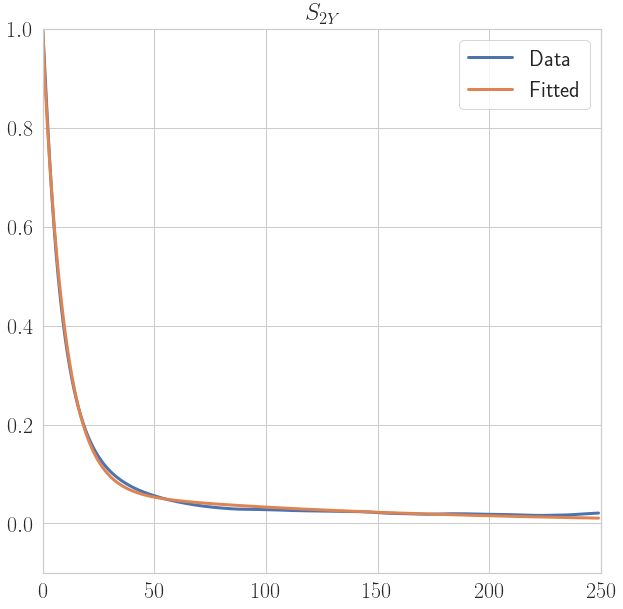

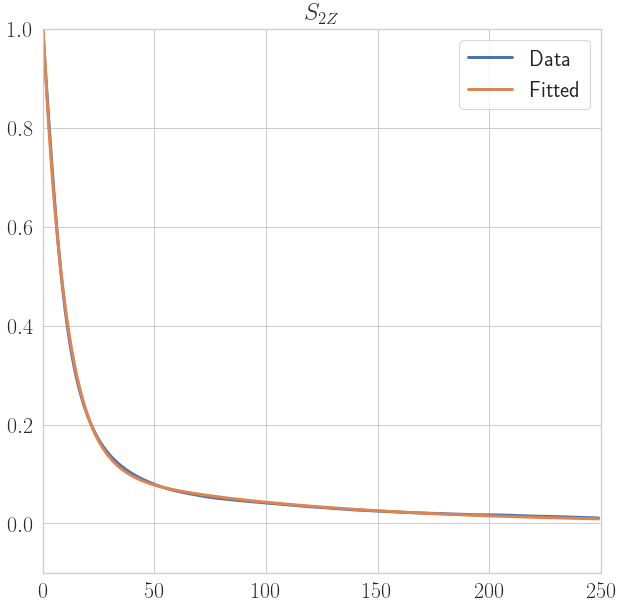

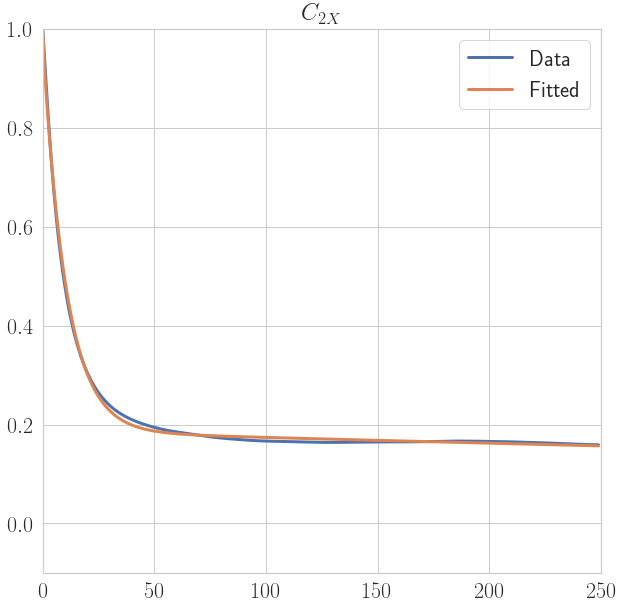

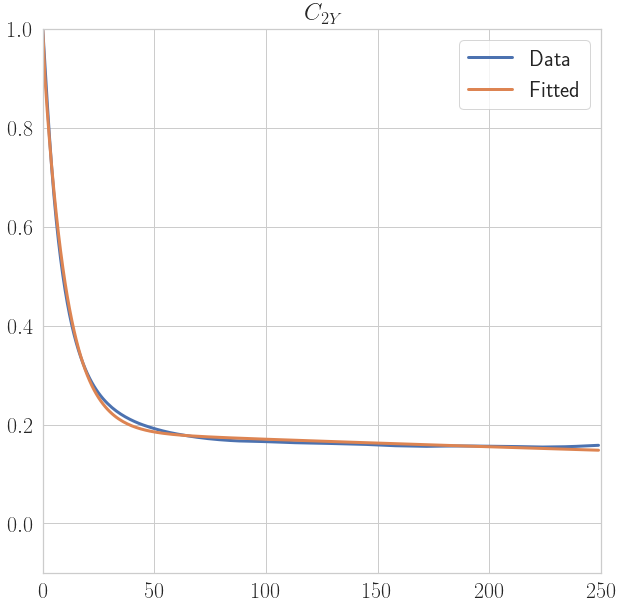

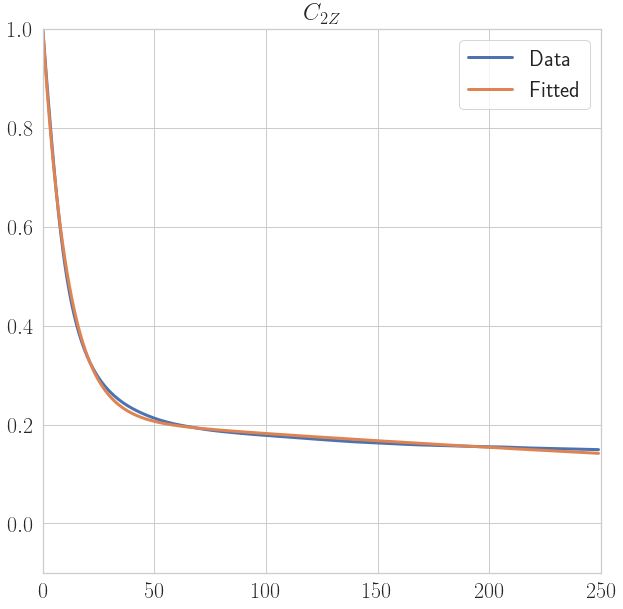

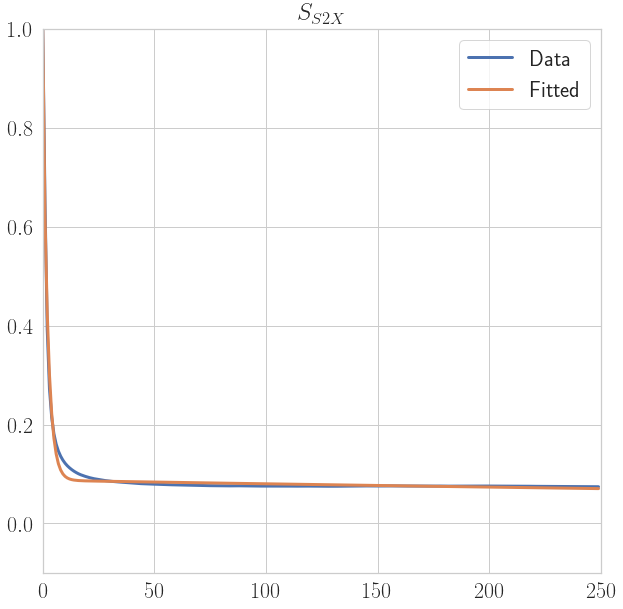

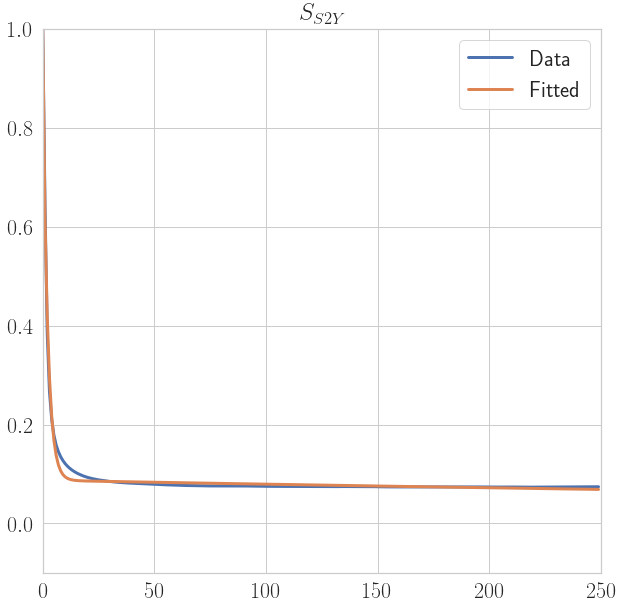

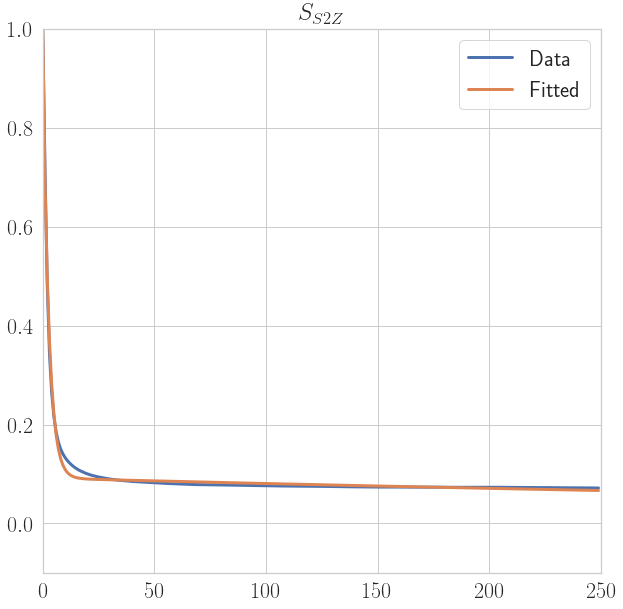

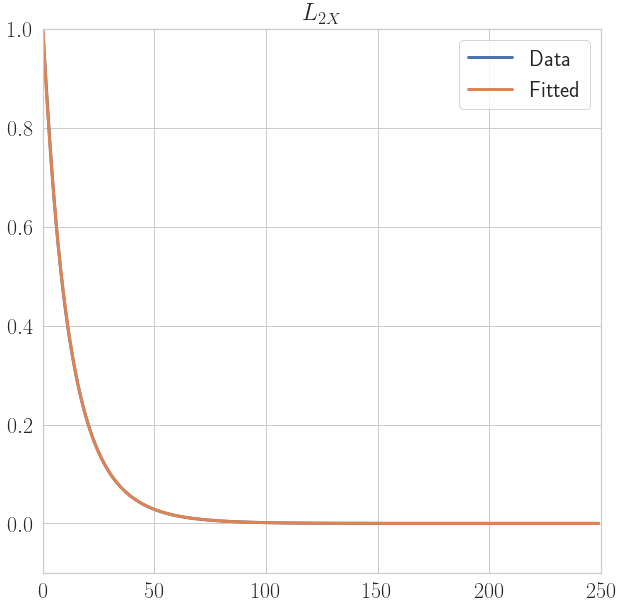

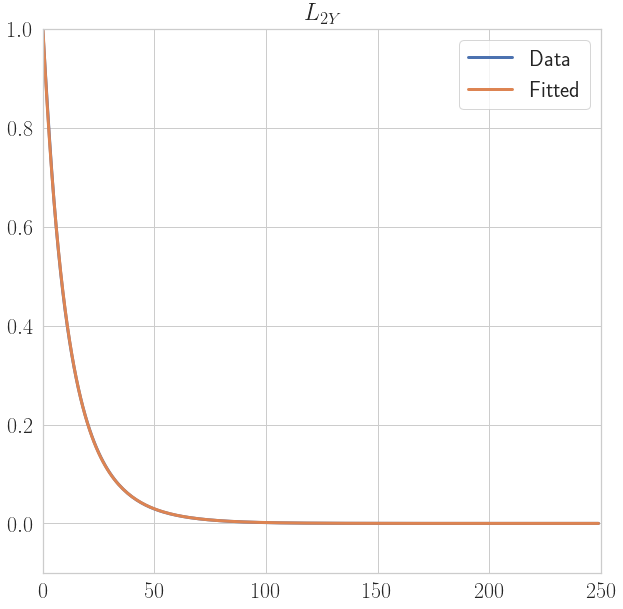

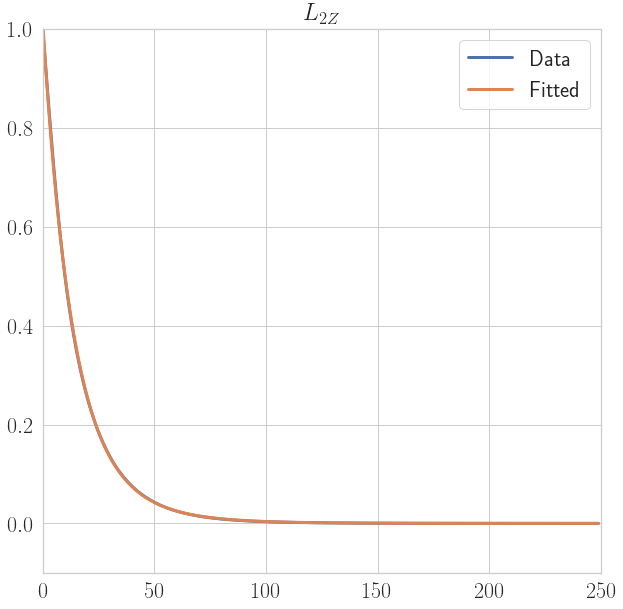

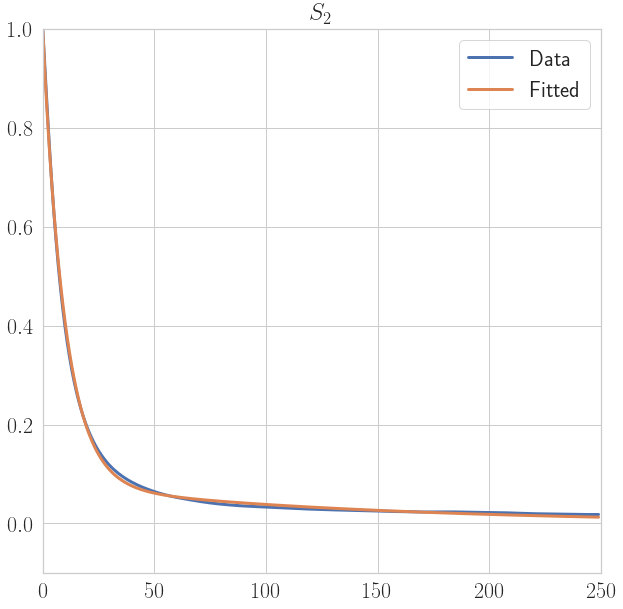

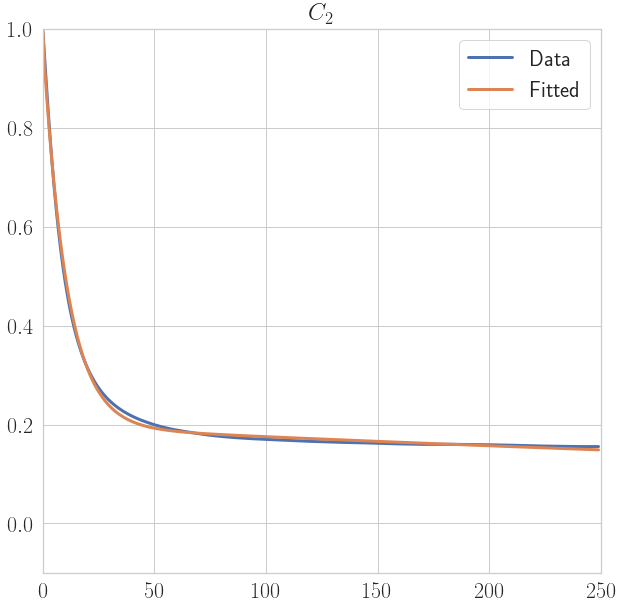

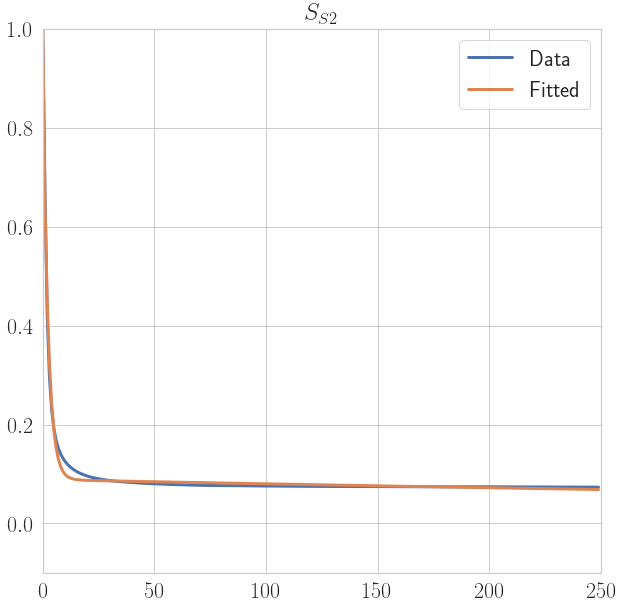

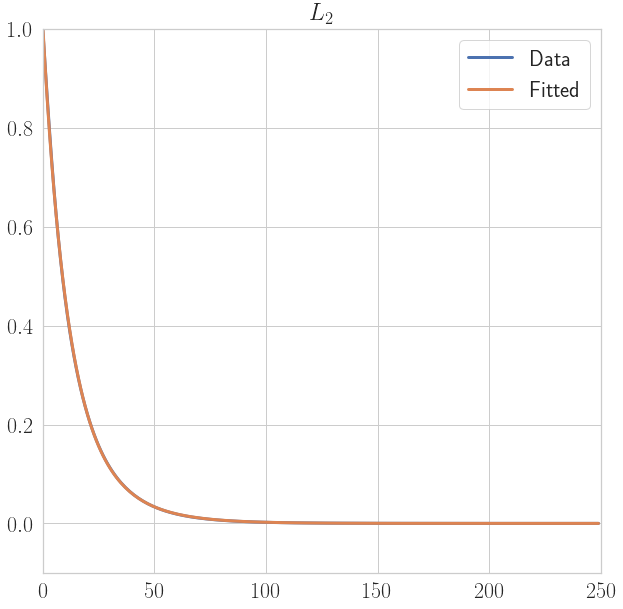

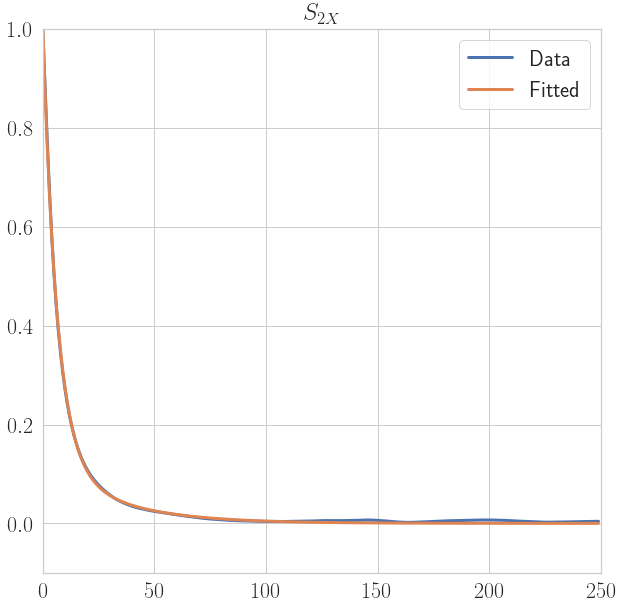

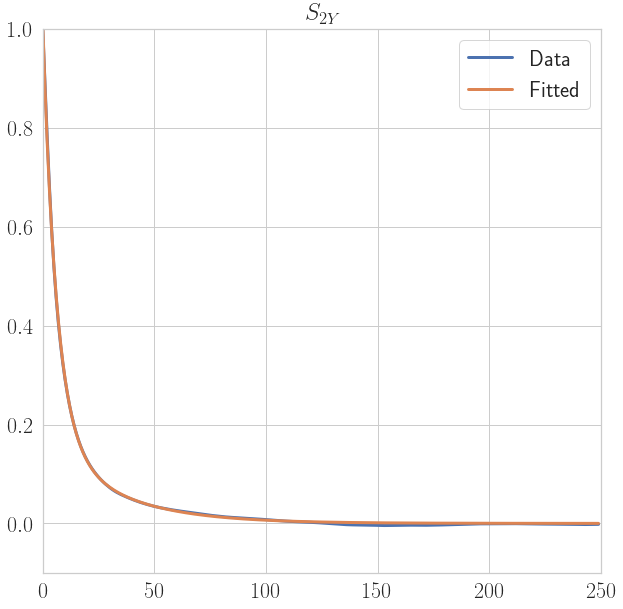

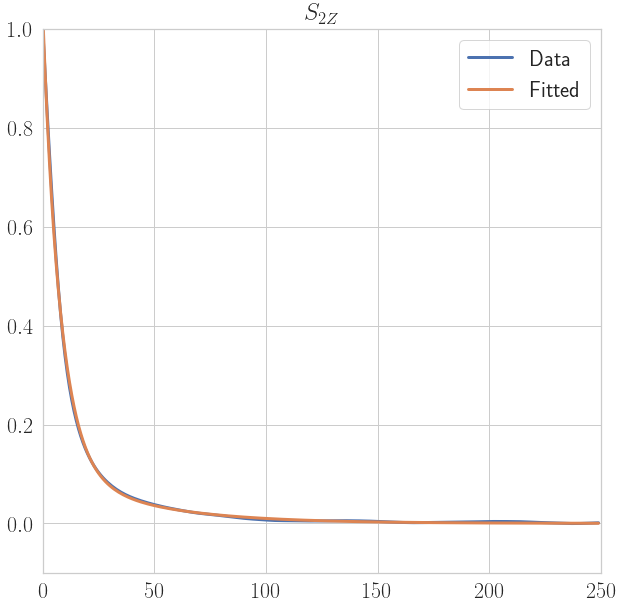

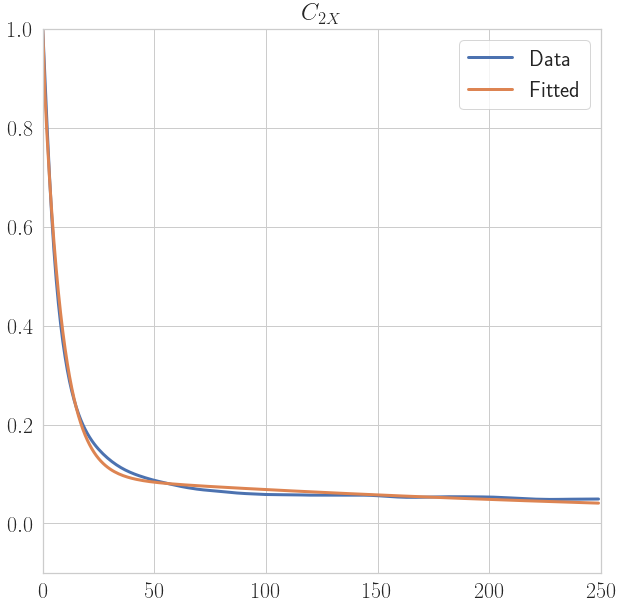

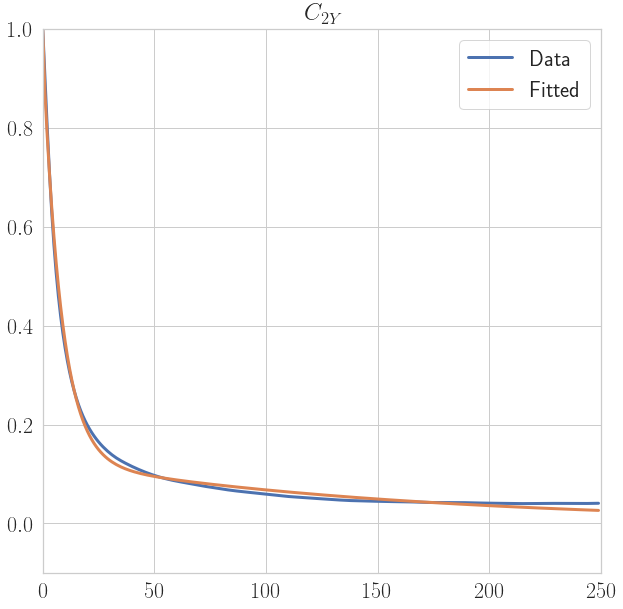

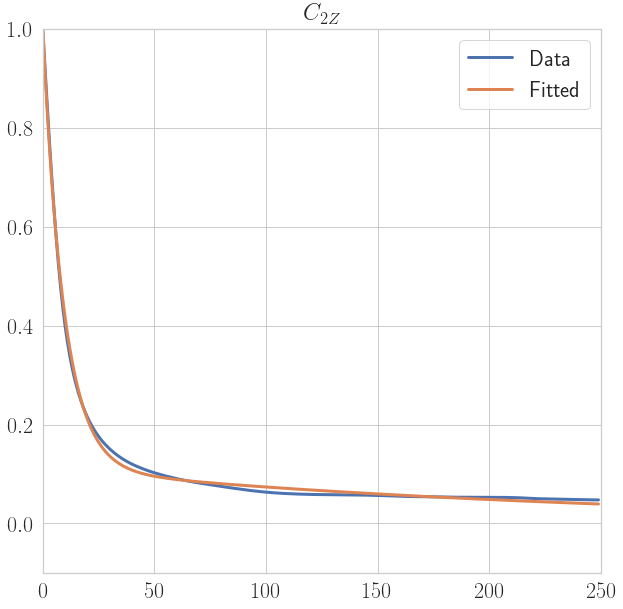

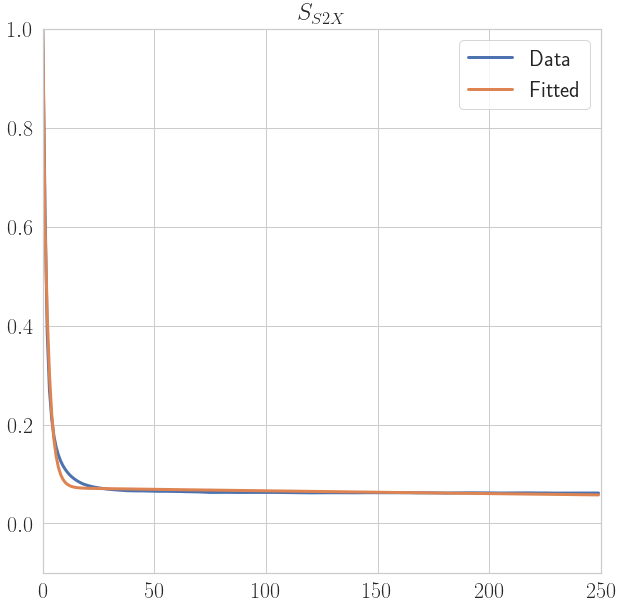

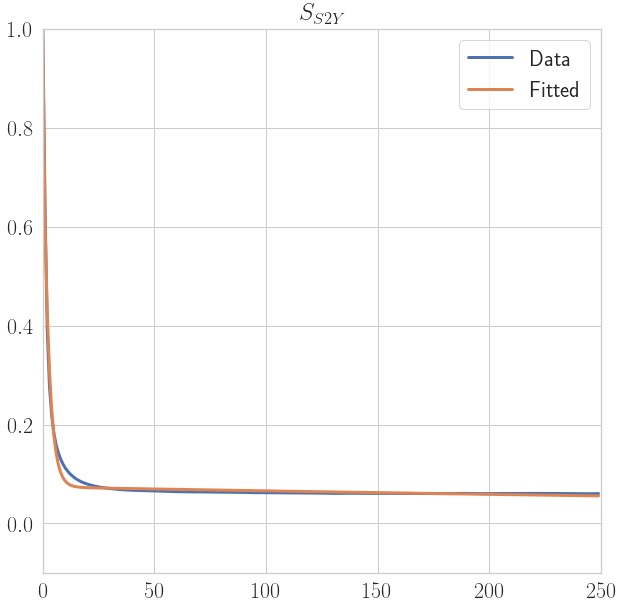

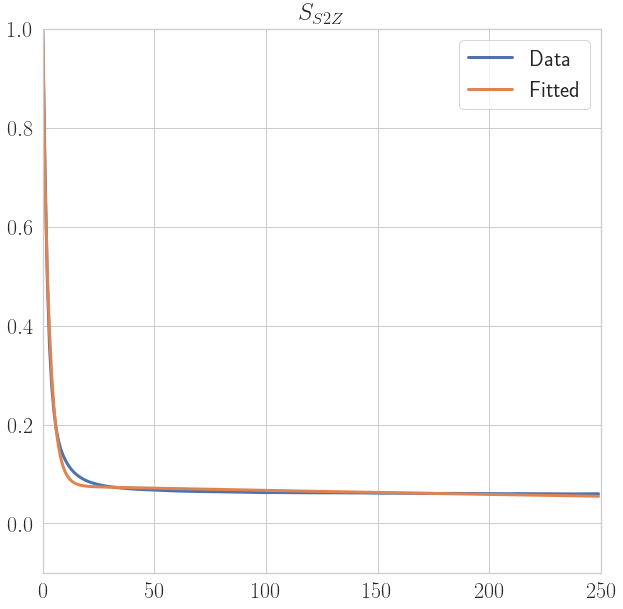

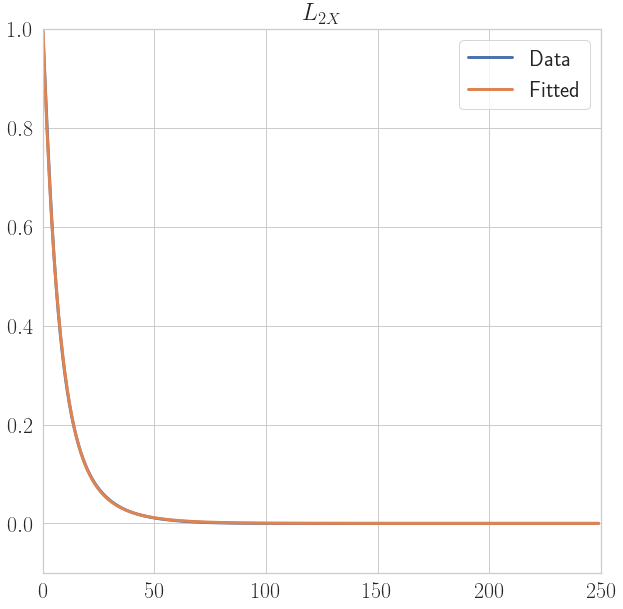

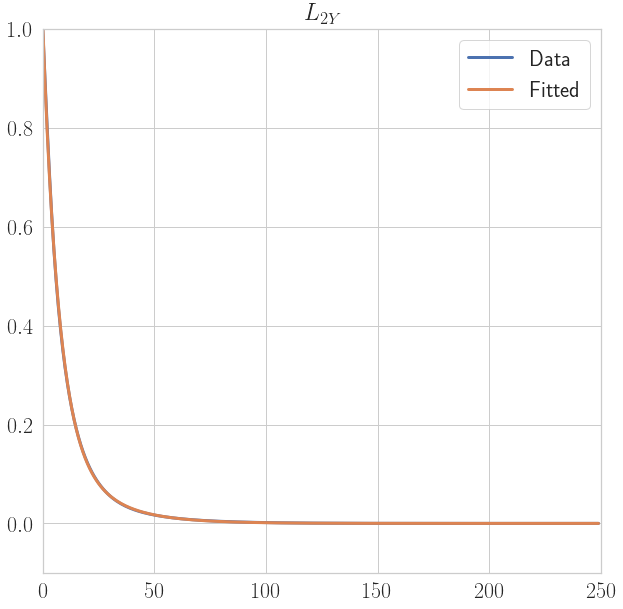

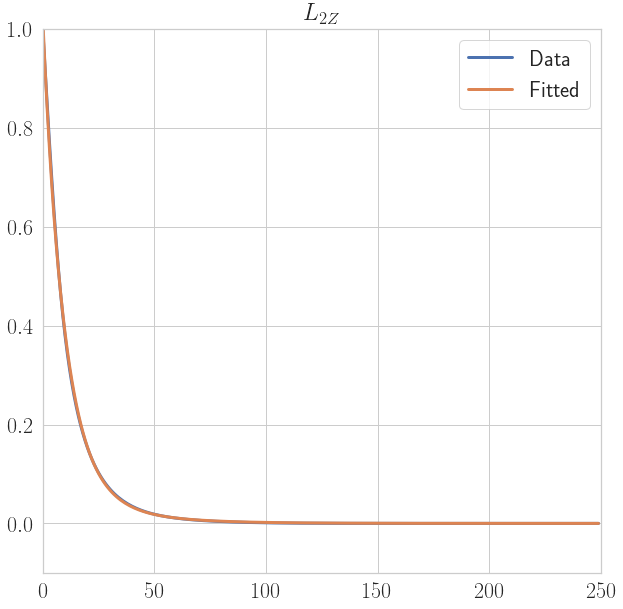

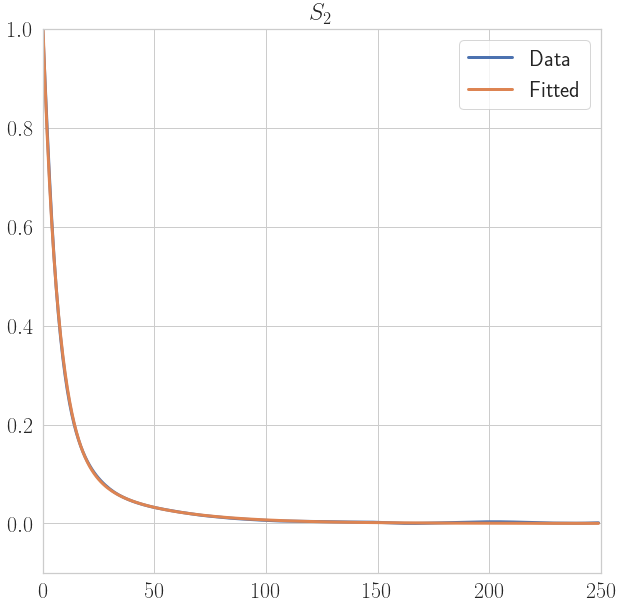

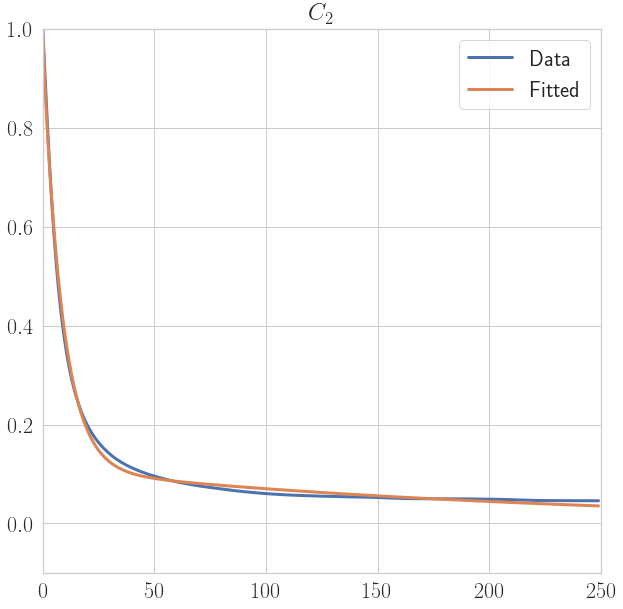

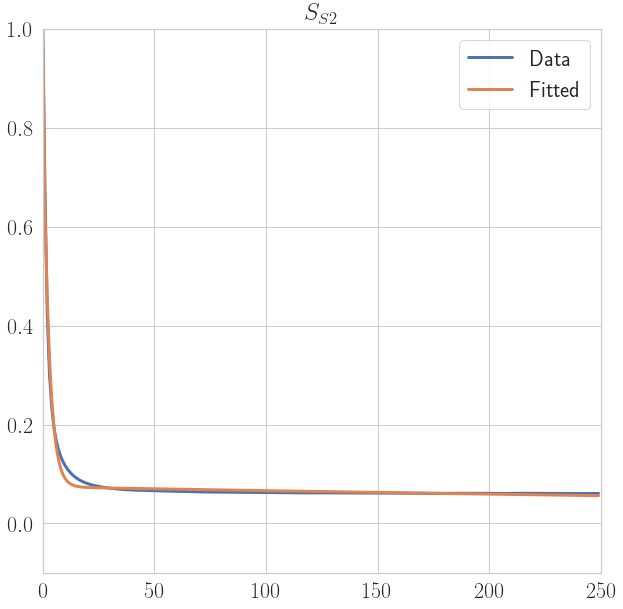

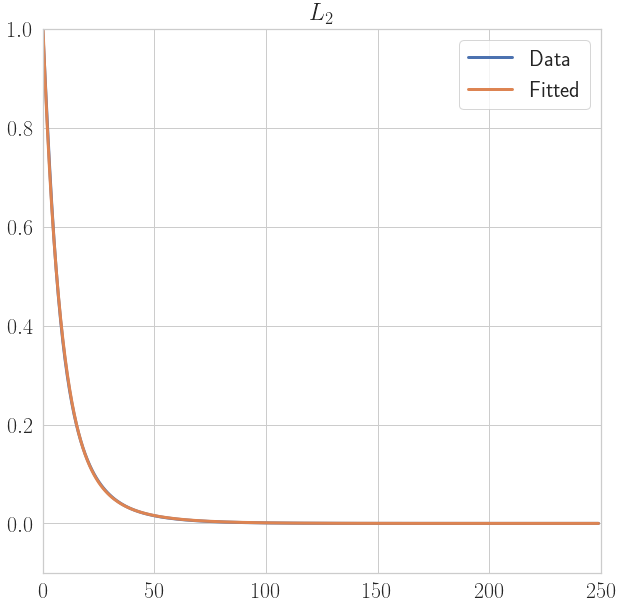

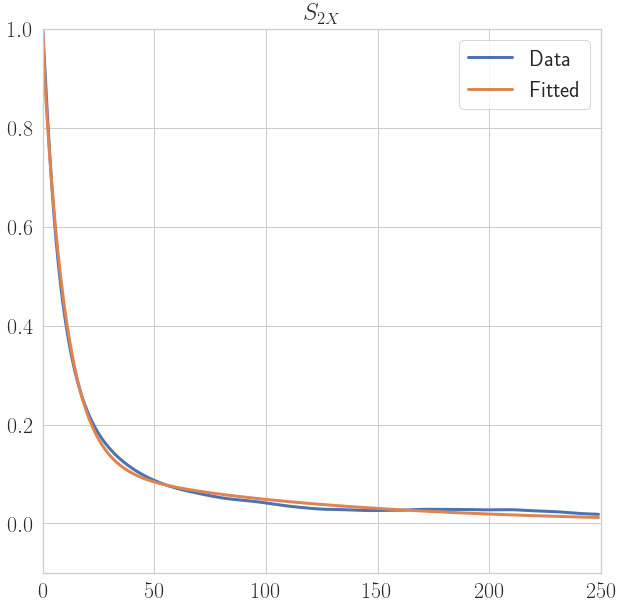

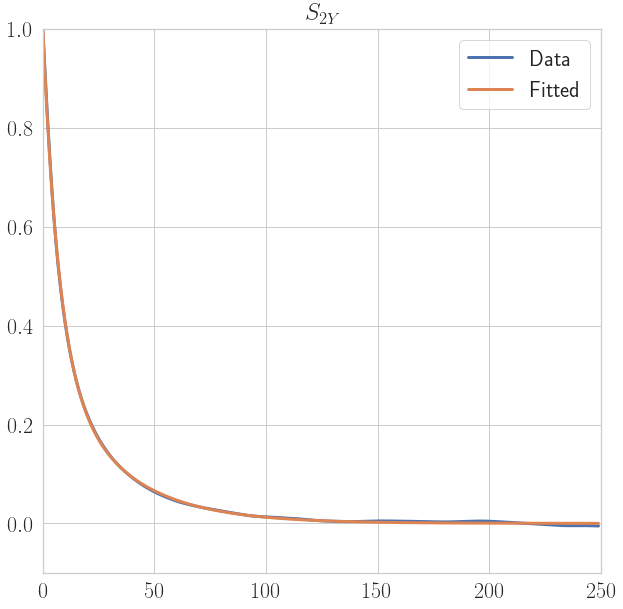

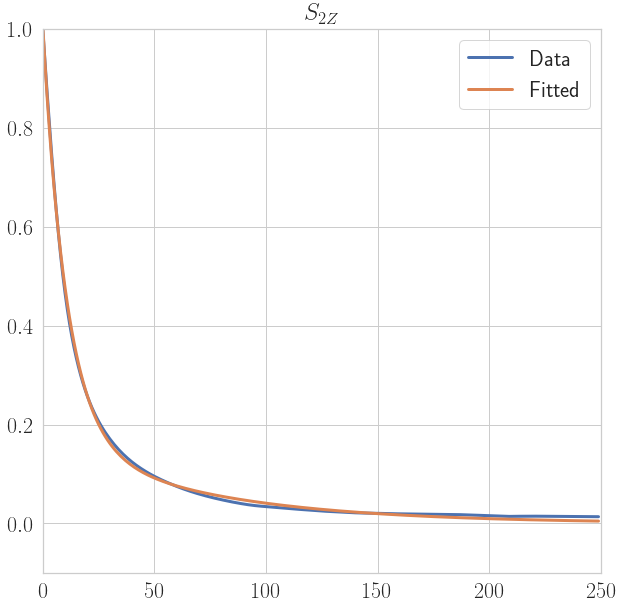

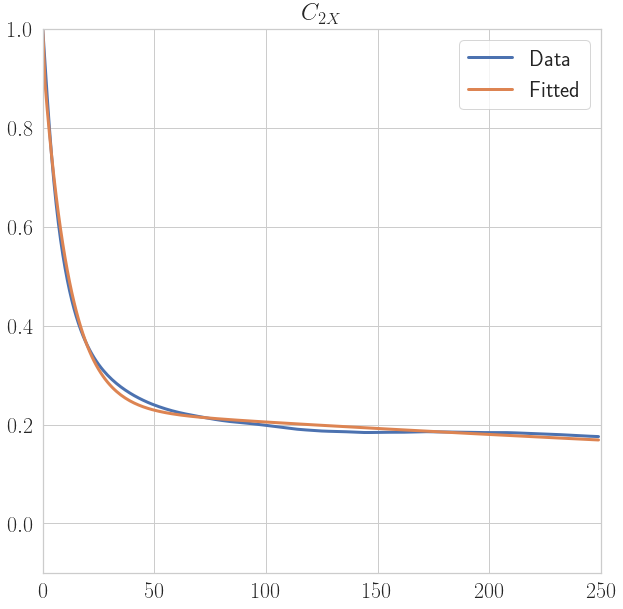

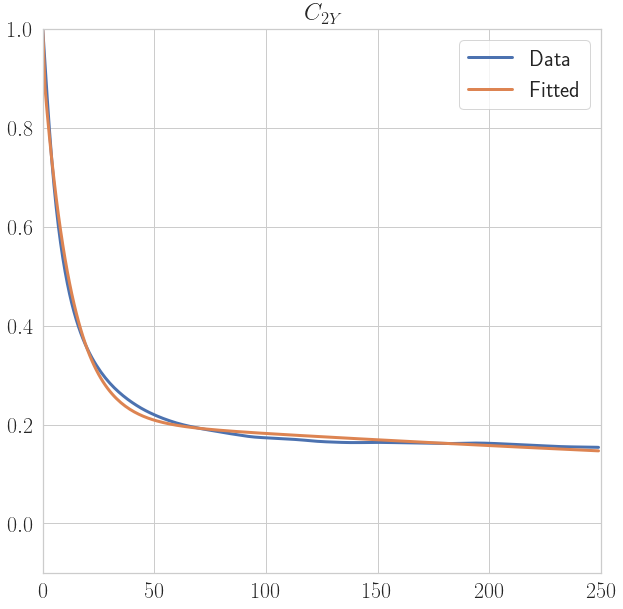

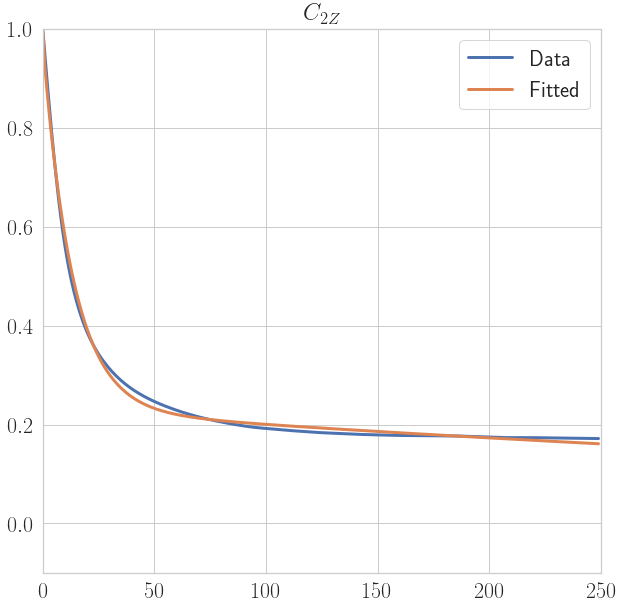

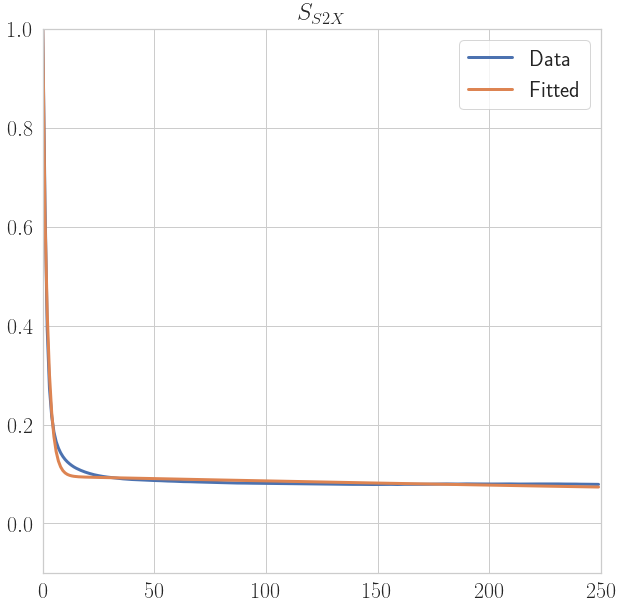

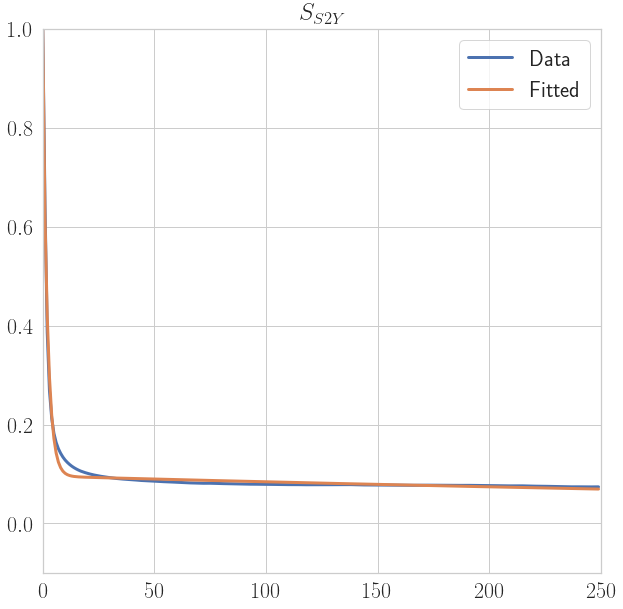

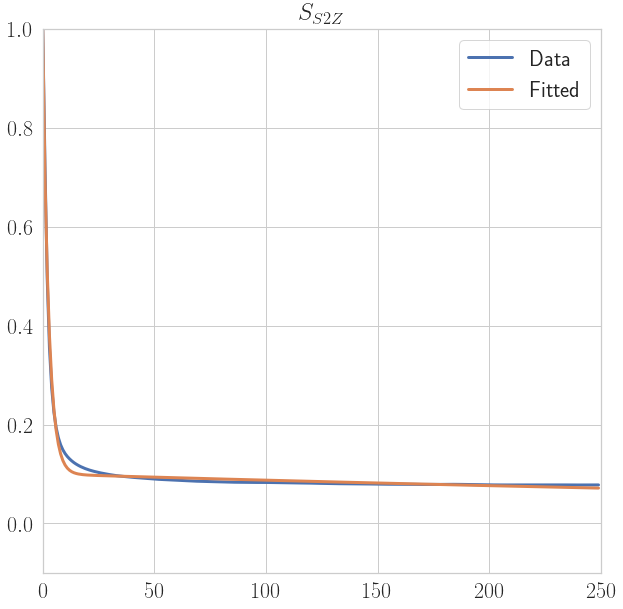

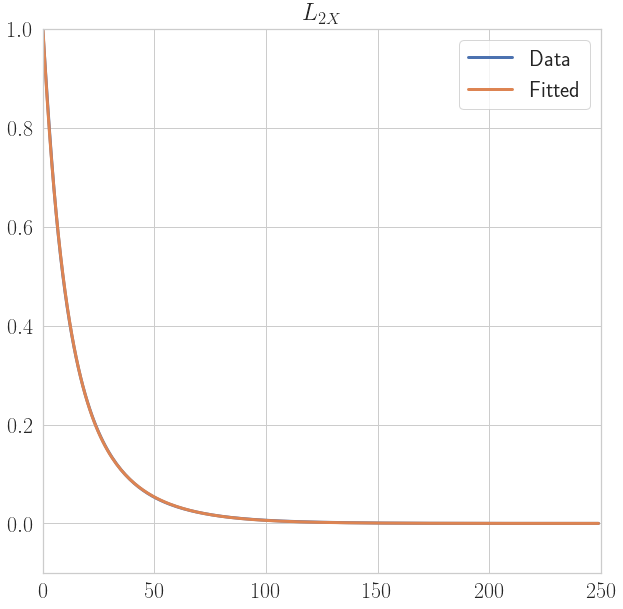

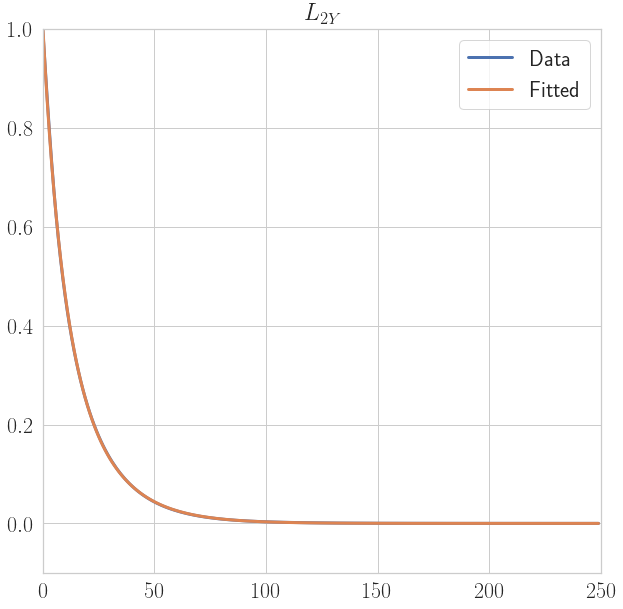

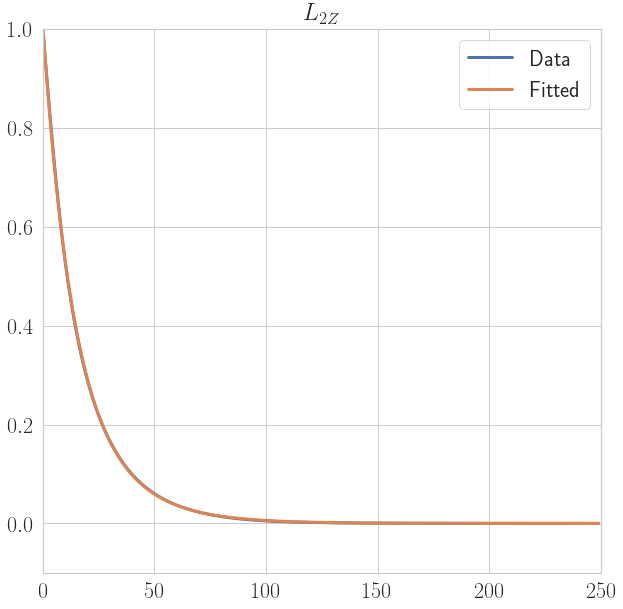

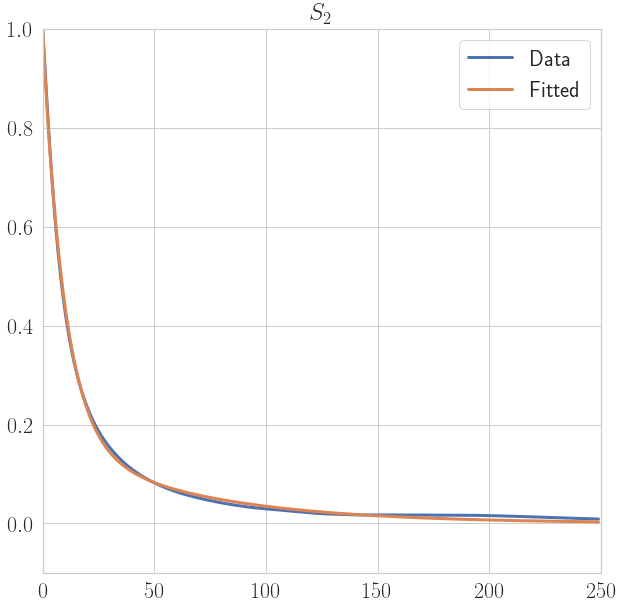

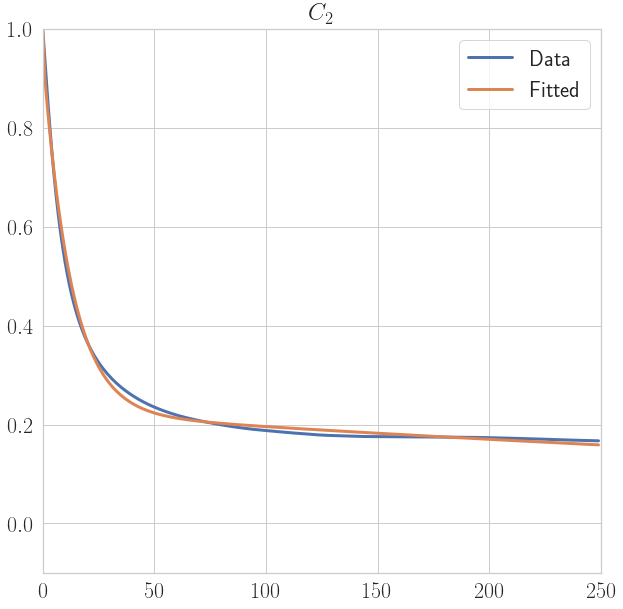

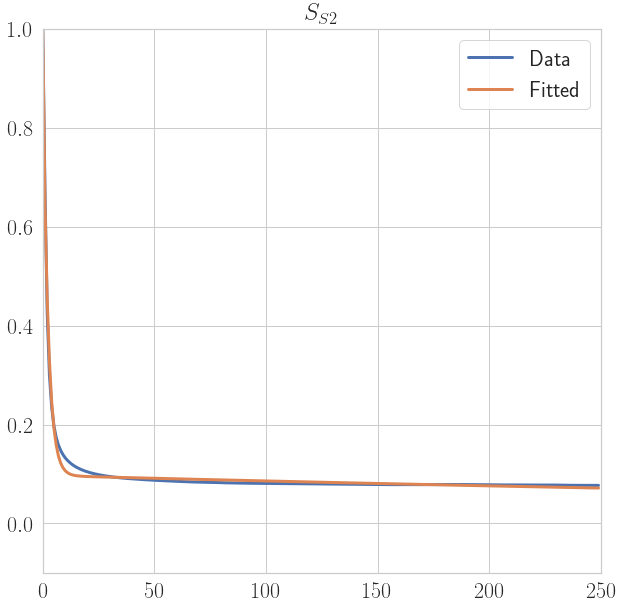

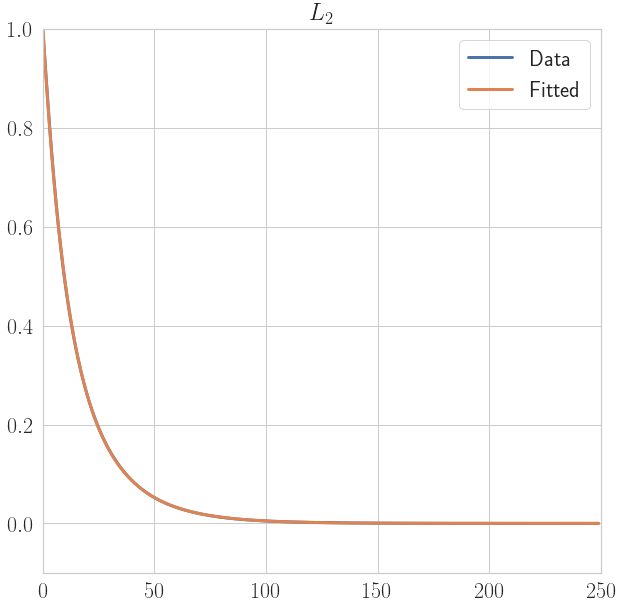

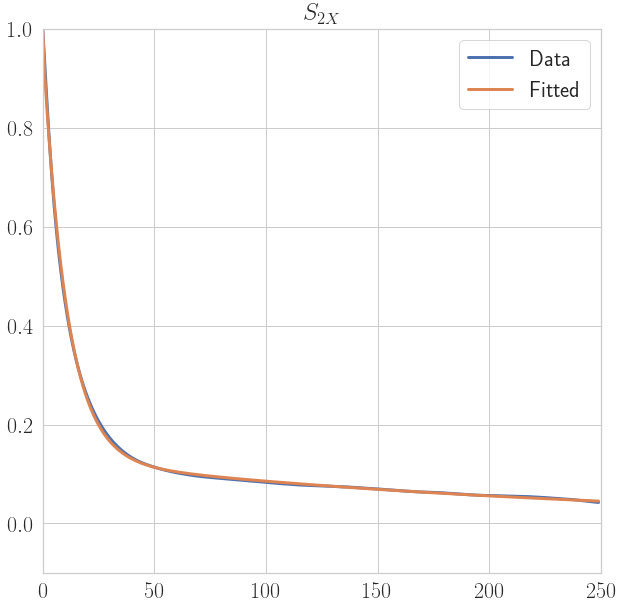

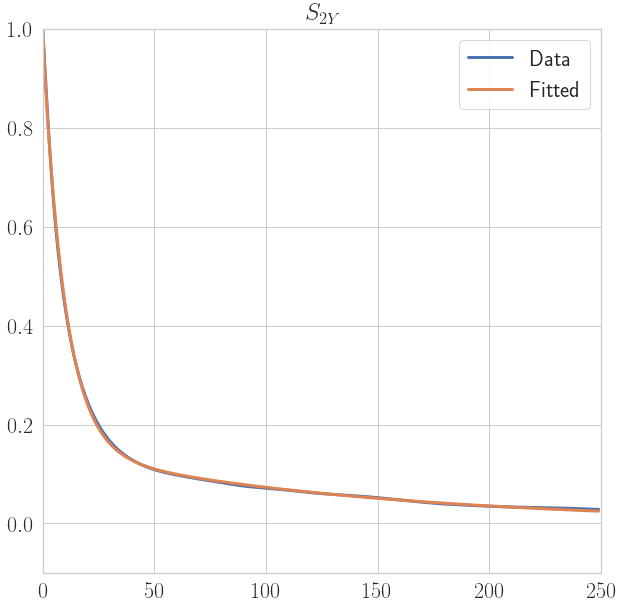

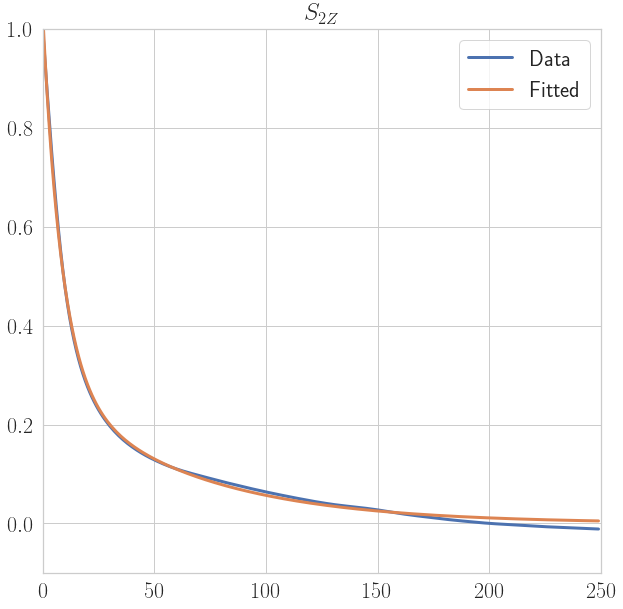

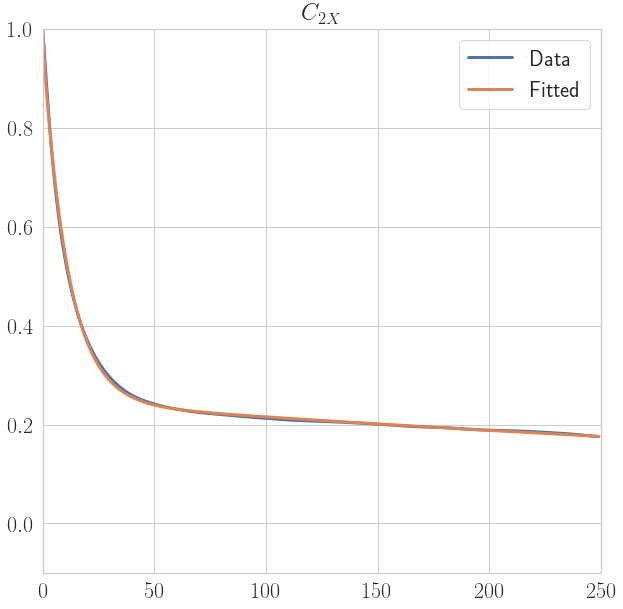

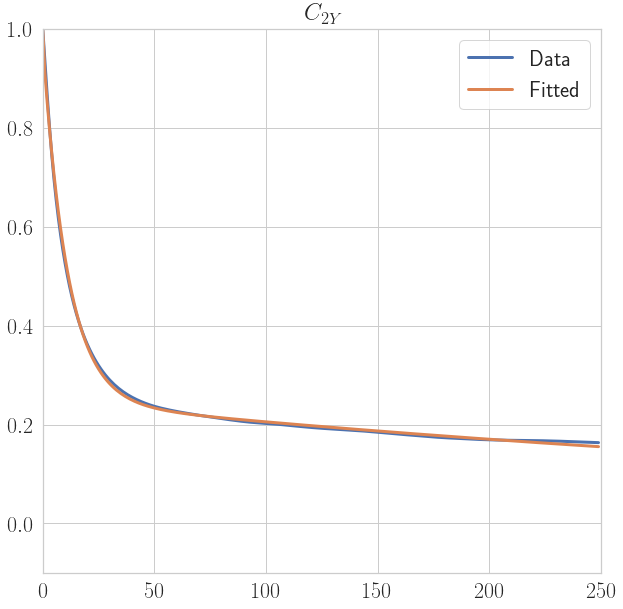

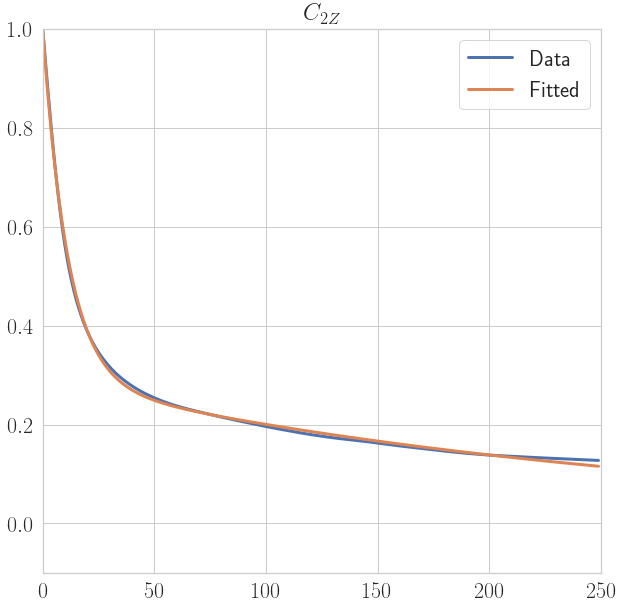

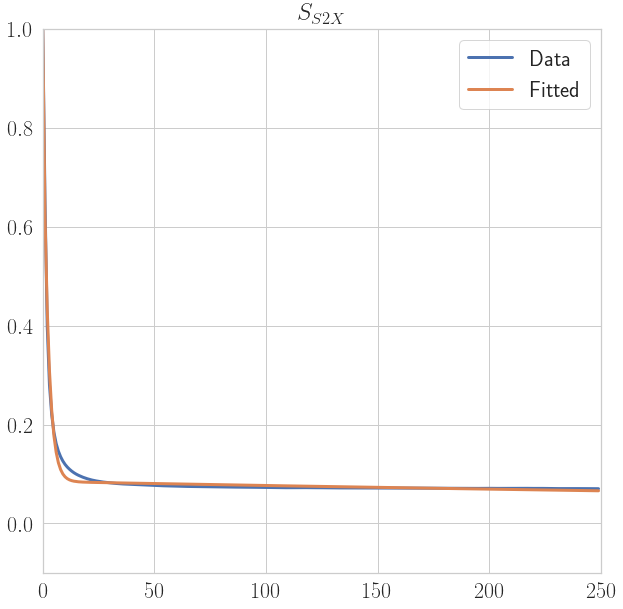

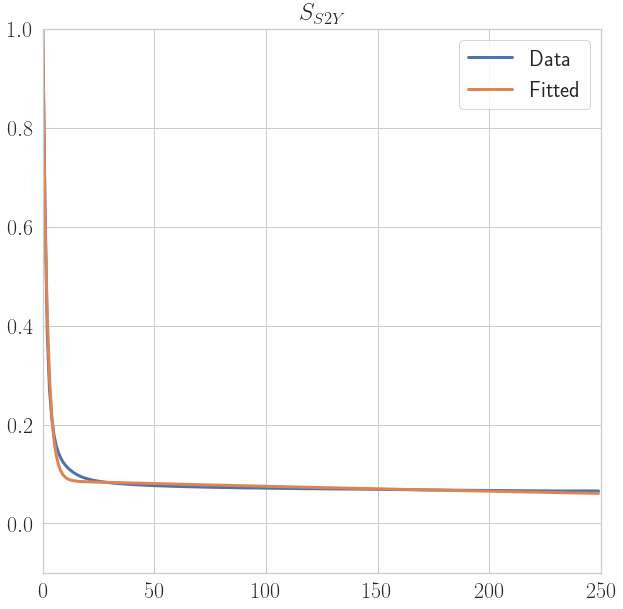

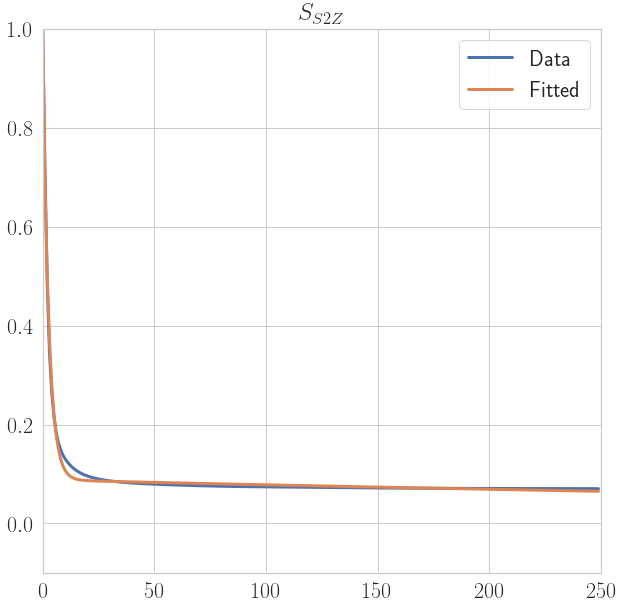

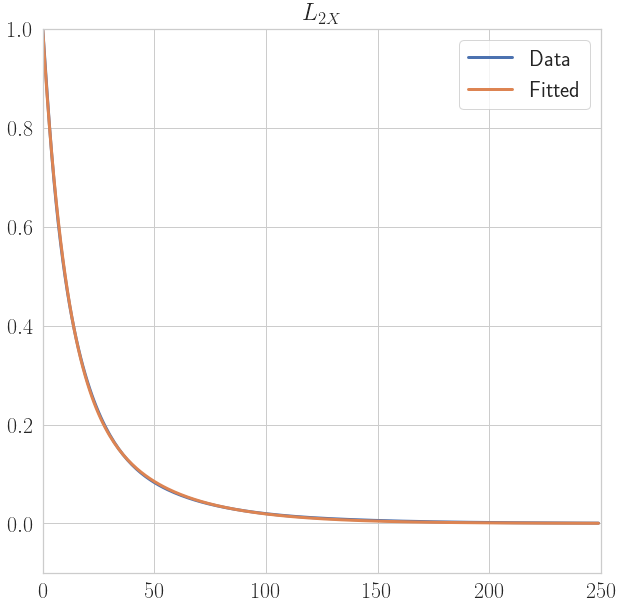

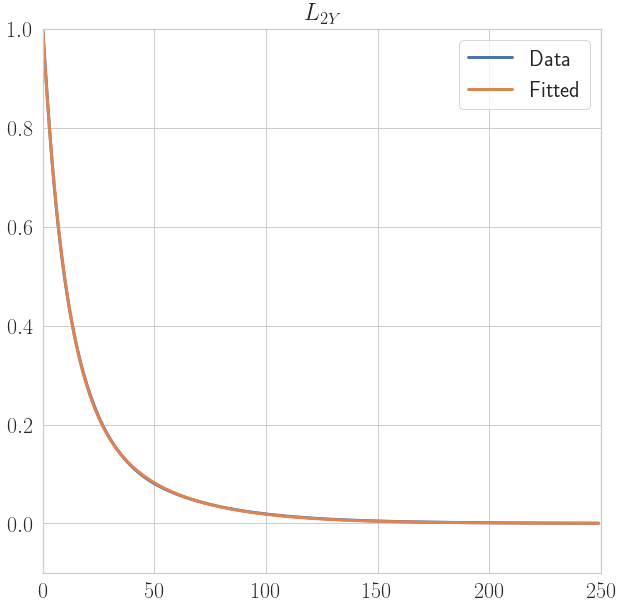

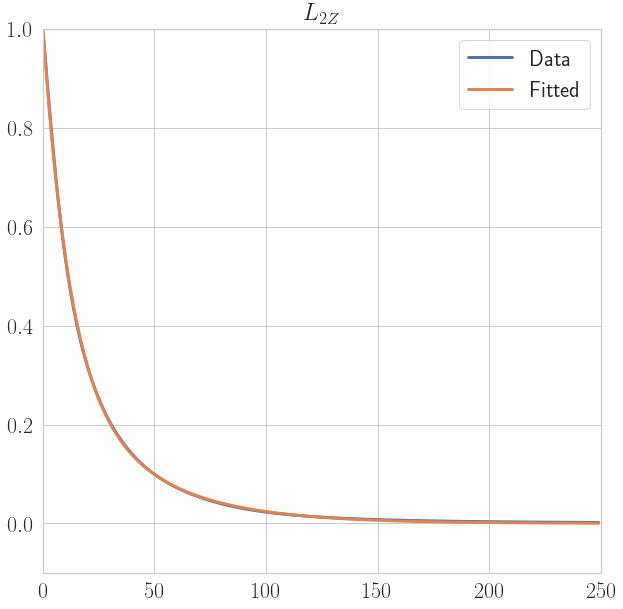

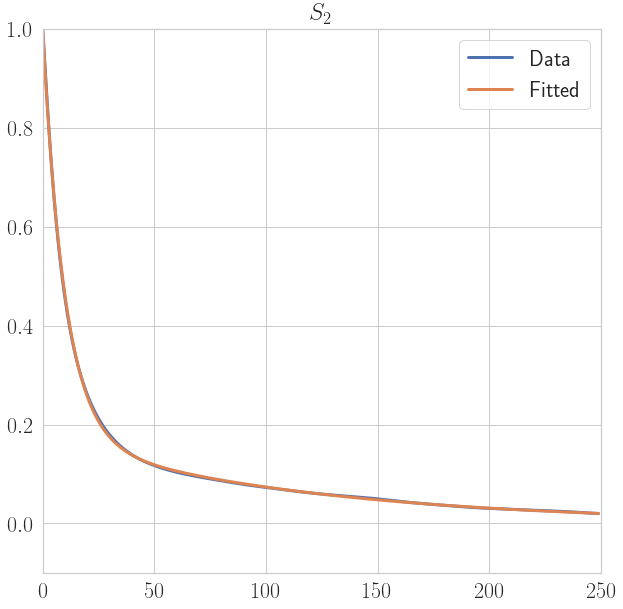

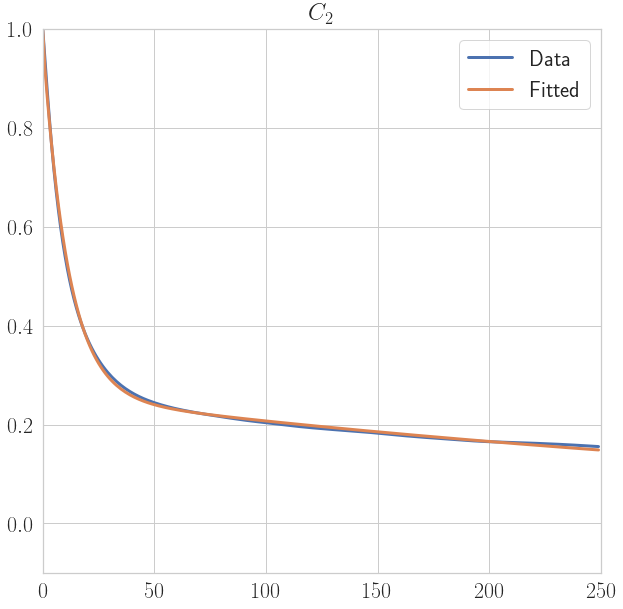

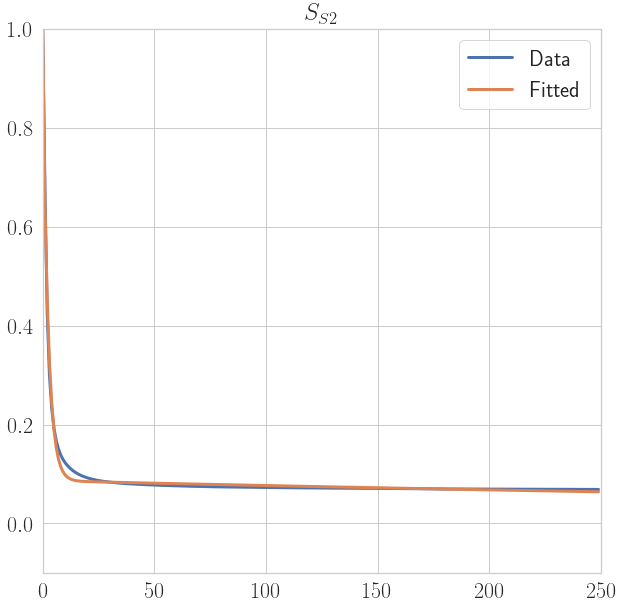

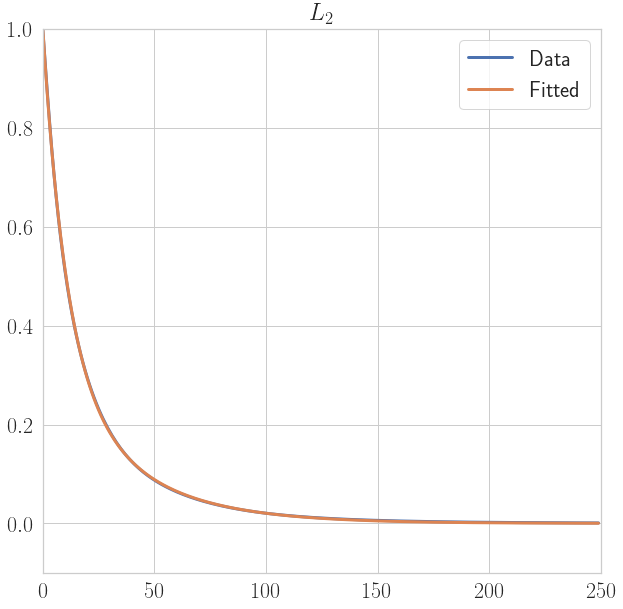

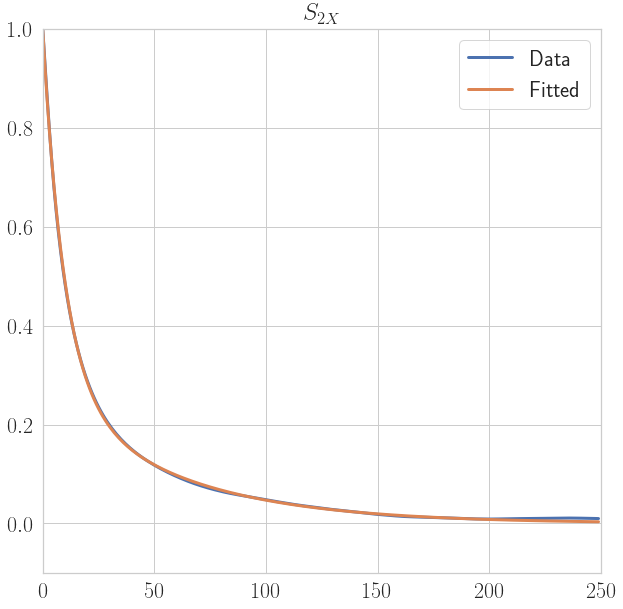

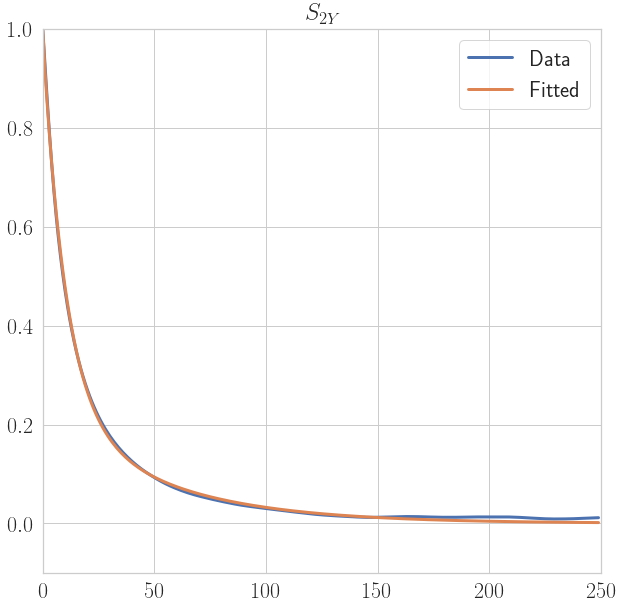

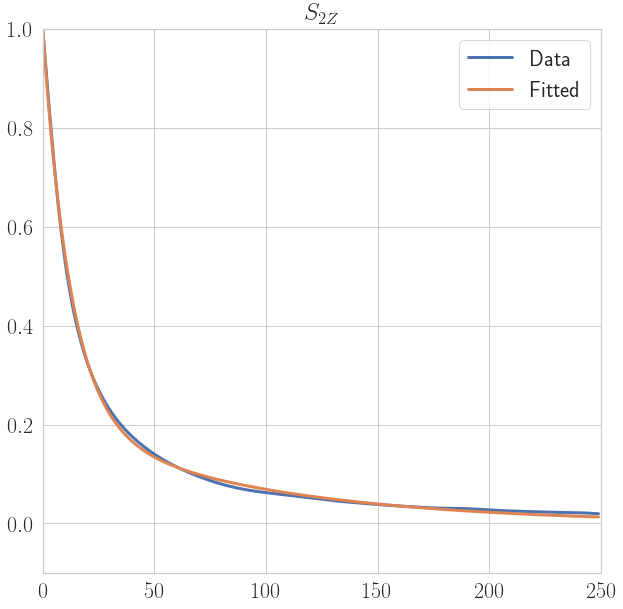

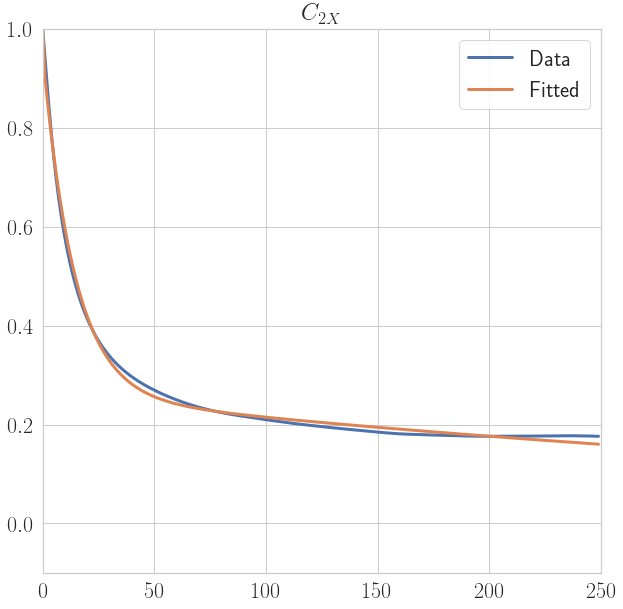

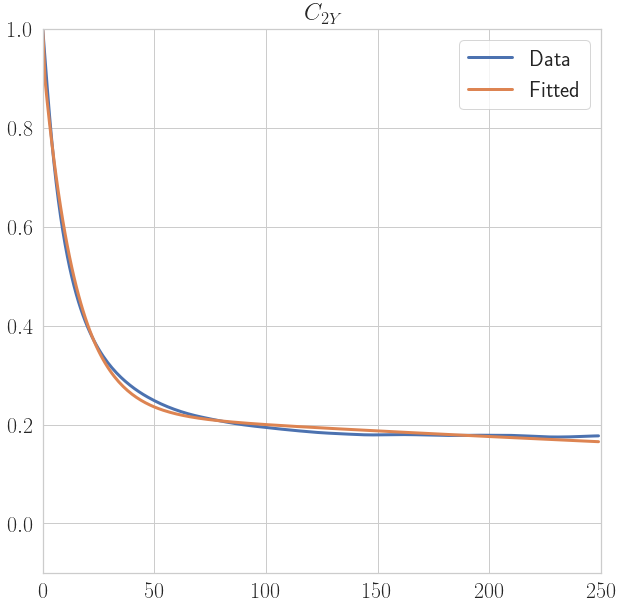

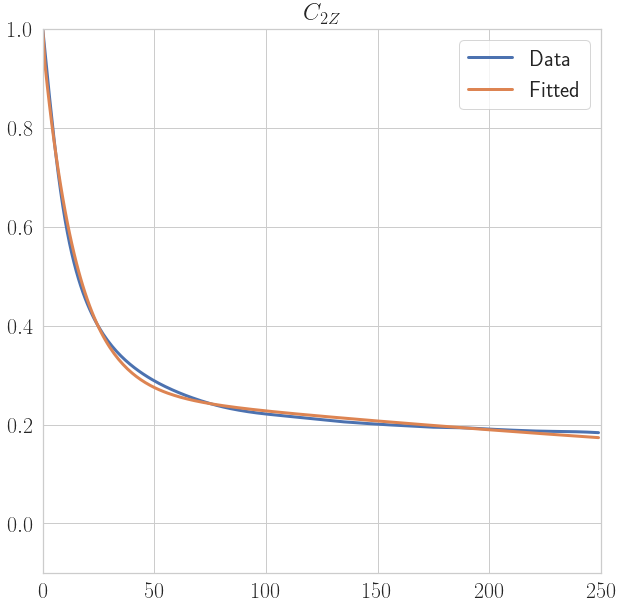

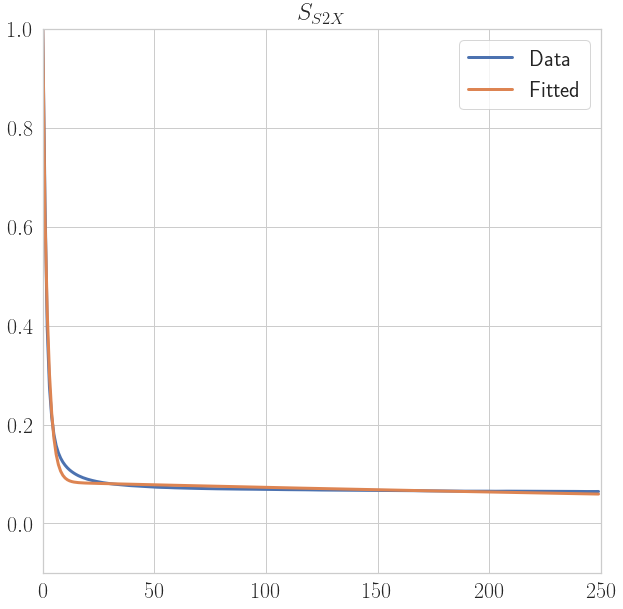

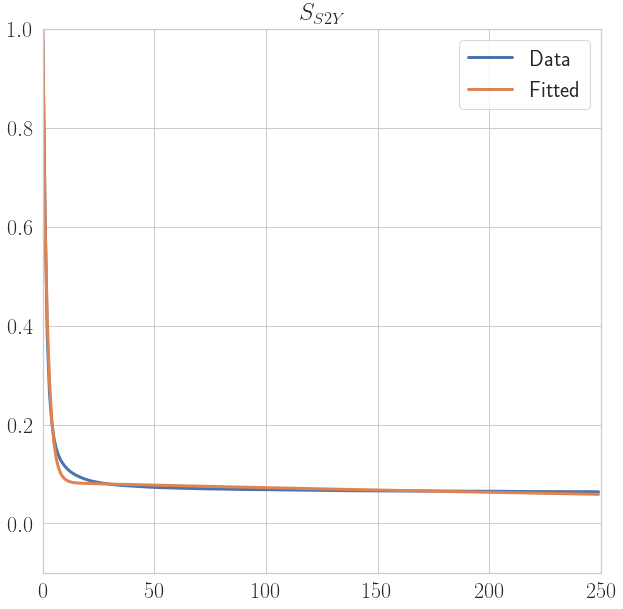

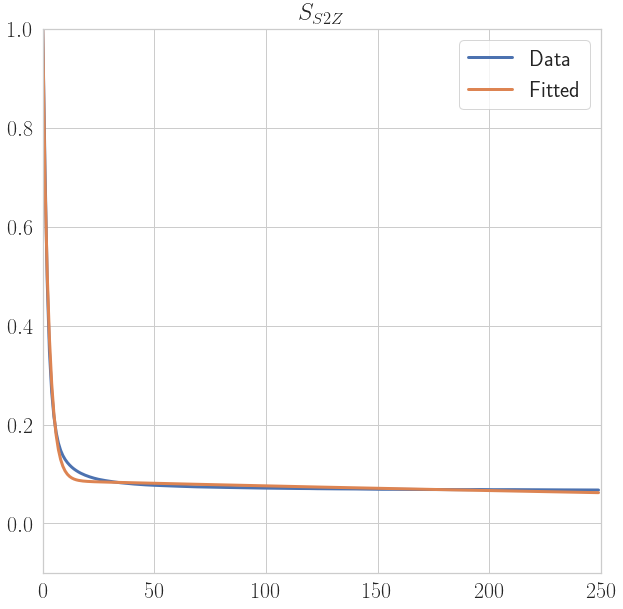

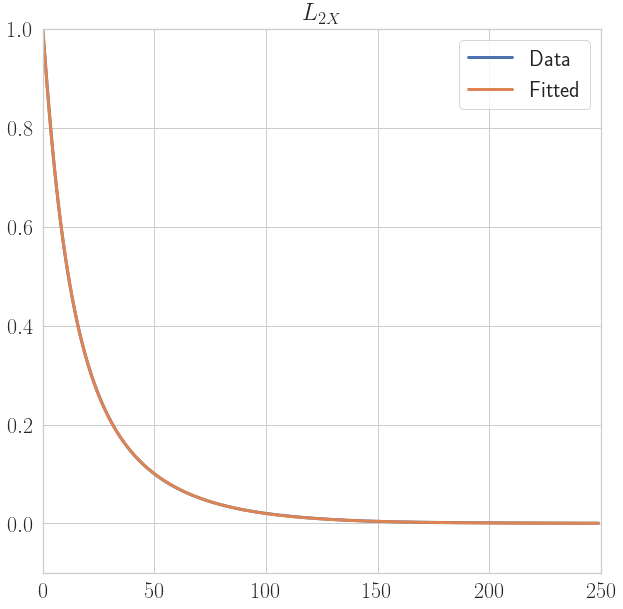

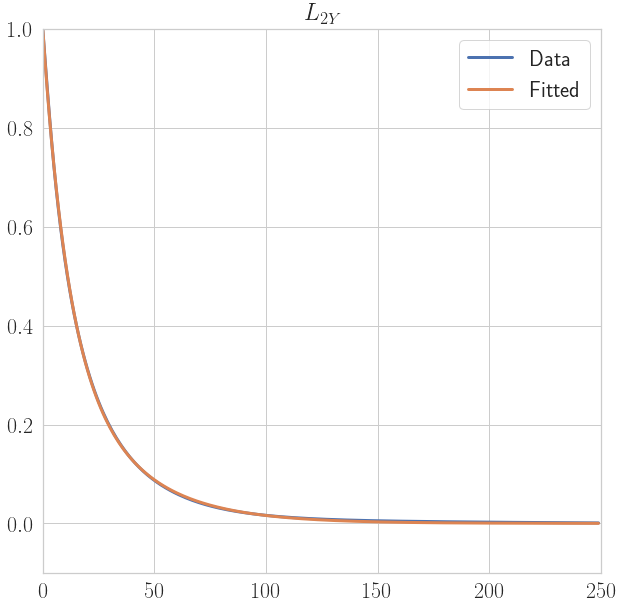

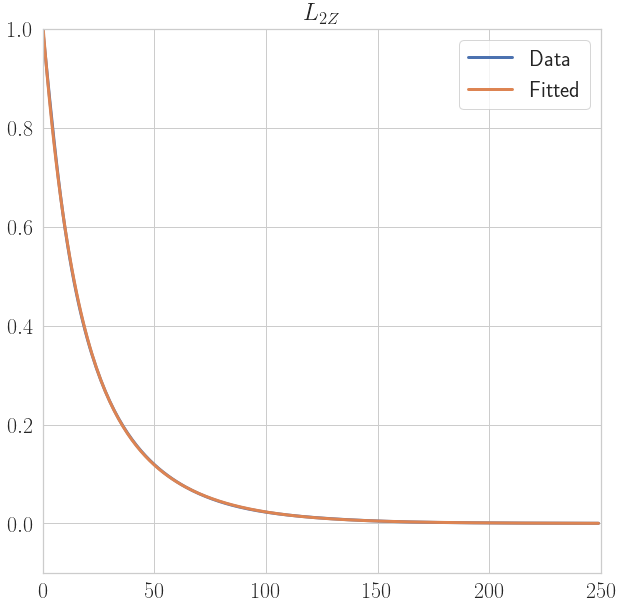

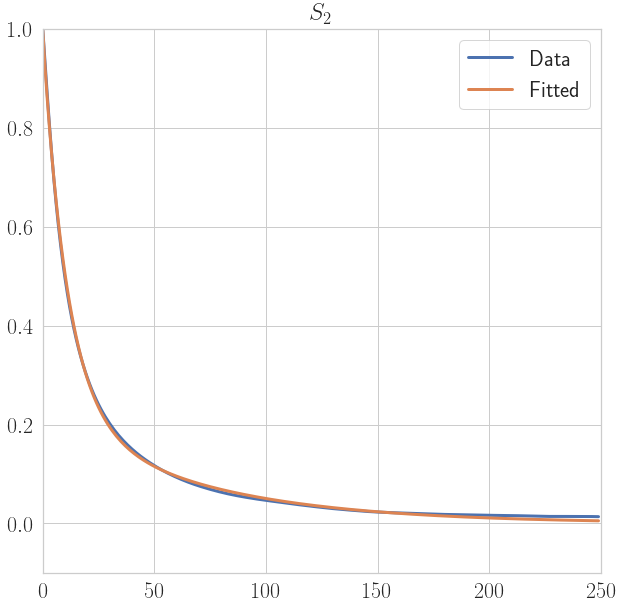

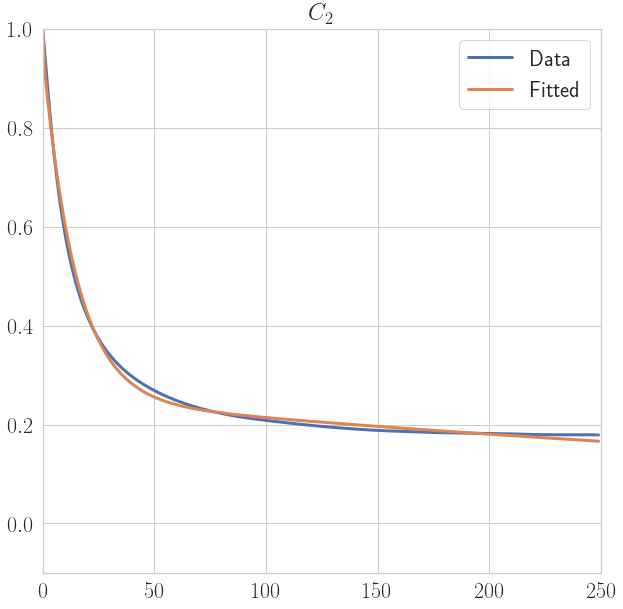

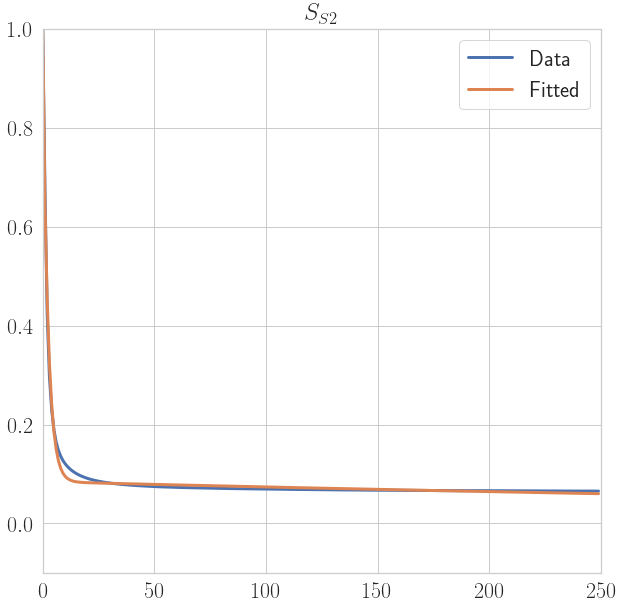

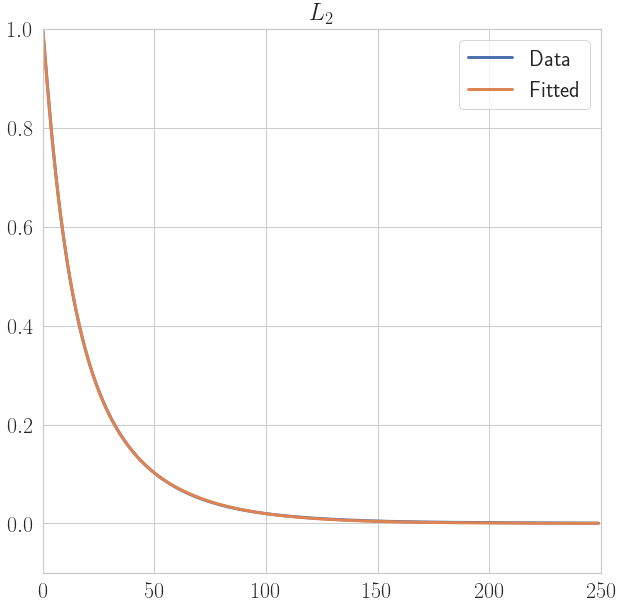

In [10]:
for dir_name in dirs:
    data_path = os.path.join(source_path, dir_name) 
    data = read_data(data_path)
    
    dir_path = os.path.join(data_path, 'results')
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    print('Current directory: {}'.format(dir_path))
    
    # Добавим в данные корр функции, усредненные по всем направлениям
    mean_data = dict()
    for tag, v in data.items():
        tag_edited = tag[:-1]
        if tag_edited not in mean_data:
            mean_data[tag_edited] = np.array(v)
        else:
            mean_data[tag_edited] += np.array(v)
    for tag, v in mean_data.items():
        mean_data[tag] = list(v / 3)
    data.update(mean_data)
    
    # Для каждого тега сделаем фит
    for tag in tqdm(data):
        phi = data[tag][0] 
        exp_data = normalization(data, tag=tag)
        n = exp_data.shape[0]

        scores = dict()
        # Семплируем много стартовых точек, чтобы получить наилучшее решение
        for i in range(25):
            # Два способа зафитить кривую - чисто экспоненциальный или две экспоненты + квадратичное слагаемое
#             if tag.startswith('L2'):
#                 result = fit_curve(exp_data, f_exp, get_x0_exp, unpack_exp, bounds_exp, 
#                                    cons_exp, phi=phi)
#             else:
            result = fit_curve(exp_data, f_standard, get_x0_standard,
                               unpack_standard, bounds_standard, 
                               cons_exp)
            scores[result['SSE']] = result

        best = min(scores) 
        result = scores[best]
        result['tag'] = tag
        result['dir_name'] = dir_name
        plot_results(result, tag, dir_path=dir_path)
        results.append(result)

In [11]:
X = []
Y = []
for r in results:
    X.append(np.array(r['x']).reshape(1, -1))
    Y.append('{}_{}'.format(r['dir_name'], r['tag']))
X = np.concatenate(X, axis=0)

In [12]:
import pickle
with open('viz_data_new.pkl', 'wb') as f:
    pickle.dump((X, Y), f)

In [13]:
with open('data_new.pkl', 'wb') as f:
    pickle.dump(results, f)